In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
import numpy as np
from util import getHashId, pickleLoad

feature_selection = pickleLoad('data/feature_selection.pkl')
features_oc = np.load('data/preprocessed/features_vox.npy')
exc = 10
features = [f for f in features_oc if f not in feature_selection['excludeds'][exc][np.argmax(feature_selection['accuracies'][exc])]]

props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : features,
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_1_t1t2_normalized_firstorder_TotalEnergy_firstorder_Minimum_firstorder_10Percentile_firstorder_Median_firstorder_InterquartileRange_firstorder_Range_firstorder_RobustMeanAbsoluteDeviation_firstorder_RootMeanSquared_firstorder_Skewness_firstorder_Kurtosis_firstorder_Variance_firstorder_Uniformity_glcm_JointAverage_glcm_ClusterProminence_glcm_ClusterShade_glcm_ClusterTendency_glcm_Contrast_glcm_Correlation_glcm_DifferenceAverage_glcm_DifferenceEntropy_glcm_DifferenceVariance_glcm_JointEnergy_glcm_JointEntropy_glcm_Imc2_glcm_Idm_glcm_MCC_glcm_Idmn_glcm_Id_glcm_Idn_glcm_InverseVariance_glcm_MaximumProbability_glcm_SumEntropy_glcm_SumSquares_glszm_SmallAreaEmphasis_glszm_LargeAreaEmphasis_glszm_GrayLevelNonUniformity_glszm_GrayLevelNonUniformityNormalized_glszm_SizeZoneNonUniformity_glszm_SizeZoneNonUniformityNormalized_glszm_ZonePercentage_glszm_GrayLevelVariance_glszm_ZoneVariance_glszm_ZoneEntropy_glszm_HighGrayLevelZoneEmphasis_glszm_Sma

In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(3944610, 828)
(3944610, 8)
validation
(464344, 828)
(464344, 8)
test
(574820, 828)
(574820, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1538952 (5.87 MB)


Trainable params: 1538952 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/395 [..............................] - ETA: 8:21 - loss: 2.2604 - STD: 0.0716 - MAE: 0.2197

  5/395 [..............................] - ETA: 5s - loss: 2.1180 - STD: 0.0587 - MAE: 0.2164  

  9/395 [..............................] - ETA: 5s - loss: 2.1004 - STD: 0.0502 - MAE: 0.2166

 13/395 [..............................] - ETA: 5s - loss: 2.0855 - STD: 0.0438 - MAE: 0.2167

 17/395 [>.............................] - ETA: 5s - loss: 2.0778 - STD: 0.0437 - MAE: 0.2165

 21/395 [>.............................] - ETA: 5s - loss: 2.0713 - STD: 0.0418 - MAE: 0.2165

 25/395 [>.............................] - ETA: 5s - loss: 2.0648 - STD: 0.0392 - MAE: 0.2165

 29/395 [=>............................] - ETA: 5s - loss: 2.0568 - STD: 0.0389 - MAE: 0.2162

 33/395 [=>............................] - ETA: 5s - loss: 2.0469 - STD: 0.0395 - MAE: 0.2159

 37/395 [=>............................] - ETA: 5s - loss: 2.0342 - STD: 0.0409 - MAE: 0.2153

 41/395 [==>...........................] - ETA: 5s - loss: 2.0210 - STD: 0.0432 - MAE: 0.2147

 45/395 [==>...........................] - ETA: 5s - loss: 2.0076 - STD: 0.0457 - MAE: 0.2140

 49/395 [==>...........................] - ETA: 5s - loss: 1.9948 - STD: 0.0482 - MAE: 0.2133

 53/395 [===>..........................] - ETA: 5s - loss: 1.9824 - STD: 0.0505 - MAE: 0.2127

 57/395 [===>..........................] - ETA: 5s - loss: 1.9699 - STD: 0.0527 - MAE: 0.2120

 61/395 [===>..........................] - ETA: 5s - loss: 1.9573 - STD: 0.0548 - MAE: 0.2114

 65/395 [===>..........................] - ETA: 5s - loss: 1.9437 - STD: 0.0568 - MAE: 0.2107

 69/395 [====>.........................] - ETA: 5s - loss: 1.9281 - STD: 0.0588 - MAE: 0.2100

 73/395 [====>.........................] - ETA: 4s - loss: 1.9107 - STD: 0.0609 - MAE: 0.2091

 77/395 [====>.........................] - ETA: 4s - loss: 1.8921 - STD: 0.0634 - MAE: 0.2081

 81/395 [=====>........................] - ETA: 4s - loss: 1.8731 - STD: 0.0661 - MAE: 0.2070

 85/395 [=====>........................] - ETA: 4s - loss: 1.8543 - STD: 0.0690 - MAE: 0.2058

 89/395 [=====>........................] - ETA: 4s - loss: 1.8358 - STD: 0.0718 - MAE: 0.2047

 93/395 [======>.......................] - ETA: 4s - loss: 1.8181 - STD: 0.0745 - MAE: 0.2035

 97/395 [======>.......................] - ETA: 4s - loss: 1.8008 - STD: 0.0772 - MAE: 0.2024

101/395 [======>.......................] - ETA: 4s - loss: 1.7847 - STD: 0.0798 - MAE: 0.2013

105/395 [======>.......................] - ETA: 4s - loss: 1.7692 - STD: 0.0823 - MAE: 0.2002

109/395 [=======>......................] - ETA: 4s - loss: 1.7540 - STD: 0.0847 - MAE: 0.1992

113/395 [=======>......................] - ETA: 4s - loss: 1.7397 - STD: 0.0871 - MAE: 0.1981

117/395 [=======>......................] - ETA: 4s - loss: 1.7261 - STD: 0.0893 - MAE: 0.1972

121/395 [========>.....................] - ETA: 4s - loss: 1.7132 - STD: 0.0914 - MAE: 0.1962

125/395 [========>.....................] - ETA: 4s - loss: 1.7010 - STD: 0.0935 - MAE: 0.1953

129/395 [========>.....................] - ETA: 4s - loss: 1.6890 - STD: 0.0955 - MAE: 0.1944

133/395 [=========>....................] - ETA: 4s - loss: 1.6774 - STD: 0.0974 - MAE: 0.1935

137/395 [=========>....................] - ETA: 3s - loss: 1.6665 - STD: 0.0992 - MAE: 0.1927

141/395 [=========>....................] - ETA: 3s - loss: 1.6560 - STD: 0.1010 - MAE: 0.1919

145/395 [==========>...................] - ETA: 3s - loss: 1.6461 - STD: 0.1027 - MAE: 0.1911

149/395 [==========>...................] - ETA: 3s - loss: 1.6366 - STD: 0.1043 - MAE: 0.1903

153/395 [==========>...................] - ETA: 3s - loss: 1.6273 - STD: 0.1059 - MAE: 0.1896

157/395 [==========>...................] - ETA: 3s - loss: 1.6185 - STD: 0.1074 - MAE: 0.1889

161/395 [===========>..................] - ETA: 3s - loss: 1.6100 - STD: 0.1088 - MAE: 0.1882

165/395 [===========>..................] - ETA: 3s - loss: 1.6017 - STD: 0.1102 - MAE: 0.1876

169/395 [===========>..................] - ETA: 3s - loss: 1.5937 - STD: 0.1115 - MAE: 0.1869

173/395 [============>.................] - ETA: 3s - loss: 1.5858 - STD: 0.1129 - MAE: 0.1863

177/395 [============>.................] - ETA: 3s - loss: 1.5782 - STD: 0.1141 - MAE: 0.1857

181/395 [============>.................] - ETA: 3s - loss: 1.5708 - STD: 0.1154 - MAE: 0.1851

185/395 [=============>................] - ETA: 3s - loss: 1.5637 - STD: 0.1166 - MAE: 0.1845

189/395 [=============>................] - ETA: 3s - loss: 1.5569 - STD: 0.1177 - MAE: 0.1839

193/395 [=============>................] - ETA: 3s - loss: 1.5503 - STD: 0.1189 - MAE: 0.1834

197/395 [=============>................] - ETA: 3s - loss: 1.5437 - STD: 0.1200 - MAE: 0.1828

201/395 [==============>...............] - ETA: 2s - loss: 1.5376 - STD: 0.1211 - MAE: 0.1823

205/395 [==============>...............] - ETA: 2s - loss: 1.5313 - STD: 0.1221 - MAE: 0.1818

206/395 [==============>...............] - ETA: 3s - loss: 1.5306 - STD: 0.1224 - MAE: 0.1817

210/395 [==============>...............] - ETA: 3s - loss: 1.5247 - STD: 0.1234 - MAE: 0.1812

214/395 [===============>..............] - ETA: 3s - loss: 1.5191 - STD: 0.1244 - MAE: 0.1807

218/395 [===============>..............] - ETA: 3s - loss: 1.5134 - STD: 0.1253 - MAE: 0.1802

222/395 [===============>..............] - ETA: 3s - loss: 1.5077 - STD: 0.1263 - MAE: 0.1797

226/395 [================>.............] - ETA: 3s - loss: 1.5024 - STD: 0.1272 - MAE: 0.1793

230/395 [================>.............] - ETA: 2s - loss: 1.4972 - STD: 0.1281 - MAE: 0.1788

234/395 [================>.............] - ETA: 2s - loss: 1.4920 - STD: 0.1289 - MAE: 0.1784

238/395 [=================>............] - ETA: 2s - loss: 1.4870 - STD: 0.1298 - MAE: 0.1780

242/395 [=================>............] - ETA: 2s - loss: 1.4822 - STD: 0.1306 - MAE: 0.1776

246/395 [=================>............] - ETA: 2s - loss: 1.4774 - STD: 0.1314 - MAE: 0.1771

250/395 [=================>............] - ETA: 2s - loss: 1.4727 - STD: 0.1322 - MAE: 0.1767

254/395 [==================>...........] - ETA: 2s - loss: 1.4684 - STD: 0.1329 - MAE: 0.1764

258/395 [==================>...........] - ETA: 2s - loss: 1.4639 - STD: 0.1337 - MAE: 0.1760

262/395 [==================>...........] - ETA: 2s - loss: 1.4593 - STD: 0.1344 - MAE: 0.1756

266/395 [===================>..........] - ETA: 2s - loss: 1.4549 - STD: 0.1352 - MAE: 0.1752

270/395 [===================>..........] - ETA: 2s - loss: 1.4507 - STD: 0.1359 - MAE: 0.1748

274/395 [===================>..........] - ETA: 2s - loss: 1.4469 - STD: 0.1366 - MAE: 0.1745

278/395 [====================>.........] - ETA: 2s - loss: 1.4430 - STD: 0.1373 - MAE: 0.1741

282/395 [====================>.........] - ETA: 1s - loss: 1.4392 - STD: 0.1379 - MAE: 0.1738

286/395 [====================>.........] - ETA: 1s - loss: 1.4353 - STD: 0.1386 - MAE: 0.1735

290/395 [=====================>........] - ETA: 1s - loss: 1.4316 - STD: 0.1392 - MAE: 0.1731

294/395 [=====================>........] - ETA: 1s - loss: 1.4279 - STD: 0.1398 - MAE: 0.1728

298/395 [=====================>........] - ETA: 1s - loss: 1.4243 - STD: 0.1404 - MAE: 0.1725

302/395 [=====================>........] - ETA: 1s - loss: 1.4208 - STD: 0.1410 - MAE: 0.1722

306/395 [======================>.......] - ETA: 1s - loss: 1.4172 - STD: 0.1416 - MAE: 0.1719

310/395 [======================>.......] - ETA: 1s - loss: 1.4138 - STD: 0.1421 - MAE: 0.1716

314/395 [======================>.......] - ETA: 1s - loss: 1.4103 - STD: 0.1427 - MAE: 0.1713

318/395 [=======================>......] - ETA: 1s - loss: 1.4071 - STD: 0.1433 - MAE: 0.1710

322/395 [=======================>......] - ETA: 1s - loss: 1.4037 - STD: 0.1438 - MAE: 0.1706

326/395 [=======================>......] - ETA: 1s - loss: 1.4006 - STD: 0.1444 - MAE: 0.1704

329/395 [=======================>......] - ETA: 1s - loss: 1.3982 - STD: 0.1448 - MAE: 0.1701

333/395 [========================>.....] - ETA: 1s - loss: 1.3950 - STD: 0.1453 - MAE: 0.1699

337/395 [========================>.....] - ETA: 0s - loss: 1.3920 - STD: 0.1458 - MAE: 0.1696

341/395 [========================>.....] - ETA: 0s - loss: 1.3890 - STD: 0.1463 - MAE: 0.1693

345/395 [=========================>....] - ETA: 0s - loss: 1.3861 - STD: 0.1468 - MAE: 0.1691

349/395 [=========================>....] - ETA: 0s - loss: 1.3832 - STD: 0.1473 - MAE: 0.1688

353/395 [=========================>....] - ETA: 0s - loss: 1.3803 - STD: 0.1477 - MAE: 0.1685

357/395 [==========================>...] - ETA: 0s - loss: 1.3775 - STD: 0.1482 - MAE: 0.1683

361/395 [==========================>...] - ETA: 0s - loss: 1.3748 - STD: 0.1487 - MAE: 0.1680

365/395 [==========================>...] - ETA: 0s - loss: 1.3721 - STD: 0.1491 - MAE: 0.1678

369/395 [===========================>..] - ETA: 0s - loss: 1.3694 - STD: 0.1496 - MAE: 0.1675

373/395 [===========================>..] - ETA: 0s - loss: 1.3668 - STD: 0.1500 - MAE: 0.1673

377/395 [===========================>..] - ETA: 0s - loss: 1.3641 - STD: 0.1504 - MAE: 0.1671

381/395 [===========================>..] - ETA: 0s - loss: 1.3614 - STD: 0.1508 - MAE: 0.1668

385/395 [============================>.] - ETA: 0s - loss: 1.3588 - STD: 0.1512 - MAE: 0.1666

389/395 [============================>.] - ETA: 0s - loss: 1.3562 - STD: 0.1517 - MAE: 0.1664

393/395 [============================>.] - ETA: 0s - loss: 1.3536 - STD: 0.1521 - MAE: 0.1661

395/395 [==============================] - 9s 20ms/step - loss: 1.3524 - STD: 0.1523 - MAE: 0.1660 - val_loss: 1.1869 - val_STD: 0.1920 - val_MAE: 0.1449


Epoch 2/10000


  1/395 [..............................] - ETA: 20s - loss: 1.1124 - STD: 0.1902 - MAE: 0.1445

  4/395 [..............................] - ETA: 6s - loss: 1.1077 - STD: 0.1911 - MAE: 0.1441 

  8/395 [..............................] - ETA: 6s - loss: 1.1088 - STD: 0.1918 - MAE: 0.1438

 12/395 [..............................] - ETA: 5s - loss: 1.1116 - STD: 0.1919 - MAE: 0.1439

 16/395 [>.............................] - ETA: 6s - loss: 1.1089 - STD: 0.1921 - MAE: 0.1436

 20/395 [>.............................] - ETA: 5s - loss: 1.1083 - STD: 0.1923 - MAE: 0.1435

 24/395 [>.............................] - ETA: 5s - loss: 1.1067 - STD: 0.1925 - MAE: 0.1434

 28/395 [=>............................] - ETA: 5s - loss: 1.1055 - STD: 0.1925 - MAE: 0.1433

 32/395 [=>............................] - ETA: 5s - loss: 1.1046 - STD: 0.1925 - MAE: 0.1433

 36/395 [=>............................] - ETA: 5s - loss: 1.1035 - STD: 0.1926 - MAE: 0.1432

 40/395 [==>...........................] - ETA: 5s - loss: 1.1037 - STD: 0.1928 - MAE: 0.1431

 44/395 [==>...........................] - ETA: 5s - loss: 1.1030 - STD: 0.1929 - MAE: 0.1430

 48/395 [==>...........................] - ETA: 5s - loss: 1.1021 - STD: 0.1929 - MAE: 0.1430

 52/395 [==>...........................] - ETA: 5s - loss: 1.1011 - STD: 0.1930 - MAE: 0.1429

 56/395 [===>..........................] - ETA: 5s - loss: 1.0997 - STD: 0.1931 - MAE: 0.1427

 60/395 [===>..........................] - ETA: 5s - loss: 1.0987 - STD: 0.1933 - MAE: 0.1426

 64/395 [===>..........................] - ETA: 5s - loss: 1.0980 - STD: 0.1934 - MAE: 0.1426

 68/395 [====>.........................] - ETA: 5s - loss: 1.0977 - STD: 0.1934 - MAE: 0.1425

 72/395 [====>.........................] - ETA: 4s - loss: 1.0979 - STD: 0.1936 - MAE: 0.1425

 76/395 [====>.........................] - ETA: 4s - loss: 1.0973 - STD: 0.1936 - MAE: 0.1424

 80/395 [=====>........................] - ETA: 4s - loss: 1.0968 - STD: 0.1937 - MAE: 0.1424

 84/395 [=====>........................] - ETA: 4s - loss: 1.0964 - STD: 0.1938 - MAE: 0.1423

 88/395 [=====>........................] - ETA: 4s - loss: 1.0960 - STD: 0.1939 - MAE: 0.1422

 92/395 [=====>........................] - ETA: 4s - loss: 1.0952 - STD: 0.1940 - MAE: 0.1422

 96/395 [======>.......................] - ETA: 4s - loss: 1.0944 - STD: 0.1940 - MAE: 0.1421

100/395 [======>.......................] - ETA: 4s - loss: 1.0934 - STD: 0.1941 - MAE: 0.1420

104/395 [======>.......................] - ETA: 4s - loss: 1.0925 - STD: 0.1942 - MAE: 0.1419

108/395 [=======>......................] - ETA: 4s - loss: 1.0912 - STD: 0.1943 - MAE: 0.1418

112/395 [=======>......................] - ETA: 4s - loss: 1.0904 - STD: 0.1945 - MAE: 0.1417

116/395 [=======>......................] - ETA: 4s - loss: 1.0893 - STD: 0.1946 - MAE: 0.1416

120/395 [========>.....................] - ETA: 4s - loss: 1.0888 - STD: 0.1947 - MAE: 0.1415

124/395 [========>.....................] - ETA: 4s - loss: 1.0877 - STD: 0.1948 - MAE: 0.1414

128/395 [========>.....................] - ETA: 4s - loss: 1.0867 - STD: 0.1949 - MAE: 0.1413

132/395 [=========>....................] - ETA: 4s - loss: 1.0857 - STD: 0.1950 - MAE: 0.1412

136/395 [=========>....................] - ETA: 3s - loss: 1.0846 - STD: 0.1952 - MAE: 0.1411

140/395 [=========>....................] - ETA: 3s - loss: 1.0837 - STD: 0.1953 - MAE: 0.1410

144/395 [=========>....................] - ETA: 3s - loss: 1.0825 - STD: 0.1954 - MAE: 0.1409

148/395 [==========>...................] - ETA: 3s - loss: 1.0817 - STD: 0.1955 - MAE: 0.1408

152/395 [==========>...................] - ETA: 3s - loss: 1.0806 - STD: 0.1956 - MAE: 0.1407

156/395 [==========>...................] - ETA: 3s - loss: 1.0797 - STD: 0.1957 - MAE: 0.1406

160/395 [===========>..................] - ETA: 3s - loss: 1.0788 - STD: 0.1958 - MAE: 0.1405

164/395 [===========>..................] - ETA: 3s - loss: 1.0777 - STD: 0.1960 - MAE: 0.1404

168/395 [===========>..................] - ETA: 3s - loss: 1.0771 - STD: 0.1961 - MAE: 0.1403

172/395 [============>.................] - ETA: 3s - loss: 1.0765 - STD: 0.1962 - MAE: 0.1402

176/395 [============>.................] - ETA: 3s - loss: 1.0758 - STD: 0.1963 - MAE: 0.1402

180/395 [============>.................] - ETA: 3s - loss: 1.0753 - STD: 0.1964 - MAE: 0.1401

184/395 [============>.................] - ETA: 3s - loss: 1.0748 - STD: 0.1965 - MAE: 0.1400

188/395 [=============>................] - ETA: 3s - loss: 1.0740 - STD: 0.1966 - MAE: 0.1399

192/395 [=============>................] - ETA: 3s - loss: 1.0733 - STD: 0.1967 - MAE: 0.1398

196/395 [=============>................] - ETA: 3s - loss: 1.0725 - STD: 0.1968 - MAE: 0.1398

200/395 [==============>...............] - ETA: 2s - loss: 1.0717 - STD: 0.1969 - MAE: 0.1397

204/395 [==============>...............] - ETA: 2s - loss: 1.0709 - STD: 0.1970 - MAE: 0.1396

208/395 [==============>...............] - ETA: 2s - loss: 1.0701 - STD: 0.1971 - MAE: 0.1395

212/395 [===============>..............] - ETA: 2s - loss: 1.0692 - STD: 0.1972 - MAE: 0.1394

216/395 [===============>..............] - ETA: 2s - loss: 1.0683 - STD: 0.1973 - MAE: 0.1393

220/395 [===============>..............] - ETA: 2s - loss: 1.0673 - STD: 0.1974 - MAE: 0.1392

224/395 [================>.............] - ETA: 2s - loss: 1.0665 - STD: 0.1975 - MAE: 0.1391

228/395 [================>.............] - ETA: 2s - loss: 1.0661 - STD: 0.1976 - MAE: 0.1391

232/395 [================>.............] - ETA: 2s - loss: 1.0657 - STD: 0.1977 - MAE: 0.1390

236/395 [================>.............] - ETA: 2s - loss: 1.0651 - STD: 0.1979 - MAE: 0.1389

240/395 [=================>............] - ETA: 2s - loss: 1.0646 - STD: 0.1980 - MAE: 0.1389

244/395 [=================>............] - ETA: 2s - loss: 1.0642 - STD: 0.1981 - MAE: 0.1388

248/395 [=================>............] - ETA: 2s - loss: 1.0635 - STD: 0.1981 - MAE: 0.1387

252/395 [==================>...........] - ETA: 2s - loss: 1.0628 - STD: 0.1982 - MAE: 0.1387

256/395 [==================>...........] - ETA: 2s - loss: 1.0620 - STD: 0.1983 - MAE: 0.1386

260/395 [==================>...........] - ETA: 2s - loss: 1.0613 - STD: 0.1984 - MAE: 0.1385

264/395 [===================>..........] - ETA: 2s - loss: 1.0606 - STD: 0.1985 - MAE: 0.1384

268/395 [===================>..........] - ETA: 1s - loss: 1.0598 - STD: 0.1986 - MAE: 0.1383

272/395 [===================>..........] - ETA: 1s - loss: 1.0589 - STD: 0.1987 - MAE: 0.1383

276/395 [===================>..........] - ETA: 1s - loss: 1.0582 - STD: 0.1988 - MAE: 0.1382

280/395 [====================>.........] - ETA: 1s - loss: 1.0575 - STD: 0.1989 - MAE: 0.1381

284/395 [====================>.........] - ETA: 1s - loss: 1.0570 - STD: 0.1990 - MAE: 0.1380

288/395 [====================>.........] - ETA: 1s - loss: 1.0566 - STD: 0.1991 - MAE: 0.1380

292/395 [=====================>........] - ETA: 1s - loss: 1.0561 - STD: 0.1992 - MAE: 0.1379

296/395 [=====================>........] - ETA: 1s - loss: 1.0556 - STD: 0.1993 - MAE: 0.1378

300/395 [=====================>........] - ETA: 1s - loss: 1.0551 - STD: 0.1994 - MAE: 0.1378

304/395 [======================>.......] - ETA: 1s - loss: 1.0546 - STD: 0.1994 - MAE: 0.1377

308/395 [======================>.......] - ETA: 1s - loss: 1.0540 - STD: 0.1995 - MAE: 0.1377

312/395 [======================>.......] - ETA: 1s - loss: 1.0535 - STD: 0.1996 - MAE: 0.1376

316/395 [=======================>......] - ETA: 1s - loss: 1.0528 - STD: 0.1997 - MAE: 0.1375

320/395 [=======================>......] - ETA: 1s - loss: 1.0522 - STD: 0.1998 - MAE: 0.1375

324/395 [=======================>......] - ETA: 1s - loss: 1.0517 - STD: 0.1998 - MAE: 0.1374

328/395 [=======================>......] - ETA: 1s - loss: 1.0510 - STD: 0.1999 - MAE: 0.1373

332/395 [========================>.....] - ETA: 0s - loss: 1.0502 - STD: 0.2000 - MAE: 0.1372

336/395 [========================>.....] - ETA: 0s - loss: 1.0496 - STD: 0.2001 - MAE: 0.1372

340/395 [========================>.....] - ETA: 0s - loss: 1.0490 - STD: 0.2002 - MAE: 0.1371

344/395 [=========================>....] - ETA: 0s - loss: 1.0484 - STD: 0.2003 - MAE: 0.1370

348/395 [=========================>....] - ETA: 0s - loss: 1.0477 - STD: 0.2003 - MAE: 0.1370

352/395 [=========================>....] - ETA: 0s - loss: 1.0473 - STD: 0.2004 - MAE: 0.1369

356/395 [==========================>...] - ETA: 0s - loss: 1.0470 - STD: 0.2005 - MAE: 0.1369

360/395 [==========================>...] - ETA: 0s - loss: 1.0466 - STD: 0.2006 - MAE: 0.1368

364/395 [==========================>...] - ETA: 0s - loss: 1.0462 - STD: 0.2007 - MAE: 0.1368

368/395 [==========================>...] - ETA: 0s - loss: 1.0458 - STD: 0.2007 - MAE: 0.1367

372/395 [===========================>..] - ETA: 0s - loss: 1.0452 - STD: 0.2008 - MAE: 0.1367

376/395 [===========================>..] - ETA: 0s - loss: 1.0447 - STD: 0.2009 - MAE: 0.1366

380/395 [===========================>..] - ETA: 0s - loss: 1.0444 - STD: 0.2010 - MAE: 0.1365

384/395 [============================>.] - ETA: 0s - loss: 1.0439 - STD: 0.2010 - MAE: 0.1365

388/395 [============================>.] - ETA: 0s - loss: 1.0433 - STD: 0.2011 - MAE: 0.1364

392/395 [============================>.] - ETA: 0s - loss: 1.0427 - STD: 0.2012 - MAE: 0.1364

395/395 [==============================] - 7s 17ms/step - loss: 1.0423 - STD: 0.2012 - MAE: 0.1363 - val_loss: 1.1159 - val_STD: 0.2077 - val_MAE: 0.1342


Epoch 3/10000


  1/395 [..............................] - ETA: 14s - loss: 0.9879 - STD: 0.2082 - MAE: 0.1303

  5/395 [..............................] - ETA: 6s - loss: 0.9881 - STD: 0.2079 - MAE: 0.1305 

  9/395 [..............................] - ETA: 6s - loss: 0.9889 - STD: 0.2082 - MAE: 0.1305

 13/395 [..............................] - ETA: 5s - loss: 0.9842 - STD: 0.2086 - MAE: 0.1301

 17/395 [>.............................] - ETA: 5s - loss: 0.9839 - STD: 0.2089 - MAE: 0.1300

 21/395 [>.............................] - ETA: 5s - loss: 0.9831 - STD: 0.2089 - MAE: 0.1299

 25/395 [>.............................] - ETA: 5s - loss: 0.9826 - STD: 0.2090 - MAE: 0.1298

 29/395 [=>............................] - ETA: 5s - loss: 0.9839 - STD: 0.2090 - MAE: 0.1299

 32/395 [=>............................] - ETA: 5s - loss: 0.9831 - STD: 0.2090 - MAE: 0.1298

 36/395 [=>............................] - ETA: 5s - loss: 0.9833 - STD: 0.2090 - MAE: 0.1299

 40/395 [==>...........................] - ETA: 5s - loss: 0.9830 - STD: 0.2091 - MAE: 0.1298

 43/395 [==>...........................] - ETA: 5s - loss: 0.9828 - STD: 0.2091 - MAE: 0.1298

 47/395 [==>...........................] - ETA: 5s - loss: 0.9828 - STD: 0.2092 - MAE: 0.1298

 51/395 [==>...........................] - ETA: 5s - loss: 0.9830 - STD: 0.2092 - MAE: 0.1298

 55/395 [===>..........................] - ETA: 5s - loss: 0.9828 - STD: 0.2092 - MAE: 0.1298

 59/395 [===>..........................] - ETA: 5s - loss: 0.9823 - STD: 0.2092 - MAE: 0.1297

 63/395 [===>..........................] - ETA: 5s - loss: 0.9823 - STD: 0.2093 - MAE: 0.1297

 67/395 [====>.........................] - ETA: 5s - loss: 0.9816 - STD: 0.2094 - MAE: 0.1296

 71/395 [====>.........................] - ETA: 5s - loss: 0.9816 - STD: 0.2095 - MAE: 0.1296

 75/395 [====>.........................] - ETA: 5s - loss: 0.9812 - STD: 0.2095 - MAE: 0.1295

 79/395 [=====>........................] - ETA: 4s - loss: 0.9809 - STD: 0.2095 - MAE: 0.1295

 83/395 [=====>........................] - ETA: 4s - loss: 0.9804 - STD: 0.2096 - MAE: 0.1295

 87/395 [=====>........................] - ETA: 4s - loss: 0.9801 - STD: 0.2096 - MAE: 0.1294

 91/395 [=====>........................] - ETA: 4s - loss: 0.9795 - STD: 0.2097 - MAE: 0.1293

 95/395 [======>.......................] - ETA: 4s - loss: 0.9793 - STD: 0.2097 - MAE: 0.1293

 99/395 [======>.......................] - ETA: 4s - loss: 0.9790 - STD: 0.2098 - MAE: 0.1293

103/395 [======>.......................] - ETA: 4s - loss: 0.9783 - STD: 0.2098 - MAE: 0.1292

107/395 [=======>......................] - ETA: 4s - loss: 0.9785 - STD: 0.2099 - MAE: 0.1292

111/395 [=======>......................] - ETA: 4s - loss: 0.9786 - STD: 0.2099 - MAE: 0.1292

115/395 [=======>......................] - ETA: 4s - loss: 0.9796 - STD: 0.2100 - MAE: 0.1292

119/395 [========>.....................] - ETA: 4s - loss: 0.9795 - STD: 0.2100 - MAE: 0.1292

123/395 [========>.....................] - ETA: 4s - loss: 0.9795 - STD: 0.2100 - MAE: 0.1292

127/395 [========>.....................] - ETA: 4s - loss: 0.9793 - STD: 0.2101 - MAE: 0.1292

131/395 [========>.....................] - ETA: 4s - loss: 0.9793 - STD: 0.2101 - MAE: 0.1291

135/395 [=========>....................] - ETA: 4s - loss: 0.9792 - STD: 0.2102 - MAE: 0.1291

139/395 [=========>....................] - ETA: 3s - loss: 0.9787 - STD: 0.2102 - MAE: 0.1291

143/395 [=========>....................] - ETA: 3s - loss: 0.9782 - STD: 0.2102 - MAE: 0.1290

147/395 [==========>...................] - ETA: 3s - loss: 0.9776 - STD: 0.2102 - MAE: 0.1290

151/395 [==========>...................] - ETA: 3s - loss: 0.9772 - STD: 0.2103 - MAE: 0.1290

155/395 [==========>...................] - ETA: 3s - loss: 0.9765 - STD: 0.2103 - MAE: 0.1289

159/395 [===========>..................] - ETA: 3s - loss: 0.9758 - STD: 0.2104 - MAE: 0.1288

163/395 [===========>..................] - ETA: 3s - loss: 0.9756 - STD: 0.2105 - MAE: 0.1288

167/395 [===========>..................] - ETA: 3s - loss: 0.9749 - STD: 0.2105 - MAE: 0.1287

171/395 [===========>..................] - ETA: 3s - loss: 0.9747 - STD: 0.2106 - MAE: 0.1287

175/395 [============>.................] - ETA: 3s - loss: 0.9745 - STD: 0.2107 - MAE: 0.1286

179/395 [============>.................] - ETA: 3s - loss: 0.9740 - STD: 0.2107 - MAE: 0.1286

183/395 [============>.................] - ETA: 3s - loss: 0.9736 - STD: 0.2107 - MAE: 0.1285

187/395 [=============>................] - ETA: 3s - loss: 0.9733 - STD: 0.2108 - MAE: 0.1285

191/395 [=============>................] - ETA: 3s - loss: 0.9729 - STD: 0.2109 - MAE: 0.1285

195/395 [=============>................] - ETA: 3s - loss: 0.9726 - STD: 0.2109 - MAE: 0.1284

199/395 [==============>...............] - ETA: 3s - loss: 0.9722 - STD: 0.2110 - MAE: 0.1284

203/395 [==============>...............] - ETA: 2s - loss: 0.9718 - STD: 0.2110 - MAE: 0.1283

207/395 [==============>...............] - ETA: 2s - loss: 0.9715 - STD: 0.2110 - MAE: 0.1283

211/395 [===============>..............] - ETA: 2s - loss: 0.9710 - STD: 0.2111 - MAE: 0.1282

215/395 [===============>..............] - ETA: 2s - loss: 0.9704 - STD: 0.2111 - MAE: 0.1282

219/395 [===============>..............] - ETA: 2s - loss: 0.9700 - STD: 0.2112 - MAE: 0.1281

223/395 [===============>..............] - ETA: 2s - loss: 0.9696 - STD: 0.2112 - MAE: 0.1281

227/395 [================>.............] - ETA: 2s - loss: 0.9693 - STD: 0.2113 - MAE: 0.1281

231/395 [================>.............] - ETA: 2s - loss: 0.9690 - STD: 0.2114 - MAE: 0.1280

235/395 [================>.............] - ETA: 2s - loss: 0.9688 - STD: 0.2114 - MAE: 0.1280

239/395 [=================>............] - ETA: 2s - loss: 0.9687 - STD: 0.2115 - MAE: 0.1279

243/395 [=================>............] - ETA: 2s - loss: 0.9683 - STD: 0.2115 - MAE: 0.1279

247/395 [=================>............] - ETA: 2s - loss: 0.9679 - STD: 0.2116 - MAE: 0.1279

251/395 [==================>...........] - ETA: 2s - loss: 0.9676 - STD: 0.2116 - MAE: 0.1278

255/395 [==================>...........] - ETA: 2s - loss: 0.9670 - STD: 0.2116 - MAE: 0.1278

259/395 [==================>...........] - ETA: 2s - loss: 0.9669 - STD: 0.2117 - MAE: 0.1277

263/395 [==================>...........] - ETA: 2s - loss: 0.9669 - STD: 0.2118 - MAE: 0.1277

267/395 [===================>..........] - ETA: 1s - loss: 0.9666 - STD: 0.2118 - MAE: 0.1277

271/395 [===================>..........] - ETA: 1s - loss: 0.9663 - STD: 0.2118 - MAE: 0.1276

275/395 [===================>..........] - ETA: 1s - loss: 0.9659 - STD: 0.2119 - MAE: 0.1276

279/395 [====================>.........] - ETA: 1s - loss: 0.9655 - STD: 0.2119 - MAE: 0.1275

283/395 [====================>.........] - ETA: 1s - loss: 0.9651 - STD: 0.2120 - MAE: 0.1275

287/395 [====================>.........] - ETA: 1s - loss: 0.9647 - STD: 0.2120 - MAE: 0.1275

291/395 [=====================>........] - ETA: 1s - loss: 0.9643 - STD: 0.2121 - MAE: 0.1274

295/395 [=====================>........] - ETA: 1s - loss: 0.9641 - STD: 0.2121 - MAE: 0.1274

299/395 [=====================>........] - ETA: 1s - loss: 0.9638 - STD: 0.2122 - MAE: 0.1274

303/395 [======================>.......] - ETA: 1s - loss: 0.9636 - STD: 0.2122 - MAE: 0.1273

307/395 [======================>.......] - ETA: 1s - loss: 0.9634 - STD: 0.2123 - MAE: 0.1273

311/395 [======================>.......] - ETA: 1s - loss: 0.9631 - STD: 0.2123 - MAE: 0.1273

315/395 [======================>.......] - ETA: 1s - loss: 0.9629 - STD: 0.2123 - MAE: 0.1272

319/395 [=======================>......] - ETA: 1s - loss: 0.9626 - STD: 0.2124 - MAE: 0.1272

323/395 [=======================>......] - ETA: 1s - loss: 0.9623 - STD: 0.2124 - MAE: 0.1272

327/395 [=======================>......] - ETA: 1s - loss: 0.9620 - STD: 0.2124 - MAE: 0.1271

331/395 [========================>.....] - ETA: 0s - loss: 0.9617 - STD: 0.2125 - MAE: 0.1271

335/395 [========================>.....] - ETA: 0s - loss: 0.9615 - STD: 0.2125 - MAE: 0.1271

339/395 [========================>.....] - ETA: 0s - loss: 0.9612 - STD: 0.2126 - MAE: 0.1270

343/395 [=========================>....] - ETA: 0s - loss: 0.9610 - STD: 0.2126 - MAE: 0.1270

347/395 [=========================>....] - ETA: 0s - loss: 0.9609 - STD: 0.2127 - MAE: 0.1270

351/395 [=========================>....] - ETA: 0s - loss: 0.9609 - STD: 0.2127 - MAE: 0.1269

355/395 [=========================>....] - ETA: 0s - loss: 0.9609 - STD: 0.2127 - MAE: 0.1269

359/395 [==========================>...] - ETA: 0s - loss: 0.9607 - STD: 0.2128 - MAE: 0.1269

363/395 [==========================>...] - ETA: 0s - loss: 0.9606 - STD: 0.2128 - MAE: 0.1269

367/395 [==========================>...] - ETA: 0s - loss: 0.9604 - STD: 0.2128 - MAE: 0.1269

371/395 [===========================>..] - ETA: 0s - loss: 0.9603 - STD: 0.2129 - MAE: 0.1268

375/395 [===========================>..] - ETA: 0s - loss: 0.9599 - STD: 0.2129 - MAE: 0.1268

379/395 [===========================>..] - ETA: 0s - loss: 0.9597 - STD: 0.2129 - MAE: 0.1268

383/395 [============================>.] - ETA: 0s - loss: 0.9594 - STD: 0.2130 - MAE: 0.1267

387/395 [============================>.] - ETA: 0s - loss: 0.9593 - STD: 0.2130 - MAE: 0.1267

391/395 [============================>.] - ETA: 0s - loss: 0.9590 - STD: 0.2130 - MAE: 0.1267

395/395 [==============================] - ETA: 0s - loss: 0.9587 - STD: 0.2131 - MAE: 0.1267

395/395 [==============================] - 7s 17ms/step - loss: 0.9587 - STD: 0.2131 - MAE: 0.1267 - val_loss: 1.0441 - val_STD: 0.2145 - val_MAE: 0.1288


Epoch 4/10000


  1/395 [..............................] - ETA: 20s - loss: 0.9350 - STD: 0.2156 - MAE: 0.1238

  5/395 [..............................] - ETA: 6s - loss: 0.9292 - STD: 0.2168 - MAE: 0.1232 

  9/395 [..............................] - ETA: 5s - loss: 0.9245 - STD: 0.2166 - MAE: 0.1231

 13/395 [..............................] - ETA: 5s - loss: 0.9234 - STD: 0.2165 - MAE: 0.1231

 17/395 [>.............................] - ETA: 5s - loss: 0.9214 - STD: 0.2167 - MAE: 0.1229

 21/395 [>.............................] - ETA: 5s - loss: 0.9225 - STD: 0.2167 - MAE: 0.1229

 25/395 [>.............................] - ETA: 5s - loss: 0.9244 - STD: 0.2170 - MAE: 0.1229

 29/395 [=>............................] - ETA: 5s - loss: 0.9250 - STD: 0.2172 - MAE: 0.1228

 33/395 [=>............................] - ETA: 5s - loss: 0.9260 - STD: 0.2171 - MAE: 0.1229

 37/395 [=>............................] - ETA: 5s - loss: 0.9258 - STD: 0.2172 - MAE: 0.1229

 41/395 [==>...........................] - ETA: 5s - loss: 0.9257 - STD: 0.2173 - MAE: 0.1228

 45/395 [==>...........................] - ETA: 5s - loss: 0.9249 - STD: 0.2173 - MAE: 0.1228

 49/395 [==>...........................] - ETA: 5s - loss: 0.9250 - STD: 0.2173 - MAE: 0.1228

 53/395 [===>..........................] - ETA: 5s - loss: 0.9245 - STD: 0.2174 - MAE: 0.1227

 57/395 [===>..........................] - ETA: 5s - loss: 0.9241 - STD: 0.2175 - MAE: 0.1226

 61/395 [===>..........................] - ETA: 5s - loss: 0.9231 - STD: 0.2175 - MAE: 0.1226

 65/395 [===>..........................] - ETA: 5s - loss: 0.9220 - STD: 0.2175 - MAE: 0.1225

 69/395 [====>.........................] - ETA: 5s - loss: 0.9214 - STD: 0.2176 - MAE: 0.1224

 73/395 [====>.........................] - ETA: 4s - loss: 0.9207 - STD: 0.2177 - MAE: 0.1224

 77/395 [====>.........................] - ETA: 4s - loss: 0.9203 - STD: 0.2177 - MAE: 0.1223

 81/395 [=====>........................] - ETA: 4s - loss: 0.9201 - STD: 0.2178 - MAE: 0.1223

 85/395 [=====>........................] - ETA: 4s - loss: 0.9204 - STD: 0.2179 - MAE: 0.1223

 89/395 [=====>........................] - ETA: 4s - loss: 0.9207 - STD: 0.2179 - MAE: 0.1222

 93/395 [======>.......................] - ETA: 4s - loss: 0.9206 - STD: 0.2180 - MAE: 0.1222

 97/395 [======>.......................] - ETA: 4s - loss: 0.9206 - STD: 0.2180 - MAE: 0.1222

101/395 [======>.......................] - ETA: 4s - loss: 0.9205 - STD: 0.2180 - MAE: 0.1222

105/395 [======>.......................] - ETA: 4s - loss: 0.9201 - STD: 0.2181 - MAE: 0.1221

109/395 [=======>......................] - ETA: 4s - loss: 0.9200 - STD: 0.2182 - MAE: 0.1221

113/395 [=======>......................] - ETA: 4s - loss: 0.9198 - STD: 0.2182 - MAE: 0.1221

117/395 [=======>......................] - ETA: 4s - loss: 0.9194 - STD: 0.2182 - MAE: 0.1220

121/395 [========>.....................] - ETA: 4s - loss: 0.9187 - STD: 0.2183 - MAE: 0.1220

125/395 [========>.....................] - ETA: 4s - loss: 0.9185 - STD: 0.2183 - MAE: 0.1220

129/395 [========>.....................] - ETA: 4s - loss: 0.9180 - STD: 0.2183 - MAE: 0.1219

133/395 [=========>....................] - ETA: 4s - loss: 0.9177 - STD: 0.2184 - MAE: 0.1219

137/395 [=========>....................] - ETA: 3s - loss: 0.9177 - STD: 0.2185 - MAE: 0.1218

141/395 [=========>....................] - ETA: 3s - loss: 0.9178 - STD: 0.2185 - MAE: 0.1218

145/395 [==========>...................] - ETA: 3s - loss: 0.9181 - STD: 0.2185 - MAE: 0.1218

149/395 [==========>...................] - ETA: 3s - loss: 0.9183 - STD: 0.2186 - MAE: 0.1218

153/395 [==========>...................] - ETA: 3s - loss: 0.9183 - STD: 0.2186 - MAE: 0.1218

157/395 [==========>...................] - ETA: 3s - loss: 0.9184 - STD: 0.2186 - MAE: 0.1218

161/395 [===========>..................] - ETA: 3s - loss: 0.9185 - STD: 0.2186 - MAE: 0.1218

165/395 [===========>..................] - ETA: 3s - loss: 0.9184 - STD: 0.2186 - MAE: 0.1218

169/395 [===========>..................] - ETA: 3s - loss: 0.9185 - STD: 0.2186 - MAE: 0.1218

173/395 [============>.................] - ETA: 3s - loss: 0.9188 - STD: 0.2187 - MAE: 0.1218

177/395 [============>.................] - ETA: 3s - loss: 0.9189 - STD: 0.2187 - MAE: 0.1218

181/395 [============>.................] - ETA: 3s - loss: 0.9188 - STD: 0.2187 - MAE: 0.1218

185/395 [=============>................] - ETA: 3s - loss: 0.9187 - STD: 0.2187 - MAE: 0.1218

189/395 [=============>................] - ETA: 3s - loss: 0.9183 - STD: 0.2187 - MAE: 0.1218

193/395 [=============>................] - ETA: 3s - loss: 0.9181 - STD: 0.2188 - MAE: 0.1218

197/395 [=============>................] - ETA: 3s - loss: 0.9179 - STD: 0.2188 - MAE: 0.1217

201/395 [==============>...............] - ETA: 2s - loss: 0.9176 - STD: 0.2188 - MAE: 0.1217

205/395 [==============>...............] - ETA: 2s - loss: 0.9173 - STD: 0.2188 - MAE: 0.1217

209/395 [==============>...............] - ETA: 2s - loss: 0.9168 - STD: 0.2188 - MAE: 0.1217

213/395 [===============>..............] - ETA: 2s - loss: 0.9162 - STD: 0.2189 - MAE: 0.1216

217/395 [===============>..............] - ETA: 2s - loss: 0.9156 - STD: 0.2189 - MAE: 0.1215

221/395 [===============>..............] - ETA: 2s - loss: 0.9152 - STD: 0.2189 - MAE: 0.1215

225/395 [================>.............] - ETA: 2s - loss: 0.9147 - STD: 0.2190 - MAE: 0.1215

229/395 [================>.............] - ETA: 2s - loss: 0.9143 - STD: 0.2190 - MAE: 0.1214

233/395 [================>.............] - ETA: 2s - loss: 0.9138 - STD: 0.2191 - MAE: 0.1214

237/395 [=================>............] - ETA: 2s - loss: 0.9136 - STD: 0.2191 - MAE: 0.1213

241/395 [=================>............] - ETA: 2s - loss: 0.9133 - STD: 0.2192 - MAE: 0.1213

245/395 [=================>............] - ETA: 2s - loss: 0.9130 - STD: 0.2192 - MAE: 0.1213

249/395 [=================>............] - ETA: 2s - loss: 0.9125 - STD: 0.2192 - MAE: 0.1212

253/395 [==================>...........] - ETA: 2s - loss: 0.9121 - STD: 0.2193 - MAE: 0.1212

257/395 [==================>...........] - ETA: 2s - loss: 0.9119 - STD: 0.2193 - MAE: 0.1211

261/395 [==================>...........] - ETA: 2s - loss: 0.9118 - STD: 0.2194 - MAE: 0.1211

265/395 [===================>..........] - ETA: 1s - loss: 0.9115 - STD: 0.2194 - MAE: 0.1211

269/395 [===================>..........] - ETA: 1s - loss: 0.9113 - STD: 0.2194 - MAE: 0.1210

273/395 [===================>..........] - ETA: 1s - loss: 0.9112 - STD: 0.2195 - MAE: 0.1210

277/395 [====================>.........] - ETA: 1s - loss: 0.9114 - STD: 0.2195 - MAE: 0.1210

281/395 [====================>.........] - ETA: 1s - loss: 0.9111 - STD: 0.2195 - MAE: 0.1210

285/395 [====================>.........] - ETA: 1s - loss: 0.9110 - STD: 0.2196 - MAE: 0.1210

289/395 [====================>.........] - ETA: 1s - loss: 0.9106 - STD: 0.2196 - MAE: 0.1209

293/395 [=====================>........] - ETA: 1s - loss: 0.9105 - STD: 0.2196 - MAE: 0.1209

297/395 [=====================>........] - ETA: 1s - loss: 0.9104 - STD: 0.2197 - MAE: 0.1209

301/395 [=====================>........] - ETA: 1s - loss: 0.9100 - STD: 0.2197 - MAE: 0.1209

305/395 [======================>.......] - ETA: 1s - loss: 0.9099 - STD: 0.2197 - MAE: 0.1208

309/395 [======================>.......] - ETA: 1s - loss: 0.9099 - STD: 0.2197 - MAE: 0.1208

313/395 [======================>.......] - ETA: 1s - loss: 0.9102 - STD: 0.2198 - MAE: 0.1208

317/395 [=======================>......] - ETA: 1s - loss: 0.9101 - STD: 0.2198 - MAE: 0.1208

321/395 [=======================>......] - ETA: 1s - loss: 0.9098 - STD: 0.2198 - MAE: 0.1208

325/395 [=======================>......] - ETA: 1s - loss: 0.9094 - STD: 0.2199 - MAE: 0.1207

329/395 [=======================>......] - ETA: 1s - loss: 0.9092 - STD: 0.2199 - MAE: 0.1207

333/395 [========================>.....] - ETA: 0s - loss: 0.9089 - STD: 0.2199 - MAE: 0.1207

337/395 [========================>.....] - ETA: 0s - loss: 0.9090 - STD: 0.2199 - MAE: 0.1207

341/395 [========================>.....] - ETA: 0s - loss: 0.9088 - STD: 0.2200 - MAE: 0.1207

345/395 [=========================>....] - ETA: 0s - loss: 0.9086 - STD: 0.2200 - MAE: 0.1206

349/395 [=========================>....] - ETA: 0s - loss: 0.9085 - STD: 0.2200 - MAE: 0.1206

353/395 [=========================>....] - ETA: 0s - loss: 0.9084 - STD: 0.2200 - MAE: 0.1206

357/395 [==========================>...] - ETA: 0s - loss: 0.9081 - STD: 0.2201 - MAE: 0.1206

361/395 [==========================>...] - ETA: 0s - loss: 0.9080 - STD: 0.2201 - MAE: 0.1205

365/395 [==========================>...] - ETA: 0s - loss: 0.9079 - STD: 0.2201 - MAE: 0.1205

369/395 [===========================>..] - ETA: 0s - loss: 0.9077 - STD: 0.2201 - MAE: 0.1205

373/395 [===========================>..] - ETA: 0s - loss: 0.9074 - STD: 0.2202 - MAE: 0.1205

377/395 [===========================>..] - ETA: 0s - loss: 0.9071 - STD: 0.2202 - MAE: 0.1204

381/395 [===========================>..] - ETA: 0s - loss: 0.9069 - STD: 0.2202 - MAE: 0.1204

385/395 [============================>.] - ETA: 0s - loss: 0.9067 - STD: 0.2203 - MAE: 0.1204

389/395 [============================>.] - ETA: 0s - loss: 0.9064 - STD: 0.2203 - MAE: 0.1204

393/395 [============================>.] - ETA: 0s - loss: 0.9062 - STD: 0.2203 - MAE: 0.1203

395/395 [==============================] - 7s 17ms/step - loss: 0.9062 - STD: 0.2203 - MAE: 0.1203 - val_loss: 1.0191 - val_STD: 0.2208 - val_MAE: 0.1247


Epoch 5/10000


  1/395 [..............................] - ETA: 22s - loss: 0.8699 - STD: 0.2232 - MAE: 0.1170

  5/395 [..............................] - ETA: 5s - loss: 0.8946 - STD: 0.2240 - MAE: 0.1180 

  9/395 [..............................] - ETA: 5s - loss: 0.8881 - STD: 0.2237 - MAE: 0.1178

 13/395 [..............................] - ETA: 5s - loss: 0.8857 - STD: 0.2235 - MAE: 0.1177

 17/395 [>.............................] - ETA: 5s - loss: 0.8843 - STD: 0.2234 - MAE: 0.1177

 21/395 [>.............................] - ETA: 5s - loss: 0.8820 - STD: 0.2233 - MAE: 0.1175

 25/395 [>.............................] - ETA: 5s - loss: 0.8802 - STD: 0.2233 - MAE: 0.1174

 29/395 [=>............................] - ETA: 5s - loss: 0.8825 - STD: 0.2235 - MAE: 0.1175

 33/395 [=>............................] - ETA: 5s - loss: 0.8843 - STD: 0.2236 - MAE: 0.1175

 37/395 [=>............................] - ETA: 5s - loss: 0.8859 - STD: 0.2236 - MAE: 0.1176

 41/395 [==>...........................] - ETA: 5s - loss: 0.8855 - STD: 0.2236 - MAE: 0.1176

 45/395 [==>...........................] - ETA: 5s - loss: 0.8869 - STD: 0.2236 - MAE: 0.1177

 49/395 [==>...........................] - ETA: 5s - loss: 0.8872 - STD: 0.2236 - MAE: 0.1177

 53/395 [===>..........................] - ETA: 5s - loss: 0.8869 - STD: 0.2235 - MAE: 0.1177

 57/395 [===>..........................] - ETA: 5s - loss: 0.8862 - STD: 0.2236 - MAE: 0.1177

 61/395 [===>..........................] - ETA: 5s - loss: 0.8856 - STD: 0.2236 - MAE: 0.1176

 65/395 [===>..........................] - ETA: 5s - loss: 0.8849 - STD: 0.2236 - MAE: 0.1176

 69/395 [====>.........................] - ETA: 4s - loss: 0.8849 - STD: 0.2236 - MAE: 0.1176

 73/395 [====>.........................] - ETA: 4s - loss: 0.8850 - STD: 0.2236 - MAE: 0.1176

 77/395 [====>.........................] - ETA: 4s - loss: 0.8853 - STD: 0.2236 - MAE: 0.1176

 81/395 [=====>........................] - ETA: 4s - loss: 0.8855 - STD: 0.2237 - MAE: 0.1176

 85/395 [=====>........................] - ETA: 4s - loss: 0.8869 - STD: 0.2237 - MAE: 0.1177

 89/395 [=====>........................] - ETA: 4s - loss: 0.8871 - STD: 0.2237 - MAE: 0.1177

 93/395 [======>.......................] - ETA: 4s - loss: 0.8868 - STD: 0.2237 - MAE: 0.1177

 97/395 [======>.......................] - ETA: 4s - loss: 0.8862 - STD: 0.2237 - MAE: 0.1176

101/395 [======>.......................] - ETA: 4s - loss: 0.8856 - STD: 0.2237 - MAE: 0.1176

105/395 [======>.......................] - ETA: 4s - loss: 0.8855 - STD: 0.2237 - MAE: 0.1176

109/395 [=======>......................] - ETA: 4s - loss: 0.8856 - STD: 0.2237 - MAE: 0.1176

113/395 [=======>......................] - ETA: 4s - loss: 0.8854 - STD: 0.2237 - MAE: 0.1176

117/395 [=======>......................] - ETA: 4s - loss: 0.8851 - STD: 0.2237 - MAE: 0.1175

121/395 [========>.....................] - ETA: 4s - loss: 0.8845 - STD: 0.2237 - MAE: 0.1175

125/395 [========>.....................] - ETA: 4s - loss: 0.8840 - STD: 0.2237 - MAE: 0.1175

129/395 [========>.....................] - ETA: 4s - loss: 0.8836 - STD: 0.2238 - MAE: 0.1174

133/395 [=========>....................] - ETA: 4s - loss: 0.8834 - STD: 0.2238 - MAE: 0.1174

137/395 [=========>....................] - ETA: 3s - loss: 0.8828 - STD: 0.2238 - MAE: 0.1173

141/395 [=========>....................] - ETA: 3s - loss: 0.8822 - STD: 0.2238 - MAE: 0.1173

145/395 [==========>...................] - ETA: 3s - loss: 0.8819 - STD: 0.2239 - MAE: 0.1173

149/395 [==========>...................] - ETA: 3s - loss: 0.8816 - STD: 0.2239 - MAE: 0.1172

153/395 [==========>...................] - ETA: 3s - loss: 0.8821 - STD: 0.2240 - MAE: 0.1172

157/395 [==========>...................] - ETA: 3s - loss: 0.8823 - STD: 0.2240 - MAE: 0.1172

161/395 [===========>..................] - ETA: 3s - loss: 0.8822 - STD: 0.2240 - MAE: 0.1172

165/395 [===========>..................] - ETA: 3s - loss: 0.8821 - STD: 0.2241 - MAE: 0.1172

169/395 [===========>..................] - ETA: 3s - loss: 0.8819 - STD: 0.2241 - MAE: 0.1172

173/395 [============>.................] - ETA: 3s - loss: 0.8820 - STD: 0.2241 - MAE: 0.1172

177/395 [============>.................] - ETA: 3s - loss: 0.8818 - STD: 0.2241 - MAE: 0.1172

181/395 [============>.................] - ETA: 3s - loss: 0.8817 - STD: 0.2241 - MAE: 0.1172

185/395 [=============>................] - ETA: 3s - loss: 0.8813 - STD: 0.2241 - MAE: 0.1171

189/395 [=============>................] - ETA: 3s - loss: 0.8809 - STD: 0.2241 - MAE: 0.1171

193/395 [=============>................] - ETA: 3s - loss: 0.8805 - STD: 0.2241 - MAE: 0.1171

197/395 [=============>................] - ETA: 3s - loss: 0.8801 - STD: 0.2241 - MAE: 0.1171

201/395 [==============>...............] - ETA: 2s - loss: 0.8801 - STD: 0.2242 - MAE: 0.1170

205/395 [==============>...............] - ETA: 2s - loss: 0.8801 - STD: 0.2242 - MAE: 0.1170

209/395 [==============>...............] - ETA: 2s - loss: 0.8803 - STD: 0.2242 - MAE: 0.1170

213/395 [===============>..............] - ETA: 2s - loss: 0.8800 - STD: 0.2243 - MAE: 0.1170

217/395 [===============>..............] - ETA: 2s - loss: 0.8798 - STD: 0.2243 - MAE: 0.1170

221/395 [===============>..............] - ETA: 2s - loss: 0.8795 - STD: 0.2243 - MAE: 0.1169

225/395 [================>.............] - ETA: 2s - loss: 0.8792 - STD: 0.2243 - MAE: 0.1169

229/395 [================>.............] - ETA: 2s - loss: 0.8788 - STD: 0.2244 - MAE: 0.1169

233/395 [================>.............] - ETA: 2s - loss: 0.8785 - STD: 0.2244 - MAE: 0.1168

237/395 [=================>............] - ETA: 2s - loss: 0.8784 - STD: 0.2244 - MAE: 0.1168

241/395 [=================>............] - ETA: 2s - loss: 0.8781 - STD: 0.2244 - MAE: 0.1168

245/395 [=================>............] - ETA: 2s - loss: 0.8782 - STD: 0.2245 - MAE: 0.1168

249/395 [=================>............] - ETA: 2s - loss: 0.8784 - STD: 0.2245 - MAE: 0.1168

253/395 [==================>...........] - ETA: 2s - loss: 0.8785 - STD: 0.2245 - MAE: 0.1168

257/395 [==================>...........] - ETA: 2s - loss: 0.8786 - STD: 0.2246 - MAE: 0.1168

261/395 [==================>...........] - ETA: 2s - loss: 0.8788 - STD: 0.2246 - MAE: 0.1168

265/395 [===================>..........] - ETA: 1s - loss: 0.8789 - STD: 0.2246 - MAE: 0.1168

269/395 [===================>..........] - ETA: 1s - loss: 0.8788 - STD: 0.2246 - MAE: 0.1168

273/395 [===================>..........] - ETA: 1s - loss: 0.8787 - STD: 0.2246 - MAE: 0.1168

277/395 [====================>.........] - ETA: 1s - loss: 0.8786 - STD: 0.2246 - MAE: 0.1167

281/395 [====================>.........] - ETA: 1s - loss: 0.8784 - STD: 0.2246 - MAE: 0.1167

285/395 [====================>.........] - ETA: 1s - loss: 0.8782 - STD: 0.2246 - MAE: 0.1167

289/395 [====================>.........] - ETA: 1s - loss: 0.8779 - STD: 0.2246 - MAE: 0.1167

293/395 [=====================>........] - ETA: 1s - loss: 0.8776 - STD: 0.2246 - MAE: 0.1167

297/395 [=====================>........] - ETA: 1s - loss: 0.8772 - STD: 0.2247 - MAE: 0.1166

301/395 [=====================>........] - ETA: 1s - loss: 0.8769 - STD: 0.2247 - MAE: 0.1166

305/395 [======================>.......] - ETA: 1s - loss: 0.8767 - STD: 0.2247 - MAE: 0.1166

309/395 [======================>.......] - ETA: 1s - loss: 0.8764 - STD: 0.2247 - MAE: 0.1166

313/395 [======================>.......] - ETA: 1s - loss: 0.8763 - STD: 0.2247 - MAE: 0.1166

317/395 [=======================>......] - ETA: 1s - loss: 0.8762 - STD: 0.2248 - MAE: 0.1165

321/395 [=======================>......] - ETA: 1s - loss: 0.8764 - STD: 0.2248 - MAE: 0.1165

325/395 [=======================>......] - ETA: 1s - loss: 0.8763 - STD: 0.2248 - MAE: 0.1165

329/395 [=======================>......] - ETA: 1s - loss: 0.8760 - STD: 0.2248 - MAE: 0.1165

333/395 [========================>.....] - ETA: 0s - loss: 0.8760 - STD: 0.2248 - MAE: 0.1165

337/395 [========================>.....] - ETA: 0s - loss: 0.8757 - STD: 0.2249 - MAE: 0.1165

341/395 [========================>.....] - ETA: 0s - loss: 0.8755 - STD: 0.2249 - MAE: 0.1164

345/395 [=========================>....] - ETA: 0s - loss: 0.8754 - STD: 0.2249 - MAE: 0.1164

349/395 [=========================>....] - ETA: 0s - loss: 0.8752 - STD: 0.2249 - MAE: 0.1164

353/395 [=========================>....] - ETA: 0s - loss: 0.8750 - STD: 0.2249 - MAE: 0.1164

357/395 [==========================>...] - ETA: 0s - loss: 0.8748 - STD: 0.2250 - MAE: 0.1164

361/395 [==========================>...] - ETA: 0s - loss: 0.8745 - STD: 0.2250 - MAE: 0.1163

365/395 [==========================>...] - ETA: 0s - loss: 0.8743 - STD: 0.2250 - MAE: 0.1163

369/395 [===========================>..] - ETA: 0s - loss: 0.8741 - STD: 0.2250 - MAE: 0.1163

373/395 [===========================>..] - ETA: 0s - loss: 0.8740 - STD: 0.2251 - MAE: 0.1163

377/395 [===========================>..] - ETA: 0s - loss: 0.8737 - STD: 0.2251 - MAE: 0.1162

381/395 [===========================>..] - ETA: 0s - loss: 0.8734 - STD: 0.2251 - MAE: 0.1162

385/395 [============================>.] - ETA: 0s - loss: 0.8732 - STD: 0.2251 - MAE: 0.1162

389/395 [============================>.] - ETA: 0s - loss: 0.8732 - STD: 0.2251 - MAE: 0.1162

393/395 [============================>.] - ETA: 0s - loss: 0.8732 - STD: 0.2252 - MAE: 0.1162

395/395 [==============================] - 7s 17ms/step - loss: 0.8732 - STD: 0.2252 - MAE: 0.1162 - val_loss: 1.1172 - val_STD: 0.2251 - val_MAE: 0.1273


Epoch 6/10000


  1/395 [..............................] - ETA: 21s - loss: 0.9156 - STD: 0.2272 - MAE: 0.1180

  5/395 [..............................] - ETA: 6s - loss: 0.8899 - STD: 0.2272 - MAE: 0.1163 

  9/395 [..............................] - ETA: 6s - loss: 0.8859 - STD: 0.2271 - MAE: 0.1161

 13/395 [..............................] - ETA: 5s - loss: 0.8909 - STD: 0.2270 - MAE: 0.1165

 17/395 [>.............................] - ETA: 5s - loss: 0.8912 - STD: 0.2268 - MAE: 0.1166

 21/395 [>.............................] - ETA: 5s - loss: 0.8910 - STD: 0.2267 - MAE: 0.1166

 25/395 [>.............................] - ETA: 5s - loss: 0.8872 - STD: 0.2266 - MAE: 0.1165

 29/395 [=>............................] - ETA: 5s - loss: 0.8846 - STD: 0.2264 - MAE: 0.1164

 33/395 [=>............................] - ETA: 5s - loss: 0.8817 - STD: 0.2262 - MAE: 0.1163

 37/395 [=>............................] - ETA: 5s - loss: 0.8781 - STD: 0.2262 - MAE: 0.1161

 41/395 [==>...........................] - ETA: 5s - loss: 0.8760 - STD: 0.2261 - MAE: 0.1159

 45/395 [==>...........................] - ETA: 5s - loss: 0.8735 - STD: 0.2262 - MAE: 0.1158

 49/395 [==>...........................] - ETA: 5s - loss: 0.8714 - STD: 0.2263 - MAE: 0.1156

 53/395 [===>..........................] - ETA: 5s - loss: 0.8697 - STD: 0.2263 - MAE: 0.1154

 57/395 [===>..........................] - ETA: 5s - loss: 0.8678 - STD: 0.2264 - MAE: 0.1153

 61/395 [===>..........................] - ETA: 5s - loss: 0.8668 - STD: 0.2264 - MAE: 0.1152

 65/395 [===>..........................] - ETA: 5s - loss: 0.8660 - STD: 0.2265 - MAE: 0.1152

 69/395 [====>.........................] - ETA: 4s - loss: 0.8652 - STD: 0.2265 - MAE: 0.1151

 73/395 [====>.........................] - ETA: 4s - loss: 0.8637 - STD: 0.2266 - MAE: 0.1150

 77/395 [====>.........................] - ETA: 4s - loss: 0.8630 - STD: 0.2266 - MAE: 0.1149

 81/395 [=====>........................] - ETA: 4s - loss: 0.8624 - STD: 0.2267 - MAE: 0.1148

 85/395 [=====>........................] - ETA: 4s - loss: 0.8628 - STD: 0.2267 - MAE: 0.1148

 89/395 [=====>........................] - ETA: 4s - loss: 0.8626 - STD: 0.2268 - MAE: 0.1148

 93/395 [======>.......................] - ETA: 4s - loss: 0.8621 - STD: 0.2269 - MAE: 0.1147

 97/395 [======>.......................] - ETA: 4s - loss: 0.8615 - STD: 0.2269 - MAE: 0.1146

101/395 [======>.......................] - ETA: 4s - loss: 0.8606 - STD: 0.2270 - MAE: 0.1146

105/395 [======>.......................] - ETA: 4s - loss: 0.8597 - STD: 0.2270 - MAE: 0.1145

109/395 [=======>......................] - ETA: 4s - loss: 0.8586 - STD: 0.2271 - MAE: 0.1144

113/395 [=======>......................] - ETA: 4s - loss: 0.8582 - STD: 0.2271 - MAE: 0.1144

117/395 [=======>......................] - ETA: 4s - loss: 0.8579 - STD: 0.2272 - MAE: 0.1143

121/395 [========>.....................] - ETA: 4s - loss: 0.8577 - STD: 0.2272 - MAE: 0.1143

125/395 [========>.....................] - ETA: 4s - loss: 0.8571 - STD: 0.2272 - MAE: 0.1142

129/395 [========>.....................] - ETA: 4s - loss: 0.8567 - STD: 0.2273 - MAE: 0.1142

133/395 [=========>....................] - ETA: 4s - loss: 0.8562 - STD: 0.2273 - MAE: 0.1141

137/395 [=========>....................] - ETA: 3s - loss: 0.8568 - STD: 0.2274 - MAE: 0.1142

141/395 [=========>....................] - ETA: 3s - loss: 0.8572 - STD: 0.2274 - MAE: 0.1142

145/395 [==========>...................] - ETA: 3s - loss: 0.8575 - STD: 0.2274 - MAE: 0.1142

149/395 [==========>...................] - ETA: 3s - loss: 0.8573 - STD: 0.2274 - MAE: 0.1142

153/395 [==========>...................] - ETA: 3s - loss: 0.8573 - STD: 0.2275 - MAE: 0.1141

157/395 [==========>...................] - ETA: 3s - loss: 0.8571 - STD: 0.2275 - MAE: 0.1141

161/395 [===========>..................] - ETA: 3s - loss: 0.8567 - STD: 0.2275 - MAE: 0.1141

165/395 [===========>..................] - ETA: 3s - loss: 0.8565 - STD: 0.2275 - MAE: 0.1141

169/395 [===========>..................] - ETA: 3s - loss: 0.8560 - STD: 0.2275 - MAE: 0.1140

173/395 [============>.................] - ETA: 3s - loss: 0.8555 - STD: 0.2276 - MAE: 0.1140

177/395 [============>.................] - ETA: 3s - loss: 0.8549 - STD: 0.2276 - MAE: 0.1139

181/395 [============>.................] - ETA: 3s - loss: 0.8545 - STD: 0.2276 - MAE: 0.1139

185/395 [=============>................] - ETA: 3s - loss: 0.8540 - STD: 0.2276 - MAE: 0.1139

189/395 [=============>................] - ETA: 3s - loss: 0.8535 - STD: 0.2277 - MAE: 0.1138

193/395 [=============>................] - ETA: 3s - loss: 0.8535 - STD: 0.2277 - MAE: 0.1138

197/395 [=============>................] - ETA: 3s - loss: 0.8531 - STD: 0.2278 - MAE: 0.1138

201/395 [==============>...............] - ETA: 2s - loss: 0.8529 - STD: 0.2278 - MAE: 0.1137

205/395 [==============>...............] - ETA: 2s - loss: 0.8527 - STD: 0.2278 - MAE: 0.1137

209/395 [==============>...............] - ETA: 2s - loss: 0.8525 - STD: 0.2279 - MAE: 0.1137

213/395 [===============>..............] - ETA: 2s - loss: 0.8523 - STD: 0.2279 - MAE: 0.1136

217/395 [===============>..............] - ETA: 2s - loss: 0.8522 - STD: 0.2279 - MAE: 0.1136

221/395 [===============>..............] - ETA: 2s - loss: 0.8523 - STD: 0.2280 - MAE: 0.1136

225/395 [================>.............] - ETA: 2s - loss: 0.8521 - STD: 0.2280 - MAE: 0.1136

229/395 [================>.............] - ETA: 2s - loss: 0.8518 - STD: 0.2280 - MAE: 0.1136

233/395 [================>.............] - ETA: 2s - loss: 0.8515 - STD: 0.2280 - MAE: 0.1135

237/395 [=================>............] - ETA: 2s - loss: 0.8512 - STD: 0.2280 - MAE: 0.1135

241/395 [=================>............] - ETA: 2s - loss: 0.8509 - STD: 0.2281 - MAE: 0.1135

245/395 [=================>............] - ETA: 2s - loss: 0.8505 - STD: 0.2281 - MAE: 0.1134

249/395 [=================>............] - ETA: 2s - loss: 0.8503 - STD: 0.2281 - MAE: 0.1134

253/395 [==================>...........] - ETA: 2s - loss: 0.8504 - STD: 0.2282 - MAE: 0.1134

257/395 [==================>...........] - ETA: 2s - loss: 0.8501 - STD: 0.2282 - MAE: 0.1134

261/395 [==================>...........] - ETA: 2s - loss: 0.8499 - STD: 0.2282 - MAE: 0.1133

265/395 [===================>..........] - ETA: 2s - loss: 0.8496 - STD: 0.2282 - MAE: 0.1133

269/395 [===================>..........] - ETA: 1s - loss: 0.8493 - STD: 0.2282 - MAE: 0.1133

273/395 [===================>..........] - ETA: 1s - loss: 0.8491 - STD: 0.2282 - MAE: 0.1133

277/395 [====================>.........] - ETA: 1s - loss: 0.8489 - STD: 0.2283 - MAE: 0.1132

281/395 [====================>.........] - ETA: 1s - loss: 0.8488 - STD: 0.2283 - MAE: 0.1132

285/395 [====================>.........] - ETA: 1s - loss: 0.8484 - STD: 0.2283 - MAE: 0.1132

289/395 [====================>.........] - ETA: 1s - loss: 0.8481 - STD: 0.2284 - MAE: 0.1132

293/395 [=====================>........] - ETA: 1s - loss: 0.8478 - STD: 0.2284 - MAE: 0.1131

297/395 [=====================>........] - ETA: 1s - loss: 0.8476 - STD: 0.2284 - MAE: 0.1131

301/395 [=====================>........] - ETA: 1s - loss: 0.8473 - STD: 0.2284 - MAE: 0.1131

305/395 [======================>.......] - ETA: 1s - loss: 0.8470 - STD: 0.2285 - MAE: 0.1130

309/395 [======================>.......] - ETA: 1s - loss: 0.8468 - STD: 0.2285 - MAE: 0.1130

313/395 [======================>.......] - ETA: 1s - loss: 0.8465 - STD: 0.2285 - MAE: 0.1130

317/395 [=======================>......] - ETA: 1s - loss: 0.8465 - STD: 0.2286 - MAE: 0.1130

321/395 [=======================>......] - ETA: 1s - loss: 0.8467 - STD: 0.2286 - MAE: 0.1130

325/395 [=======================>......] - ETA: 1s - loss: 0.8465 - STD: 0.2286 - MAE: 0.1129

329/395 [=======================>......] - ETA: 1s - loss: 0.8465 - STD: 0.2286 - MAE: 0.1129

333/395 [========================>.....] - ETA: 0s - loss: 0.8464 - STD: 0.2286 - MAE: 0.1129

337/395 [========================>.....] - ETA: 0s - loss: 0.8463 - STD: 0.2287 - MAE: 0.1129

341/395 [========================>.....] - ETA: 0s - loss: 0.8462 - STD: 0.2287 - MAE: 0.1129

345/395 [=========================>....] - ETA: 0s - loss: 0.8461 - STD: 0.2287 - MAE: 0.1129

349/395 [=========================>....] - ETA: 0s - loss: 0.8459 - STD: 0.2287 - MAE: 0.1129

353/395 [=========================>....] - ETA: 0s - loss: 0.8458 - STD: 0.2287 - MAE: 0.1128

357/395 [==========================>...] - ETA: 0s - loss: 0.8457 - STD: 0.2288 - MAE: 0.1128

361/395 [==========================>...] - ETA: 0s - loss: 0.8455 - STD: 0.2288 - MAE: 0.1128

365/395 [==========================>...] - ETA: 0s - loss: 0.8455 - STD: 0.2288 - MAE: 0.1128

369/395 [===========================>..] - ETA: 0s - loss: 0.8456 - STD: 0.2288 - MAE: 0.1128

373/395 [===========================>..] - ETA: 0s - loss: 0.8457 - STD: 0.2288 - MAE: 0.1128

377/395 [===========================>..] - ETA: 0s - loss: 0.8459 - STD: 0.2288 - MAE: 0.1128

381/395 [===========================>..] - ETA: 0s - loss: 0.8465 - STD: 0.2288 - MAE: 0.1128

385/395 [============================>.] - ETA: 0s - loss: 0.8468 - STD: 0.2288 - MAE: 0.1129

389/395 [============================>.] - ETA: 0s - loss: 0.8470 - STD: 0.2288 - MAE: 0.1129

393/395 [============================>.] - ETA: 0s - loss: 0.8469 - STD: 0.2289 - MAE: 0.1129

395/395 [==============================] - 7s 17ms/step - loss: 0.8470 - STD: 0.2288 - MAE: 0.1129 - val_loss: 1.0227 - val_STD: 0.2243 - val_MAE: 0.1226


Epoch 7/10000


  1/395 [..............................] - ETA: 14s - loss: 0.8250 - STD: 0.2305 - MAE: 0.1112

  5/395 [..............................] - ETA: 6s - loss: 0.8421 - STD: 0.2282 - MAE: 0.1128 

  9/395 [..............................] - ETA: 6s - loss: 0.8396 - STD: 0.2282 - MAE: 0.1127

 13/395 [..............................] - ETA: 6s - loss: 0.8361 - STD: 0.2284 - MAE: 0.1124

 17/395 [>.............................] - ETA: 5s - loss: 0.8317 - STD: 0.2287 - MAE: 0.1120

 21/395 [>.............................] - ETA: 5s - loss: 0.8290 - STD: 0.2289 - MAE: 0.1118

 25/395 [>.............................] - ETA: 5s - loss: 0.8285 - STD: 0.2291 - MAE: 0.1116

 29/395 [=>............................] - ETA: 5s - loss: 0.8290 - STD: 0.2293 - MAE: 0.1115

 33/395 [=>............................] - ETA: 5s - loss: 0.8300 - STD: 0.2294 - MAE: 0.1116

 37/395 [=>............................] - ETA: 5s - loss: 0.8284 - STD: 0.2295 - MAE: 0.1115

 41/395 [==>...........................] - ETA: 5s - loss: 0.8284 - STD: 0.2296 - MAE: 0.1114

 45/395 [==>...........................] - ETA: 5s - loss: 0.8279 - STD: 0.2297 - MAE: 0.1113

 49/395 [==>...........................] - ETA: 5s - loss: 0.8271 - STD: 0.2298 - MAE: 0.1112

 53/395 [===>..........................] - ETA: 5s - loss: 0.8263 - STD: 0.2299 - MAE: 0.1111

 57/395 [===>..........................] - ETA: 5s - loss: 0.8258 - STD: 0.2300 - MAE: 0.1110

 61/395 [===>..........................] - ETA: 5s - loss: 0.8258 - STD: 0.2300 - MAE: 0.1110

 65/395 [===>..........................] - ETA: 5s - loss: 0.8250 - STD: 0.2301 - MAE: 0.1109

 69/395 [====>.........................] - ETA: 5s - loss: 0.8246 - STD: 0.2302 - MAE: 0.1108

 73/395 [====>.........................] - ETA: 5s - loss: 0.8236 - STD: 0.2303 - MAE: 0.1107

 77/395 [====>.........................] - ETA: 4s - loss: 0.8236 - STD: 0.2304 - MAE: 0.1107

 81/395 [=====>........................] - ETA: 4s - loss: 0.8239 - STD: 0.2305 - MAE: 0.1107

 85/395 [=====>........................] - ETA: 4s - loss: 0.8238 - STD: 0.2306 - MAE: 0.1106

 89/395 [=====>........................] - ETA: 4s - loss: 0.8238 - STD: 0.2306 - MAE: 0.1106

 93/395 [======>.......................] - ETA: 4s - loss: 0.8235 - STD: 0.2306 - MAE: 0.1106

 97/395 [======>.......................] - ETA: 4s - loss: 0.8231 - STD: 0.2307 - MAE: 0.1105

101/395 [======>.......................] - ETA: 4s - loss: 0.8231 - STD: 0.2307 - MAE: 0.1105

105/395 [======>.......................] - ETA: 4s - loss: 0.8231 - STD: 0.2308 - MAE: 0.1105

109/395 [=======>......................] - ETA: 4s - loss: 0.8227 - STD: 0.2308 - MAE: 0.1104

113/395 [=======>......................] - ETA: 4s - loss: 0.8222 - STD: 0.2309 - MAE: 0.1104

117/395 [=======>......................] - ETA: 4s - loss: 0.8220 - STD: 0.2309 - MAE: 0.1103

121/395 [========>.....................] - ETA: 4s - loss: 0.8215 - STD: 0.2310 - MAE: 0.1103

125/395 [========>.....................] - ETA: 4s - loss: 0.8212 - STD: 0.2310 - MAE: 0.1103

129/395 [========>.....................] - ETA: 4s - loss: 0.8212 - STD: 0.2310 - MAE: 0.1102

133/395 [=========>....................] - ETA: 4s - loss: 0.8217 - STD: 0.2311 - MAE: 0.1102

137/395 [=========>....................] - ETA: 3s - loss: 0.8220 - STD: 0.2311 - MAE: 0.1102

141/395 [=========>....................] - ETA: 3s - loss: 0.8225 - STD: 0.2311 - MAE: 0.1103

145/395 [==========>...................] - ETA: 3s - loss: 0.8226 - STD: 0.2312 - MAE: 0.1103

149/395 [==========>...................] - ETA: 3s - loss: 0.8224 - STD: 0.2312 - MAE: 0.1102

153/395 [==========>...................] - ETA: 3s - loss: 0.8224 - STD: 0.2312 - MAE: 0.1102

157/395 [==========>...................] - ETA: 3s - loss: 0.8227 - STD: 0.2312 - MAE: 0.1103

161/395 [===========>..................] - ETA: 3s - loss: 0.8227 - STD: 0.2312 - MAE: 0.1103

165/395 [===========>..................] - ETA: 3s - loss: 0.8229 - STD: 0.2312 - MAE: 0.1103

169/395 [===========>..................] - ETA: 3s - loss: 0.8230 - STD: 0.2312 - MAE: 0.1103

173/395 [============>.................] - ETA: 3s - loss: 0.8231 - STD: 0.2312 - MAE: 0.1103

177/395 [============>.................] - ETA: 3s - loss: 0.8233 - STD: 0.2312 - MAE: 0.1103

181/395 [============>.................] - ETA: 3s - loss: 0.8231 - STD: 0.2312 - MAE: 0.1103

185/395 [=============>................] - ETA: 3s - loss: 0.8229 - STD: 0.2313 - MAE: 0.1102

189/395 [=============>................] - ETA: 3s - loss: 0.8225 - STD: 0.2313 - MAE: 0.1102

193/395 [=============>................] - ETA: 3s - loss: 0.8223 - STD: 0.2313 - MAE: 0.1102

197/395 [=============>................] - ETA: 3s - loss: 0.8218 - STD: 0.2313 - MAE: 0.1102

201/395 [==============>...............] - ETA: 2s - loss: 0.8215 - STD: 0.2313 - MAE: 0.1101

205/395 [==============>...............] - ETA: 2s - loss: 0.8212 - STD: 0.2314 - MAE: 0.1101

209/395 [==============>...............] - ETA: 2s - loss: 0.8212 - STD: 0.2314 - MAE: 0.1101

213/395 [===============>..............] - ETA: 2s - loss: 0.8210 - STD: 0.2314 - MAE: 0.1101

217/395 [===============>..............] - ETA: 2s - loss: 0.8209 - STD: 0.2314 - MAE: 0.1100

221/395 [===============>..............] - ETA: 2s - loss: 0.8208 - STD: 0.2314 - MAE: 0.1100

225/395 [================>.............] - ETA: 2s - loss: 0.8208 - STD: 0.2315 - MAE: 0.1100

229/395 [================>.............] - ETA: 2s - loss: 0.8207 - STD: 0.2315 - MAE: 0.1100

233/395 [================>.............] - ETA: 2s - loss: 0.8207 - STD: 0.2315 - MAE: 0.1100

237/395 [=================>............] - ETA: 2s - loss: 0.8205 - STD: 0.2315 - MAE: 0.1100

241/395 [=================>............] - ETA: 2s - loss: 0.8203 - STD: 0.2315 - MAE: 0.1100

245/395 [=================>............] - ETA: 2s - loss: 0.8200 - STD: 0.2315 - MAE: 0.1099

249/395 [=================>............] - ETA: 2s - loss: 0.8198 - STD: 0.2316 - MAE: 0.1099

253/395 [==================>...........] - ETA: 2s - loss: 0.8196 - STD: 0.2316 - MAE: 0.1099

257/395 [==================>...........] - ETA: 2s - loss: 0.8200 - STD: 0.2316 - MAE: 0.1099

261/395 [==================>...........] - ETA: 2s - loss: 0.8200 - STD: 0.2316 - MAE: 0.1099

265/395 [===================>..........] - ETA: 1s - loss: 0.8198 - STD: 0.2317 - MAE: 0.1099

269/395 [===================>..........] - ETA: 1s - loss: 0.8196 - STD: 0.2317 - MAE: 0.1099

273/395 [===================>..........] - ETA: 1s - loss: 0.8194 - STD: 0.2317 - MAE: 0.1098

277/395 [====================>.........] - ETA: 1s - loss: 0.8194 - STD: 0.2317 - MAE: 0.1098

281/395 [====================>.........] - ETA: 1s - loss: 0.8193 - STD: 0.2317 - MAE: 0.1098

285/395 [====================>.........] - ETA: 1s - loss: 0.8191 - STD: 0.2318 - MAE: 0.1098

289/395 [====================>.........] - ETA: 1s - loss: 0.8188 - STD: 0.2318 - MAE: 0.1098

293/395 [=====================>........] - ETA: 1s - loss: 0.8186 - STD: 0.2318 - MAE: 0.1097

297/395 [=====================>........] - ETA: 1s - loss: 0.8185 - STD: 0.2318 - MAE: 0.1097

301/395 [=====================>........] - ETA: 1s - loss: 0.8187 - STD: 0.2318 - MAE: 0.1097

305/395 [======================>.......] - ETA: 1s - loss: 0.8186 - STD: 0.2318 - MAE: 0.1097

309/395 [======================>.......] - ETA: 1s - loss: 0.8184 - STD: 0.2319 - MAE: 0.1097

313/395 [======================>.......] - ETA: 1s - loss: 0.8180 - STD: 0.2319 - MAE: 0.1097

317/395 [=======================>......] - ETA: 1s - loss: 0.8178 - STD: 0.2319 - MAE: 0.1096

321/395 [=======================>......] - ETA: 1s - loss: 0.8176 - STD: 0.2319 - MAE: 0.1096

325/395 [=======================>......] - ETA: 1s - loss: 0.8175 - STD: 0.2319 - MAE: 0.1096

329/395 [=======================>......] - ETA: 1s - loss: 0.8175 - STD: 0.2320 - MAE: 0.1096

333/395 [========================>.....] - ETA: 0s - loss: 0.8177 - STD: 0.2320 - MAE: 0.1096

337/395 [========================>.....] - ETA: 0s - loss: 0.8177 - STD: 0.2320 - MAE: 0.1096

341/395 [========================>.....] - ETA: 0s - loss: 0.8179 - STD: 0.2320 - MAE: 0.1096

345/395 [=========================>....] - ETA: 0s - loss: 0.8180 - STD: 0.2321 - MAE: 0.1096

349/395 [=========================>....] - ETA: 0s - loss: 0.8181 - STD: 0.2321 - MAE: 0.1096

353/395 [=========================>....] - ETA: 0s - loss: 0.8182 - STD: 0.2321 - MAE: 0.1096

357/395 [==========================>...] - ETA: 0s - loss: 0.8181 - STD: 0.2321 - MAE: 0.1096

361/395 [==========================>...] - ETA: 0s - loss: 0.8180 - STD: 0.2321 - MAE: 0.1096

365/395 [==========================>...] - ETA: 0s - loss: 0.8179 - STD: 0.2321 - MAE: 0.1096

369/395 [===========================>..] - ETA: 0s - loss: 0.8177 - STD: 0.2321 - MAE: 0.1095

373/395 [===========================>..] - ETA: 0s - loss: 0.8176 - STD: 0.2321 - MAE: 0.1095

377/395 [===========================>..] - ETA: 0s - loss: 0.8174 - STD: 0.2321 - MAE: 0.1095

381/395 [===========================>..] - ETA: 0s - loss: 0.8172 - STD: 0.2321 - MAE: 0.1095

385/395 [============================>.] - ETA: 0s - loss: 0.8172 - STD: 0.2321 - MAE: 0.1095

389/395 [============================>.] - ETA: 0s - loss: 0.8170 - STD: 0.2322 - MAE: 0.1095

393/395 [============================>.] - ETA: 0s - loss: 0.8168 - STD: 0.2322 - MAE: 0.1094

395/395 [==============================] - 7s 17ms/step - loss: 0.8167 - STD: 0.2322 - MAE: 0.1094 - val_loss: 1.0475 - val_STD: 0.2282 - val_MAE: 0.1221


Epoch 8/10000


  1/395 [..............................] - ETA: 14s - loss: 0.8054 - STD: 0.2327 - MAE: 0.1087

  5/395 [..............................] - ETA: 6s - loss: 0.7940 - STD: 0.2336 - MAE: 0.1073 

  9/395 [..............................] - ETA: 6s - loss: 0.7905 - STD: 0.2338 - MAE: 0.1071

 13/395 [..............................] - ETA: 6s - loss: 0.7907 - STD: 0.2341 - MAE: 0.1069

 17/395 [>.............................] - ETA: 5s - loss: 0.7897 - STD: 0.2343 - MAE: 0.1067

 21/395 [>.............................] - ETA: 5s - loss: 0.7921 - STD: 0.2343 - MAE: 0.1069

 25/395 [>.............................] - ETA: 5s - loss: 0.7922 - STD: 0.2344 - MAE: 0.1068

 29/395 [=>............................] - ETA: 5s - loss: 0.7933 - STD: 0.2344 - MAE: 0.1069

 33/395 [=>............................] - ETA: 5s - loss: 0.7947 - STD: 0.2344 - MAE: 0.1070

 37/395 [=>............................] - ETA: 5s - loss: 0.7955 - STD: 0.2345 - MAE: 0.1070

 41/395 [==>...........................] - ETA: 5s - loss: 0.7949 - STD: 0.2344 - MAE: 0.1070

 45/395 [==>...........................] - ETA: 5s - loss: 0.7948 - STD: 0.2344 - MAE: 0.1070

 49/395 [==>...........................] - ETA: 5s - loss: 0.7952 - STD: 0.2344 - MAE: 0.1070

 53/395 [===>..........................] - ETA: 5s - loss: 0.7956 - STD: 0.2344 - MAE: 0.1071

 57/395 [===>..........................] - ETA: 5s - loss: 0.7958 - STD: 0.2344 - MAE: 0.1071

 61/395 [===>..........................] - ETA: 5s - loss: 0.7955 - STD: 0.2345 - MAE: 0.1070

 65/395 [===>..........................] - ETA: 5s - loss: 0.7955 - STD: 0.2345 - MAE: 0.1070

 69/395 [====>.........................] - ETA: 5s - loss: 0.7952 - STD: 0.2346 - MAE: 0.1070

 73/395 [====>.........................] - ETA: 4s - loss: 0.7955 - STD: 0.2346 - MAE: 0.1070

 77/395 [====>.........................] - ETA: 4s - loss: 0.7962 - STD: 0.2346 - MAE: 0.1070

 81/395 [=====>........................] - ETA: 4s - loss: 0.7970 - STD: 0.2346 - MAE: 0.1070

 85/395 [=====>........................] - ETA: 4s - loss: 0.7974 - STD: 0.2346 - MAE: 0.1071

 89/395 [=====>........................] - ETA: 4s - loss: 0.7976 - STD: 0.2346 - MAE: 0.1071

 93/395 [======>.......................] - ETA: 4s - loss: 0.7976 - STD: 0.2346 - MAE: 0.1071

 97/395 [======>.......................] - ETA: 4s - loss: 0.7972 - STD: 0.2347 - MAE: 0.1070

101/395 [======>.......................] - ETA: 4s - loss: 0.7971 - STD: 0.2347 - MAE: 0.1070

105/395 [======>.......................] - ETA: 4s - loss: 0.7973 - STD: 0.2347 - MAE: 0.1070

109/395 [=======>......................] - ETA: 4s - loss: 0.7974 - STD: 0.2347 - MAE: 0.1071

113/395 [=======>......................] - ETA: 4s - loss: 0.7982 - STD: 0.2347 - MAE: 0.1071

117/395 [=======>......................] - ETA: 4s - loss: 0.7985 - STD: 0.2347 - MAE: 0.1071

121/395 [========>.....................] - ETA: 4s - loss: 0.7986 - STD: 0.2347 - MAE: 0.1071

125/395 [========>.....................] - ETA: 4s - loss: 0.7986 - STD: 0.2347 - MAE: 0.1071

129/395 [========>.....................] - ETA: 4s - loss: 0.7984 - STD: 0.2347 - MAE: 0.1071

133/395 [=========>....................] - ETA: 4s - loss: 0.7979 - STD: 0.2347 - MAE: 0.1071

137/395 [=========>....................] - ETA: 3s - loss: 0.7975 - STD: 0.2347 - MAE: 0.1070

141/395 [=========>....................] - ETA: 3s - loss: 0.7974 - STD: 0.2347 - MAE: 0.1070

145/395 [==========>...................] - ETA: 3s - loss: 0.7969 - STD: 0.2347 - MAE: 0.1070

149/395 [==========>...................] - ETA: 3s - loss: 0.7967 - STD: 0.2347 - MAE: 0.1070

152/395 [==========>...................] - ETA: 3s - loss: 0.7967 - STD: 0.2348 - MAE: 0.1070

156/395 [==========>...................] - ETA: 3s - loss: 0.7964 - STD: 0.2348 - MAE: 0.1069

160/395 [===========>..................] - ETA: 3s - loss: 0.7961 - STD: 0.2348 - MAE: 0.1069

164/395 [===========>..................] - ETA: 3s - loss: 0.7960 - STD: 0.2348 - MAE: 0.1069

167/395 [===========>..................] - ETA: 3s - loss: 0.7958 - STD: 0.2348 - MAE: 0.1069

171/395 [===========>..................] - ETA: 3s - loss: 0.7956 - STD: 0.2348 - MAE: 0.1069

175/395 [============>.................] - ETA: 3s - loss: 0.7955 - STD: 0.2349 - MAE: 0.1068

179/395 [============>.................] - ETA: 3s - loss: 0.7953 - STD: 0.2349 - MAE: 0.1068

183/395 [============>.................] - ETA: 3s - loss: 0.7952 - STD: 0.2349 - MAE: 0.1068

187/395 [=============>................] - ETA: 3s - loss: 0.7953 - STD: 0.2349 - MAE: 0.1068

191/395 [=============>................] - ETA: 3s - loss: 0.7953 - STD: 0.2349 - MAE: 0.1068

195/395 [=============>................] - ETA: 3s - loss: 0.7951 - STD: 0.2349 - MAE: 0.1068

199/395 [==============>...............] - ETA: 3s - loss: 0.7948 - STD: 0.2349 - MAE: 0.1068

203/395 [==============>...............] - ETA: 2s - loss: 0.7947 - STD: 0.2350 - MAE: 0.1067

207/395 [==============>...............] - ETA: 2s - loss: 0.7946 - STD: 0.2350 - MAE: 0.1067

211/395 [===============>..............] - ETA: 2s - loss: 0.7944 - STD: 0.2350 - MAE: 0.1067

215/395 [===============>..............] - ETA: 2s - loss: 0.7941 - STD: 0.2350 - MAE: 0.1067

219/395 [===============>..............] - ETA: 2s - loss: 0.7942 - STD: 0.2350 - MAE: 0.1067

223/395 [===============>..............] - ETA: 2s - loss: 0.7947 - STD: 0.2350 - MAE: 0.1067

227/395 [================>.............] - ETA: 2s - loss: 0.7951 - STD: 0.2350 - MAE: 0.1067

231/395 [================>.............] - ETA: 2s - loss: 0.7950 - STD: 0.2351 - MAE: 0.1067

235/395 [================>.............] - ETA: 2s - loss: 0.7946 - STD: 0.2351 - MAE: 0.1067

239/395 [=================>............] - ETA: 2s - loss: 0.7945 - STD: 0.2351 - MAE: 0.1067

243/395 [=================>............] - ETA: 2s - loss: 0.7943 - STD: 0.2351 - MAE: 0.1067

247/395 [=================>............] - ETA: 2s - loss: 0.7946 - STD: 0.2351 - MAE: 0.1067

251/395 [==================>...........] - ETA: 2s - loss: 0.7948 - STD: 0.2351 - MAE: 0.1067

255/395 [==================>...........] - ETA: 2s - loss: 0.7950 - STD: 0.2351 - MAE: 0.1067

259/395 [==================>...........] - ETA: 2s - loss: 0.7953 - STD: 0.2352 - MAE: 0.1067

263/395 [==================>...........] - ETA: 2s - loss: 0.7953 - STD: 0.2352 - MAE: 0.1067

267/395 [===================>..........] - ETA: 1s - loss: 0.7951 - STD: 0.2352 - MAE: 0.1067

271/395 [===================>..........] - ETA: 1s - loss: 0.7948 - STD: 0.2352 - MAE: 0.1067

275/395 [===================>..........] - ETA: 1s - loss: 0.7947 - STD: 0.2352 - MAE: 0.1066

279/395 [====================>.........] - ETA: 1s - loss: 0.7946 - STD: 0.2352 - MAE: 0.1066

283/395 [====================>.........] - ETA: 1s - loss: 0.7944 - STD: 0.2352 - MAE: 0.1066

287/395 [====================>.........] - ETA: 1s - loss: 0.7942 - STD: 0.2352 - MAE: 0.1066

291/395 [=====================>........] - ETA: 1s - loss: 0.7941 - STD: 0.2352 - MAE: 0.1066

295/395 [=====================>........] - ETA: 1s - loss: 0.7938 - STD: 0.2352 - MAE: 0.1066

299/395 [=====================>........] - ETA: 1s - loss: 0.7936 - STD: 0.2352 - MAE: 0.1066

303/395 [======================>.......] - ETA: 1s - loss: 0.7934 - STD: 0.2352 - MAE: 0.1065

307/395 [======================>.......] - ETA: 1s - loss: 0.7934 - STD: 0.2353 - MAE: 0.1065

311/395 [======================>.......] - ETA: 1s - loss: 0.7933 - STD: 0.2353 - MAE: 0.1065

315/395 [======================>.......] - ETA: 1s - loss: 0.7933 - STD: 0.2353 - MAE: 0.1065

319/395 [=======================>......] - ETA: 1s - loss: 0.7931 - STD: 0.2353 - MAE: 0.1065

323/395 [=======================>......] - ETA: 1s - loss: 0.7933 - STD: 0.2353 - MAE: 0.1065

327/395 [=======================>......] - ETA: 1s - loss: 0.7934 - STD: 0.2353 - MAE: 0.1065

331/395 [========================>.....] - ETA: 0s - loss: 0.7932 - STD: 0.2354 - MAE: 0.1065

335/395 [========================>.....] - ETA: 0s - loss: 0.7931 - STD: 0.2354 - MAE: 0.1065

339/395 [========================>.....] - ETA: 0s - loss: 0.7930 - STD: 0.2354 - MAE: 0.1064

343/395 [=========================>....] - ETA: 0s - loss: 0.7929 - STD: 0.2354 - MAE: 0.1064

347/395 [=========================>....] - ETA: 0s - loss: 0.7930 - STD: 0.2354 - MAE: 0.1064

351/395 [=========================>....] - ETA: 0s - loss: 0.7931 - STD: 0.2354 - MAE: 0.1064

355/395 [=========================>....] - ETA: 0s - loss: 0.7934 - STD: 0.2354 - MAE: 0.1064

359/395 [==========================>...] - ETA: 0s - loss: 0.7933 - STD: 0.2354 - MAE: 0.1064

363/395 [==========================>...] - ETA: 0s - loss: 0.7934 - STD: 0.2354 - MAE: 0.1064

367/395 [==========================>...] - ETA: 0s - loss: 0.7933 - STD: 0.2355 - MAE: 0.1064

371/395 [===========================>..] - ETA: 0s - loss: 0.7931 - STD: 0.2355 - MAE: 0.1064

375/395 [===========================>..] - ETA: 0s - loss: 0.7929 - STD: 0.2355 - MAE: 0.1064

379/395 [===========================>..] - ETA: 0s - loss: 0.7926 - STD: 0.2355 - MAE: 0.1064

383/395 [============================>.] - ETA: 0s - loss: 0.7924 - STD: 0.2355 - MAE: 0.1063

387/395 [============================>.] - ETA: 0s - loss: 0.7921 - STD: 0.2355 - MAE: 0.1063

391/395 [============================>.] - ETA: 0s - loss: 0.7918 - STD: 0.2355 - MAE: 0.1063

395/395 [==============================] - ETA: 0s - loss: 0.7916 - STD: 0.2355 - MAE: 0.1063

395/395 [==============================] - 7s 17ms/step - loss: 0.7916 - STD: 0.2355 - MAE: 0.1063 - val_loss: 1.0226 - val_STD: 0.2324 - val_MAE: 0.1202


Epoch 9/10000


  1/395 [..............................] - ETA: 23s - loss: 0.7716 - STD: 0.2409 - MAE: 0.1022

  5/395 [..............................] - ETA: 5s - loss: 0.7792 - STD: 0.2381 - MAE: 0.1041 

  9/395 [..............................] - ETA: 6s - loss: 0.7772 - STD: 0.2380 - MAE: 0.1040

 13/395 [..............................] - ETA: 5s - loss: 0.7788 - STD: 0.2380 - MAE: 0.1042

 17/395 [>.............................] - ETA: 5s - loss: 0.7775 - STD: 0.2380 - MAE: 0.1041

 21/395 [>.............................] - ETA: 5s - loss: 0.7777 - STD: 0.2378 - MAE: 0.1042

 25/395 [>.............................] - ETA: 5s - loss: 0.7768 - STD: 0.2378 - MAE: 0.1042

 29/395 [=>............................] - ETA: 5s - loss: 0.7757 - STD: 0.2377 - MAE: 0.1042

 33/395 [=>............................] - ETA: 5s - loss: 0.7762 - STD: 0.2377 - MAE: 0.1042

 37/395 [=>............................] - ETA: 5s - loss: 0.7757 - STD: 0.2377 - MAE: 0.1042

 41/395 [==>...........................] - ETA: 5s - loss: 0.7760 - STD: 0.2376 - MAE: 0.1042

 45/395 [==>...........................] - ETA: 5s - loss: 0.7761 - STD: 0.2376 - MAE: 0.1043

 49/395 [==>...........................] - ETA: 5s - loss: 0.7777 - STD: 0.2376 - MAE: 0.1044

 53/395 [===>..........................] - ETA: 5s - loss: 0.7780 - STD: 0.2375 - MAE: 0.1044

 57/395 [===>..........................] - ETA: 5s - loss: 0.7777 - STD: 0.2375 - MAE: 0.1044

 61/395 [===>..........................] - ETA: 5s - loss: 0.7775 - STD: 0.2375 - MAE: 0.1044

 65/395 [===>..........................] - ETA: 5s - loss: 0.7781 - STD: 0.2375 - MAE: 0.1044

 69/395 [====>.........................] - ETA: 5s - loss: 0.7780 - STD: 0.2375 - MAE: 0.1045

 73/395 [====>.........................] - ETA: 4s - loss: 0.7783 - STD: 0.2375 - MAE: 0.1045

 77/395 [====>.........................] - ETA: 4s - loss: 0.7782 - STD: 0.2375 - MAE: 0.1045

 81/395 [=====>........................] - ETA: 4s - loss: 0.7780 - STD: 0.2375 - MAE: 0.1045

 85/395 [=====>........................] - ETA: 4s - loss: 0.7781 - STD: 0.2375 - MAE: 0.1045

 89/395 [=====>........................] - ETA: 4s - loss: 0.7778 - STD: 0.2375 - MAE: 0.1044

 93/395 [======>.......................] - ETA: 4s - loss: 0.7777 - STD: 0.2375 - MAE: 0.1044

 97/395 [======>.......................] - ETA: 4s - loss: 0.7775 - STD: 0.2375 - MAE: 0.1044

101/395 [======>.......................] - ETA: 4s - loss: 0.7773 - STD: 0.2375 - MAE: 0.1044

105/395 [======>.......................] - ETA: 4s - loss: 0.7770 - STD: 0.2375 - MAE: 0.1044

109/395 [=======>......................] - ETA: 4s - loss: 0.7764 - STD: 0.2375 - MAE: 0.1044

113/395 [=======>......................] - ETA: 4s - loss: 0.7759 - STD: 0.2375 - MAE: 0.1043

117/395 [=======>......................] - ETA: 4s - loss: 0.7755 - STD: 0.2375 - MAE: 0.1043

121/395 [========>.....................] - ETA: 4s - loss: 0.7752 - STD: 0.2376 - MAE: 0.1042

125/395 [========>.....................] - ETA: 4s - loss: 0.7753 - STD: 0.2376 - MAE: 0.1042

129/395 [========>.....................] - ETA: 4s - loss: 0.7750 - STD: 0.2376 - MAE: 0.1042

133/395 [=========>....................] - ETA: 4s - loss: 0.7752 - STD: 0.2376 - MAE: 0.1042

137/395 [=========>....................] - ETA: 3s - loss: 0.7753 - STD: 0.2376 - MAE: 0.1042

141/395 [=========>....................] - ETA: 3s - loss: 0.7749 - STD: 0.2376 - MAE: 0.1042

145/395 [==========>...................] - ETA: 3s - loss: 0.7746 - STD: 0.2377 - MAE: 0.1042

149/395 [==========>...................] - ETA: 3s - loss: 0.7742 - STD: 0.2377 - MAE: 0.1041

153/395 [==========>...................] - ETA: 3s - loss: 0.7745 - STD: 0.2377 - MAE: 0.1041

157/395 [==========>...................] - ETA: 3s - loss: 0.7749 - STD: 0.2377 - MAE: 0.1042

161/395 [===========>..................] - ETA: 3s - loss: 0.7750 - STD: 0.2377 - MAE: 0.1042

165/395 [===========>..................] - ETA: 3s - loss: 0.7748 - STD: 0.2377 - MAE: 0.1041

169/395 [===========>..................] - ETA: 3s - loss: 0.7746 - STD: 0.2377 - MAE: 0.1041

173/395 [============>.................] - ETA: 3s - loss: 0.7745 - STD: 0.2378 - MAE: 0.1041

177/395 [============>.................] - ETA: 3s - loss: 0.7747 - STD: 0.2378 - MAE: 0.1041

181/395 [============>.................] - ETA: 3s - loss: 0.7750 - STD: 0.2378 - MAE: 0.1041

185/395 [=============>................] - ETA: 3s - loss: 0.7751 - STD: 0.2378 - MAE: 0.1041

189/395 [=============>................] - ETA: 3s - loss: 0.7751 - STD: 0.2378 - MAE: 0.1041

193/395 [=============>................] - ETA: 3s - loss: 0.7751 - STD: 0.2378 - MAE: 0.1041

197/395 [=============>................] - ETA: 3s - loss: 0.7753 - STD: 0.2378 - MAE: 0.1041

201/395 [==============>...............] - ETA: 2s - loss: 0.7753 - STD: 0.2378 - MAE: 0.1041

205/395 [==============>...............] - ETA: 2s - loss: 0.7752 - STD: 0.2378 - MAE: 0.1041

209/395 [==============>...............] - ETA: 2s - loss: 0.7752 - STD: 0.2378 - MAE: 0.1041

213/395 [===============>..............] - ETA: 2s - loss: 0.7750 - STD: 0.2378 - MAE: 0.1041

217/395 [===============>..............] - ETA: 2s - loss: 0.7746 - STD: 0.2378 - MAE: 0.1041

221/395 [===============>..............] - ETA: 2s - loss: 0.7742 - STD: 0.2378 - MAE: 0.1041

225/395 [================>.............] - ETA: 2s - loss: 0.7740 - STD: 0.2379 - MAE: 0.1040

229/395 [================>.............] - ETA: 2s - loss: 0.7744 - STD: 0.2379 - MAE: 0.1041

233/395 [================>.............] - ETA: 2s - loss: 0.7743 - STD: 0.2379 - MAE: 0.1041

237/395 [=================>............] - ETA: 2s - loss: 0.7743 - STD: 0.2379 - MAE: 0.1040

241/395 [=================>............] - ETA: 2s - loss: 0.7741 - STD: 0.2379 - MAE: 0.1040

245/395 [=================>............] - ETA: 2s - loss: 0.7738 - STD: 0.2380 - MAE: 0.1040

249/395 [=================>............] - ETA: 2s - loss: 0.7736 - STD: 0.2380 - MAE: 0.1040

253/395 [==================>...........] - ETA: 2s - loss: 0.7736 - STD: 0.2380 - MAE: 0.1040

257/395 [==================>...........] - ETA: 2s - loss: 0.7738 - STD: 0.2380 - MAE: 0.1040

261/395 [==================>...........] - ETA: 2s - loss: 0.7736 - STD: 0.2380 - MAE: 0.1040

265/395 [===================>..........] - ETA: 1s - loss: 0.7734 - STD: 0.2380 - MAE: 0.1039

269/395 [===================>..........] - ETA: 1s - loss: 0.7731 - STD: 0.2380 - MAE: 0.1039

273/395 [===================>..........] - ETA: 1s - loss: 0.7727 - STD: 0.2380 - MAE: 0.1039

277/395 [====================>.........] - ETA: 1s - loss: 0.7725 - STD: 0.2381 - MAE: 0.1039

281/395 [====================>.........] - ETA: 1s - loss: 0.7721 - STD: 0.2381 - MAE: 0.1038

285/395 [====================>.........] - ETA: 1s - loss: 0.7719 - STD: 0.2381 - MAE: 0.1038

289/395 [====================>.........] - ETA: 1s - loss: 0.7719 - STD: 0.2381 - MAE: 0.1038

293/395 [=====================>........] - ETA: 1s - loss: 0.7717 - STD: 0.2381 - MAE: 0.1038

297/395 [=====================>........] - ETA: 1s - loss: 0.7716 - STD: 0.2381 - MAE: 0.1038

301/395 [=====================>........] - ETA: 1s - loss: 0.7717 - STD: 0.2382 - MAE: 0.1037

305/395 [======================>.......] - ETA: 1s - loss: 0.7720 - STD: 0.2382 - MAE: 0.1038

309/395 [======================>.......] - ETA: 1s - loss: 0.7722 - STD: 0.2382 - MAE: 0.1038

313/395 [======================>.......] - ETA: 1s - loss: 0.7725 - STD: 0.2382 - MAE: 0.1038

317/395 [=======================>......] - ETA: 1s - loss: 0.7726 - STD: 0.2382 - MAE: 0.1038

321/395 [=======================>......] - ETA: 1s - loss: 0.7726 - STD: 0.2382 - MAE: 0.1038

325/395 [=======================>......] - ETA: 1s - loss: 0.7726 - STD: 0.2382 - MAE: 0.1038

329/395 [=======================>......] - ETA: 1s - loss: 0.7724 - STD: 0.2382 - MAE: 0.1038

333/395 [========================>.....] - ETA: 0s - loss: 0.7723 - STD: 0.2382 - MAE: 0.1038

337/395 [========================>.....] - ETA: 0s - loss: 0.7721 - STD: 0.2382 - MAE: 0.1037

341/395 [========================>.....] - ETA: 0s - loss: 0.7717 - STD: 0.2383 - MAE: 0.1037

345/395 [=========================>....] - ETA: 0s - loss: 0.7715 - STD: 0.2383 - MAE: 0.1037

349/395 [=========================>....] - ETA: 0s - loss: 0.7712 - STD: 0.2383 - MAE: 0.1037

353/395 [=========================>....] - ETA: 0s - loss: 0.7711 - STD: 0.2383 - MAE: 0.1036

357/395 [==========================>...] - ETA: 0s - loss: 0.7709 - STD: 0.2383 - MAE: 0.1036

361/395 [==========================>...] - ETA: 0s - loss: 0.7708 - STD: 0.2383 - MAE: 0.1036

365/395 [==========================>...] - ETA: 0s - loss: 0.7707 - STD: 0.2383 - MAE: 0.1036

369/395 [===========================>..] - ETA: 0s - loss: 0.7706 - STD: 0.2384 - MAE: 0.1036

373/395 [===========================>..] - ETA: 0s - loss: 0.7705 - STD: 0.2384 - MAE: 0.1036

377/395 [===========================>..] - ETA: 0s - loss: 0.7704 - STD: 0.2384 - MAE: 0.1036

381/395 [===========================>..] - ETA: 0s - loss: 0.7704 - STD: 0.2384 - MAE: 0.1035

385/395 [============================>.] - ETA: 0s - loss: 0.7702 - STD: 0.2384 - MAE: 0.1035

389/395 [============================>.] - ETA: 0s - loss: 0.7701 - STD: 0.2384 - MAE: 0.1035

393/395 [============================>.] - ETA: 0s - loss: 0.7701 - STD: 0.2384 - MAE: 0.1035

395/395 [==============================] - 7s 17ms/step - loss: 0.7700 - STD: 0.2385 - MAE: 0.1035 - val_loss: 1.0640 - val_STD: 0.2323 - val_MAE: 0.1211


Epoch 10/10000


  1/395 [..............................] - ETA: 17s - loss: 0.7496 - STD: 0.2390 - MAE: 0.1019

  5/395 [..............................] - ETA: 5s - loss: 0.7475 - STD: 0.2392 - MAE: 0.1018 

  9/395 [..............................] - ETA: 5s - loss: 0.7485 - STD: 0.2394 - MAE: 0.1017

 13/395 [..............................] - ETA: 5s - loss: 0.7507 - STD: 0.2397 - MAE: 0.1017

 17/395 [>.............................] - ETA: 5s - loss: 0.7488 - STD: 0.2399 - MAE: 0.1015

 21/395 [>.............................] - ETA: 5s - loss: 0.7482 - STD: 0.2399 - MAE: 0.1014

 24/395 [>.............................] - ETA: 5s - loss: 0.7464 - STD: 0.2400 - MAE: 0.1012

 28/395 [=>............................] - ETA: 5s - loss: 0.7498 - STD: 0.2400 - MAE: 0.1015

 32/395 [=>............................] - ETA: 5s - loss: 0.7514 - STD: 0.2400 - MAE: 0.1015

 36/395 [=>............................] - ETA: 5s - loss: 0.7519 - STD: 0.2400 - MAE: 0.1016

 40/395 [==>...........................] - ETA: 5s - loss: 0.7527 - STD: 0.2400 - MAE: 0.1016

 44/395 [==>...........................] - ETA: 5s - loss: 0.7521 - STD: 0.2400 - MAE: 0.1016

 48/395 [==>...........................] - ETA: 5s - loss: 0.7518 - STD: 0.2401 - MAE: 0.1015

 52/395 [==>...........................] - ETA: 5s - loss: 0.7527 - STD: 0.2401 - MAE: 0.1016

 56/395 [===>..........................] - ETA: 5s - loss: 0.7532 - STD: 0.2401 - MAE: 0.1016

 60/395 [===>..........................] - ETA: 5s - loss: 0.7542 - STD: 0.2401 - MAE: 0.1017

 64/395 [===>..........................] - ETA: 5s - loss: 0.7552 - STD: 0.2402 - MAE: 0.1017

 68/395 [====>.........................] - ETA: 5s - loss: 0.7554 - STD: 0.2402 - MAE: 0.1017

 72/395 [====>.........................] - ETA: 4s - loss: 0.7561 - STD: 0.2401 - MAE: 0.1018

 76/395 [====>.........................] - ETA: 4s - loss: 0.7557 - STD: 0.2401 - MAE: 0.1018

 80/395 [=====>........................] - ETA: 4s - loss: 0.7557 - STD: 0.2401 - MAE: 0.1018

 84/395 [=====>........................] - ETA: 4s - loss: 0.7553 - STD: 0.2401 - MAE: 0.1018

 88/395 [=====>........................] - ETA: 4s - loss: 0.7553 - STD: 0.2401 - MAE: 0.1018

 92/395 [=====>........................] - ETA: 4s - loss: 0.7548 - STD: 0.2401 - MAE: 0.1017

 96/395 [======>.......................] - ETA: 4s - loss: 0.7541 - STD: 0.2401 - MAE: 0.1017

100/395 [======>.......................] - ETA: 4s - loss: 0.7533 - STD: 0.2401 - MAE: 0.1016

104/395 [======>.......................] - ETA: 4s - loss: 0.7529 - STD: 0.2401 - MAE: 0.1016

108/395 [=======>......................] - ETA: 4s - loss: 0.7526 - STD: 0.2402 - MAE: 0.1015

112/395 [=======>......................] - ETA: 4s - loss: 0.7523 - STD: 0.2402 - MAE: 0.1015

116/395 [=======>......................] - ETA: 4s - loss: 0.7521 - STD: 0.2403 - MAE: 0.1015

120/395 [========>.....................] - ETA: 4s - loss: 0.7517 - STD: 0.2403 - MAE: 0.1014

124/395 [========>.....................] - ETA: 4s - loss: 0.7517 - STD: 0.2403 - MAE: 0.1014

128/395 [========>.....................] - ETA: 4s - loss: 0.7513 - STD: 0.2403 - MAE: 0.1014

132/395 [=========>....................] - ETA: 4s - loss: 0.7506 - STD: 0.2403 - MAE: 0.1013

136/395 [=========>....................] - ETA: 3s - loss: 0.7502 - STD: 0.2404 - MAE: 0.1013

140/395 [=========>....................] - ETA: 3s - loss: 0.7501 - STD: 0.2404 - MAE: 0.1013

144/395 [=========>....................] - ETA: 3s - loss: 0.7499 - STD: 0.2404 - MAE: 0.1012

148/395 [==========>...................] - ETA: 3s - loss: 0.7497 - STD: 0.2405 - MAE: 0.1012

152/395 [==========>...................] - ETA: 3s - loss: 0.7495 - STD: 0.2406 - MAE: 0.1011

156/395 [==========>...................] - ETA: 3s - loss: 0.7494 - STD: 0.2406 - MAE: 0.1011

160/395 [===========>..................] - ETA: 3s - loss: 0.7493 - STD: 0.2406 - MAE: 0.1011

164/395 [===========>..................] - ETA: 3s - loss: 0.7491 - STD: 0.2406 - MAE: 0.1011

168/395 [===========>..................] - ETA: 3s - loss: 0.7489 - STD: 0.2406 - MAE: 0.1011

172/395 [============>.................] - ETA: 3s - loss: 0.7487 - STD: 0.2407 - MAE: 0.1010

176/395 [============>.................] - ETA: 3s - loss: 0.7484 - STD: 0.2407 - MAE: 0.1010

180/395 [============>.................] - ETA: 3s - loss: 0.7482 - STD: 0.2407 - MAE: 0.1010

184/395 [============>.................] - ETA: 3s - loss: 0.7484 - STD: 0.2407 - MAE: 0.1010

188/395 [=============>................] - ETA: 3s - loss: 0.7485 - STD: 0.2408 - MAE: 0.1010

192/395 [=============>................] - ETA: 3s - loss: 0.7492 - STD: 0.2408 - MAE: 0.1010

196/395 [=============>................] - ETA: 3s - loss: 0.7492 - STD: 0.2408 - MAE: 0.1010

200/395 [==============>...............] - ETA: 2s - loss: 0.7498 - STD: 0.2408 - MAE: 0.1010

204/395 [==============>...............] - ETA: 2s - loss: 0.7499 - STD: 0.2408 - MAE: 0.1010

208/395 [==============>...............] - ETA: 2s - loss: 0.7500 - STD: 0.2408 - MAE: 0.1010

212/395 [===============>..............] - ETA: 2s - loss: 0.7500 - STD: 0.2408 - MAE: 0.1011

216/395 [===============>..............] - ETA: 2s - loss: 0.7501 - STD: 0.2408 - MAE: 0.1011

220/395 [===============>..............] - ETA: 2s - loss: 0.7502 - STD: 0.2408 - MAE: 0.1011

224/395 [================>.............] - ETA: 2s - loss: 0.7504 - STD: 0.2408 - MAE: 0.1011

228/395 [================>.............] - ETA: 2s - loss: 0.7506 - STD: 0.2408 - MAE: 0.1011

232/395 [================>.............] - ETA: 2s - loss: 0.7507 - STD: 0.2408 - MAE: 0.1011

236/395 [================>.............] - ETA: 2s - loss: 0.7508 - STD: 0.2408 - MAE: 0.1011

240/395 [=================>............] - ETA: 2s - loss: 0.7508 - STD: 0.2409 - MAE: 0.1011

244/395 [=================>............] - ETA: 2s - loss: 0.7508 - STD: 0.2409 - MAE: 0.1011

248/395 [=================>............] - ETA: 2s - loss: 0.7507 - STD: 0.2409 - MAE: 0.1011

252/395 [==================>...........] - ETA: 2s - loss: 0.7505 - STD: 0.2409 - MAE: 0.1011

256/395 [==================>...........] - ETA: 2s - loss: 0.7504 - STD: 0.2409 - MAE: 0.1010

260/395 [==================>...........] - ETA: 2s - loss: 0.7502 - STD: 0.2409 - MAE: 0.1010

264/395 [===================>..........] - ETA: 2s - loss: 0.7500 - STD: 0.2409 - MAE: 0.1010

268/395 [===================>..........] - ETA: 1s - loss: 0.7500 - STD: 0.2409 - MAE: 0.1010

272/395 [===================>..........] - ETA: 1s - loss: 0.7498 - STD: 0.2409 - MAE: 0.1010

276/395 [===================>..........] - ETA: 1s - loss: 0.7499 - STD: 0.2409 - MAE: 0.1010

280/395 [====================>.........] - ETA: 1s - loss: 0.7498 - STD: 0.2409 - MAE: 0.1010

284/395 [====================>.........] - ETA: 1s - loss: 0.7499 - STD: 0.2409 - MAE: 0.1010

288/395 [====================>.........] - ETA: 1s - loss: 0.7500 - STD: 0.2410 - MAE: 0.1010

292/395 [=====================>........] - ETA: 1s - loss: 0.7498 - STD: 0.2410 - MAE: 0.1010

296/395 [=====================>........] - ETA: 1s - loss: 0.7499 - STD: 0.2410 - MAE: 0.1010

300/395 [=====================>........] - ETA: 1s - loss: 0.7498 - STD: 0.2410 - MAE: 0.1010

304/395 [======================>.......] - ETA: 1s - loss: 0.7497 - STD: 0.2410 - MAE: 0.1010

308/395 [======================>.......] - ETA: 1s - loss: 0.7496 - STD: 0.2410 - MAE: 0.1009

312/395 [======================>.......] - ETA: 1s - loss: 0.7494 - STD: 0.2410 - MAE: 0.1009

316/395 [=======================>......] - ETA: 1s - loss: 0.7493 - STD: 0.2410 - MAE: 0.1009

320/395 [=======================>......] - ETA: 1s - loss: 0.7493 - STD: 0.2410 - MAE: 0.1009

324/395 [=======================>......] - ETA: 1s - loss: 0.7491 - STD: 0.2410 - MAE: 0.1009

328/395 [=======================>......] - ETA: 1s - loss: 0.7488 - STD: 0.2410 - MAE: 0.1009

332/395 [========================>.....] - ETA: 0s - loss: 0.7487 - STD: 0.2411 - MAE: 0.1009

336/395 [========================>.....] - ETA: 0s - loss: 0.7484 - STD: 0.2411 - MAE: 0.1008

340/395 [========================>.....] - ETA: 0s - loss: 0.7481 - STD: 0.2411 - MAE: 0.1008

344/395 [=========================>....] - ETA: 0s - loss: 0.7479 - STD: 0.2411 - MAE: 0.1008

348/395 [=========================>....] - ETA: 0s - loss: 0.7476 - STD: 0.2411 - MAE: 0.1008

352/395 [=========================>....] - ETA: 0s - loss: 0.7473 - STD: 0.2411 - MAE: 0.1007

356/395 [==========================>...] - ETA: 0s - loss: 0.7471 - STD: 0.2412 - MAE: 0.1007

360/395 [==========================>...] - ETA: 0s - loss: 0.7469 - STD: 0.2412 - MAE: 0.1007

364/395 [==========================>...] - ETA: 0s - loss: 0.7467 - STD: 0.2412 - MAE: 0.1007

368/395 [==========================>...] - ETA: 0s - loss: 0.7465 - STD: 0.2412 - MAE: 0.1006

372/395 [===========================>..] - ETA: 0s - loss: 0.7465 - STD: 0.2412 - MAE: 0.1006

376/395 [===========================>..] - ETA: 0s - loss: 0.7463 - STD: 0.2413 - MAE: 0.1006

380/395 [===========================>..] - ETA: 0s - loss: 0.7463 - STD: 0.2413 - MAE: 0.1006

384/395 [============================>.] - ETA: 0s - loss: 0.7460 - STD: 0.2413 - MAE: 0.1006

388/395 [============================>.] - ETA: 0s - loss: 0.7459 - STD: 0.2413 - MAE: 0.1006

392/395 [============================>.] - ETA: 0s - loss: 0.7458 - STD: 0.2413 - MAE: 0.1005

395/395 [==============================] - 7s 17ms/step - loss: 0.7459 - STD: 0.2413 - MAE: 0.1006 - val_loss: 1.1485 - val_STD: 0.2339 - val_MAE: 0.1232


Epoch 11/10000


  1/395 [..............................] - ETA: 17s - loss: 0.7521 - STD: 0.2412 - MAE: 0.1010

  5/395 [..............................] - ETA: 5s - loss: 0.7504 - STD: 0.2429 - MAE: 0.1001 

  9/395 [..............................] - ETA: 5s - loss: 0.7580 - STD: 0.2424 - MAE: 0.1008

 13/395 [..............................] - ETA: 5s - loss: 0.7512 - STD: 0.2428 - MAE: 0.1002

 17/395 [>.............................] - ETA: 5s - loss: 0.7488 - STD: 0.2428 - MAE: 0.1000

 21/395 [>.............................] - ETA: 5s - loss: 0.7475 - STD: 0.2428 - MAE: 0.0999

 25/395 [>.............................] - ETA: 5s - loss: 0.7451 - STD: 0.2429 - MAE: 0.0997

 29/395 [=>............................] - ETA: 5s - loss: 0.7441 - STD: 0.2428 - MAE: 0.0997

 33/395 [=>............................] - ETA: 5s - loss: 0.7435 - STD: 0.2427 - MAE: 0.0997

 37/395 [=>............................] - ETA: 5s - loss: 0.7405 - STD: 0.2427 - MAE: 0.0995

 41/395 [==>...........................] - ETA: 5s - loss: 0.7390 - STD: 0.2427 - MAE: 0.0994

 45/395 [==>...........................] - ETA: 5s - loss: 0.7385 - STD: 0.2427 - MAE: 0.0994

 49/395 [==>...........................] - ETA: 5s - loss: 0.7375 - STD: 0.2428 - MAE: 0.0993

 53/395 [===>..........................] - ETA: 5s - loss: 0.7365 - STD: 0.2428 - MAE: 0.0992

 57/395 [===>..........................] - ETA: 5s - loss: 0.7359 - STD: 0.2428 - MAE: 0.0992

 61/395 [===>..........................] - ETA: 5s - loss: 0.7350 - STD: 0.2429 - MAE: 0.0991

 65/395 [===>..........................] - ETA: 5s - loss: 0.7339 - STD: 0.2429 - MAE: 0.0990

 69/395 [====>.........................] - ETA: 4s - loss: 0.7329 - STD: 0.2429 - MAE: 0.0989

 73/395 [====>.........................] - ETA: 4s - loss: 0.7322 - STD: 0.2430 - MAE: 0.0989

 77/395 [====>.........................] - ETA: 4s - loss: 0.7324 - STD: 0.2430 - MAE: 0.0989

 81/395 [=====>........................] - ETA: 4s - loss: 0.7320 - STD: 0.2430 - MAE: 0.0989

 85/395 [=====>........................] - ETA: 4s - loss: 0.7327 - STD: 0.2430 - MAE: 0.0989

 89/395 [=====>........................] - ETA: 4s - loss: 0.7332 - STD: 0.2430 - MAE: 0.0989

 93/395 [======>.......................] - ETA: 4s - loss: 0.7330 - STD: 0.2430 - MAE: 0.0989

 97/395 [======>.......................] - ETA: 4s - loss: 0.7328 - STD: 0.2430 - MAE: 0.0989

101/395 [======>.......................] - ETA: 4s - loss: 0.7327 - STD: 0.2431 - MAE: 0.0989

105/395 [======>.......................] - ETA: 4s - loss: 0.7332 - STD: 0.2431 - MAE: 0.0989

109/395 [=======>......................] - ETA: 4s - loss: 0.7333 - STD: 0.2431 - MAE: 0.0989

113/395 [=======>......................] - ETA: 4s - loss: 0.7332 - STD: 0.2431 - MAE: 0.0989

117/395 [=======>......................] - ETA: 4s - loss: 0.7334 - STD: 0.2431 - MAE: 0.0989

121/395 [========>.....................] - ETA: 4s - loss: 0.7336 - STD: 0.2431 - MAE: 0.0989

125/395 [========>.....................] - ETA: 4s - loss: 0.7341 - STD: 0.2431 - MAE: 0.0989

129/395 [========>.....................] - ETA: 4s - loss: 0.7349 - STD: 0.2431 - MAE: 0.0990

133/395 [=========>....................] - ETA: 3s - loss: 0.7347 - STD: 0.2431 - MAE: 0.0990

137/395 [=========>....................] - ETA: 3s - loss: 0.7346 - STD: 0.2431 - MAE: 0.0990

141/395 [=========>....................] - ETA: 3s - loss: 0.7342 - STD: 0.2431 - MAE: 0.0989

145/395 [==========>...................] - ETA: 3s - loss: 0.7338 - STD: 0.2431 - MAE: 0.0989

149/395 [==========>...................] - ETA: 3s - loss: 0.7336 - STD: 0.2431 - MAE: 0.0989

153/395 [==========>...................] - ETA: 3s - loss: 0.7335 - STD: 0.2431 - MAE: 0.0989

157/395 [==========>...................] - ETA: 3s - loss: 0.7328 - STD: 0.2432 - MAE: 0.0988

161/395 [===========>..................] - ETA: 3s - loss: 0.7323 - STD: 0.2432 - MAE: 0.0988

165/395 [===========>..................] - ETA: 3s - loss: 0.7320 - STD: 0.2432 - MAE: 0.0988

169/395 [===========>..................] - ETA: 3s - loss: 0.7316 - STD: 0.2432 - MAE: 0.0987

173/395 [============>.................] - ETA: 3s - loss: 0.7316 - STD: 0.2432 - MAE: 0.0987

177/395 [============>.................] - ETA: 3s - loss: 0.7313 - STD: 0.2432 - MAE: 0.0987

181/395 [============>.................] - ETA: 3s - loss: 0.7310 - STD: 0.2433 - MAE: 0.0987

185/395 [=============>................] - ETA: 3s - loss: 0.7308 - STD: 0.2433 - MAE: 0.0986

189/395 [=============>................] - ETA: 3s - loss: 0.7305 - STD: 0.2433 - MAE: 0.0986

193/395 [=============>................] - ETA: 3s - loss: 0.7306 - STD: 0.2433 - MAE: 0.0986

197/395 [=============>................] - ETA: 3s - loss: 0.7304 - STD: 0.2433 - MAE: 0.0986

201/395 [==============>...............] - ETA: 2s - loss: 0.7303 - STD: 0.2434 - MAE: 0.0986

205/395 [==============>...............] - ETA: 2s - loss: 0.7300 - STD: 0.2434 - MAE: 0.0985

209/395 [==============>...............] - ETA: 2s - loss: 0.7300 - STD: 0.2434 - MAE: 0.0985

213/395 [===============>..............] - ETA: 2s - loss: 0.7299 - STD: 0.2434 - MAE: 0.0985

217/395 [===============>..............] - ETA: 2s - loss: 0.7299 - STD: 0.2434 - MAE: 0.0985

221/395 [===============>..............] - ETA: 2s - loss: 0.7299 - STD: 0.2435 - MAE: 0.0985

225/395 [================>.............] - ETA: 2s - loss: 0.7298 - STD: 0.2435 - MAE: 0.0985

229/395 [================>.............] - ETA: 2s - loss: 0.7298 - STD: 0.2435 - MAE: 0.0985

233/395 [================>.............] - ETA: 2s - loss: 0.7297 - STD: 0.2435 - MAE: 0.0985

237/395 [=================>............] - ETA: 2s - loss: 0.7297 - STD: 0.2435 - MAE: 0.0984

241/395 [=================>............] - ETA: 2s - loss: 0.7297 - STD: 0.2435 - MAE: 0.0984

245/395 [=================>............] - ETA: 2s - loss: 0.7297 - STD: 0.2435 - MAE: 0.0984

249/395 [=================>............] - ETA: 2s - loss: 0.7297 - STD: 0.2435 - MAE: 0.0984

253/395 [==================>...........] - ETA: 2s - loss: 0.7295 - STD: 0.2436 - MAE: 0.0984

257/395 [==================>...........] - ETA: 2s - loss: 0.7294 - STD: 0.2436 - MAE: 0.0984

261/395 [==================>...........] - ETA: 2s - loss: 0.7291 - STD: 0.2436 - MAE: 0.0984

265/395 [===================>..........] - ETA: 1s - loss: 0.7290 - STD: 0.2436 - MAE: 0.0984

269/395 [===================>..........] - ETA: 1s - loss: 0.7287 - STD: 0.2436 - MAE: 0.0983

272/395 [===================>..........] - ETA: 1s - loss: 0.7285 - STD: 0.2436 - MAE: 0.0983

276/395 [===================>..........] - ETA: 1s - loss: 0.7281 - STD: 0.2436 - MAE: 0.0983

280/395 [====================>.........] - ETA: 1s - loss: 0.7279 - STD: 0.2437 - MAE: 0.0982

284/395 [====================>.........] - ETA: 1s - loss: 0.7277 - STD: 0.2437 - MAE: 0.0982

288/395 [====================>.........] - ETA: 1s - loss: 0.7275 - STD: 0.2437 - MAE: 0.0982

292/395 [=====================>........] - ETA: 1s - loss: 0.7272 - STD: 0.2437 - MAE: 0.0982

296/395 [=====================>........] - ETA: 1s - loss: 0.7273 - STD: 0.2437 - MAE: 0.0982

300/395 [=====================>........] - ETA: 1s - loss: 0.7273 - STD: 0.2438 - MAE: 0.0982

304/395 [======================>.......] - ETA: 1s - loss: 0.7273 - STD: 0.2438 - MAE: 0.0982

308/395 [======================>.......] - ETA: 1s - loss: 0.7273 - STD: 0.2438 - MAE: 0.0982

312/395 [======================>.......] - ETA: 1s - loss: 0.7272 - STD: 0.2438 - MAE: 0.0981

316/395 [=======================>......] - ETA: 1s - loss: 0.7274 - STD: 0.2438 - MAE: 0.0982

320/395 [=======================>......] - ETA: 1s - loss: 0.7273 - STD: 0.2438 - MAE: 0.0981

323/395 [=======================>......] - ETA: 1s - loss: 0.7273 - STD: 0.2438 - MAE: 0.0981

327/395 [=======================>......] - ETA: 1s - loss: 0.7274 - STD: 0.2438 - MAE: 0.0981

331/395 [========================>.....] - ETA: 0s - loss: 0.7274 - STD: 0.2438 - MAE: 0.0981

335/395 [========================>.....] - ETA: 0s - loss: 0.7274 - STD: 0.2438 - MAE: 0.0981

339/395 [========================>.....] - ETA: 0s - loss: 0.7274 - STD: 0.2438 - MAE: 0.0981

343/395 [=========================>....] - ETA: 0s - loss: 0.7273 - STD: 0.2439 - MAE: 0.0981

347/395 [=========================>....] - ETA: 0s - loss: 0.7271 - STD: 0.2439 - MAE: 0.0981

351/395 [=========================>....] - ETA: 0s - loss: 0.7270 - STD: 0.2439 - MAE: 0.0981

355/395 [=========================>....] - ETA: 0s - loss: 0.7268 - STD: 0.2439 - MAE: 0.0981

359/395 [==========================>...] - ETA: 0s - loss: 0.7266 - STD: 0.2439 - MAE: 0.0981

363/395 [==========================>...] - ETA: 0s - loss: 0.7265 - STD: 0.2439 - MAE: 0.0980

367/395 [==========================>...] - ETA: 0s - loss: 0.7262 - STD: 0.2439 - MAE: 0.0980

371/395 [===========================>..] - ETA: 0s - loss: 0.7259 - STD: 0.2439 - MAE: 0.0980

375/395 [===========================>..] - ETA: 0s - loss: 0.7257 - STD: 0.2439 - MAE: 0.0980

379/395 [===========================>..] - ETA: 0s - loss: 0.7255 - STD: 0.2440 - MAE: 0.0980

383/395 [============================>.] - ETA: 0s - loss: 0.7253 - STD: 0.2440 - MAE: 0.0979

387/395 [============================>.] - ETA: 0s - loss: 0.7251 - STD: 0.2440 - MAE: 0.0979

391/395 [============================>.] - ETA: 0s - loss: 0.7248 - STD: 0.2440 - MAE: 0.0979

395/395 [==============================] - ETA: 0s - loss: 0.7246 - STD: 0.2440 - MAE: 0.0979

395/395 [==============================] - 7s 17ms/step - loss: 0.7246 - STD: 0.2440 - MAE: 0.0979 - val_loss: 1.1206 - val_STD: 0.2390 - val_MAE: 0.1198


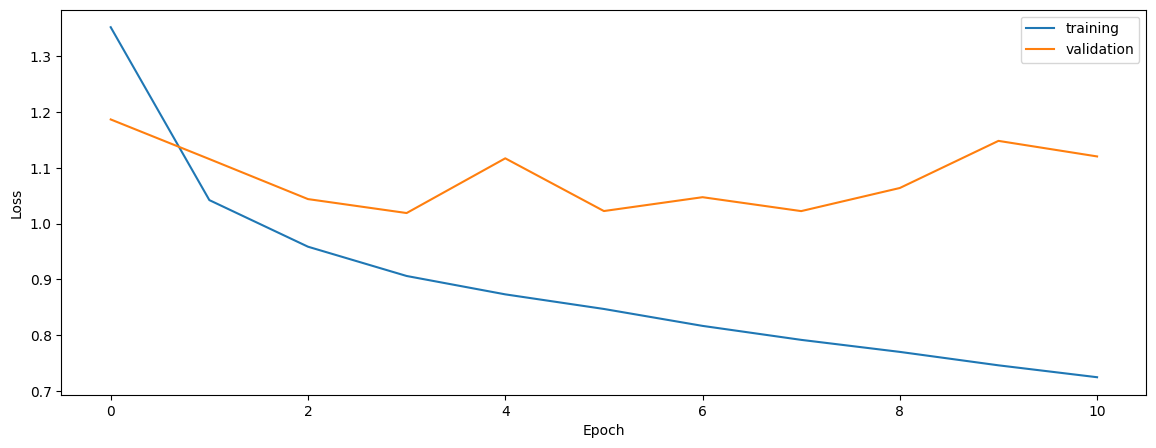

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
props1 = props
model1 = model

In [8]:
props = props.copy()
props['binarize'] = False
props['not_connected'] = False
props['collapse_max'] = True

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_1_0_0_1_1_t1t2_normalized_firstorder_TotalEnergy_firstorder_Minimum_firstorder_10Percentile_firstorder_Median_firstorder_InterquartileRange_firstorder_Range_firstorder_RobustMeanAbsoluteDeviation_firstorder_RootMeanSquared_firstorder_Skewness_firstorder_Kurtosis_firstorder_Variance_firstorder_Uniformity_glcm_JointAverage_glcm_ClusterProminence_glcm_ClusterShade_glcm_ClusterTendency_glcm_Contrast_glcm_Correlation_glcm_DifferenceAverage_glcm_DifferenceEntropy_glcm_DifferenceVariance_glcm_JointEnergy_glcm_JointEntropy_glcm_Imc2_glcm_Idm_glcm_MCC_glcm_Idmn_glcm_Id_glcm_Idn_glcm_InverseVariance_glcm_MaximumProbability_glcm_SumEntropy_glcm_SumSquares_glszm_SmallAreaEmphasis_glszm_LargeAreaEmphasis_glszm_GrayLevelNonUniformity_glszm_GrayLevelNonUniformityNormalized_glszm_SizeZoneNonUniformity_glszm_SizeZoneNonUniformityNormalized_glszm_ZonePercentage_glszm_GrayLevelVariance_glszm_ZoneVariance_glszm_ZoneEntropy_glszm_HighGrayLevelZoneEmphasis_glszm_Sma

In [9]:
gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(1068345, 828)
(1068345, 1)
validation
(123115, 828)
(123115, 1)
test
(152076, 828)
(152076, 1)


In [10]:
stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_2 (InputLayer)        [(None, 828)]             0         


 dense_5 (Dense)             (None, 1024)              848896    


 dense_6 (Dense)             (None, 512)               524800    


 dense_7 (Dense)             (None, 256)               131328    


 dense_8 (Dense)             (None, 128)               32896     


 dense_9 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [11]:
if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/107 [..............................] - ETA: 1:27 - loss: 0.2219 - STD: 4.1183e-04 - MAE: 0.4599

  5/107 [>.............................] - ETA: 1s - loss: 0.2279 - STD: 0.0014 - MAE: 0.4455      

  9/107 [=>............................] - ETA: 1s - loss: 0.2245 - STD: 0.0025 - MAE: 0.4456

 13/107 [==>...........................] - ETA: 1s - loss: 0.2227 - STD: 0.0035 - MAE: 0.4423

 17/107 [===>..........................] - ETA: 1s - loss: 0.2212 - STD: 0.0048 - MAE: 0.4443

 21/107 [====>.........................] - ETA: 1s - loss: 0.2201 - STD: 0.0064 - MAE: 0.4427

 25/107 [======>.......................] - ETA: 1s - loss: 0.2189 - STD: 0.0088 - MAE: 0.4417

 29/107 [=======>......................] - ETA: 2s - loss: 0.2176 - STD: 0.0126 - MAE: 0.4409

 33/107 [========>.....................] - ETA: 2s - loss: 0.2162 - STD: 0.0183 - MAE: 0.4387

 37/107 [=========>....................] - ETA: 2s - loss: 0.2146 - STD: 0.0265 - MAE: 0.4364

 41/107 [==========>...................] - ETA: 1s - loss: 0.2130 - STD: 0.0355 - MAE: 0.4333

 45/107 [===========>..................] - ETA: 1s - loss: 0.2115 - STD: 0.0438 - MAE: 0.4305

 49/107 [============>.................] - ETA: 1s - loss: 0.2100 - STD: 0.0504 - MAE: 0.4281

 53/107 [=============>................] - ETA: 1s - loss: 0.2087 - STD: 0.0574 - MAE: 0.4257

 57/107 [==============>...............] - ETA: 1s - loss: 0.2076 - STD: 0.0640 - MAE: 0.4233

 61/107 [================>.............] - ETA: 1s - loss: 0.2066 - STD: 0.0697 - MAE: 0.4214

 65/107 [=================>............] - ETA: 1s - loss: 0.2058 - STD: 0.0747 - MAE: 0.4195

 69/107 [==================>...........] - ETA: 0s - loss: 0.2050 - STD: 0.0794 - MAE: 0.4179

 73/107 [===================>..........] - ETA: 0s - loss: 0.2043 - STD: 0.0834 - MAE: 0.4165

 77/107 [====================>.........] - ETA: 0s - loss: 0.2036 - STD: 0.0872 - MAE: 0.4153

 81/107 [=====================>........] - ETA: 0s - loss: 0.2029 - STD: 0.0908 - MAE: 0.4138

 85/107 [======================>.......] - ETA: 0s - loss: 0.2023 - STD: 0.0941 - MAE: 0.4126

 89/107 [=======================>......] - ETA: 0s - loss: 0.2018 - STD: 0.0969 - MAE: 0.4115

 93/107 [=========================>....] - ETA: 0s - loss: 0.2012 - STD: 0.0997 - MAE: 0.4104

 97/107 [==========================>...] - ETA: 0s - loss: 0.2007 - STD: 0.1020 - MAE: 0.4095

101/107 [===========================>..] - ETA: 0s - loss: 0.2002 - STD: 0.1043 - MAE: 0.4086

105/107 [============================>.] - ETA: 0s - loss: 0.1997 - STD: 0.1064 - MAE: 0.4076

107/107 [==============================] - 4s 26ms/step - loss: 0.1995 - STD: 0.1074 - MAE: 0.4073 - val_loss: 0.1842 - val_STD: 0.1261 - val_MAE: 0.3875


Epoch 2/10000


  1/107 [..............................] - ETA: 4s - loss: 0.1870 - STD: 0.1538 - MAE: 0.3876

  5/107 [>.............................] - ETA: 1s - loss: 0.1847 - STD: 0.1579 - MAE: 0.3841

  9/107 [=>............................] - ETA: 1s - loss: 0.1840 - STD: 0.1634 - MAE: 0.3809

 13/107 [==>...........................] - ETA: 1s - loss: 0.1830 - STD: 0.1706 - MAE: 0.3779

 17/107 [===>..........................] - ETA: 1s - loss: 0.1819 - STD: 0.1752 - MAE: 0.3750

 21/107 [====>.........................] - ETA: 1s - loss: 0.1810 - STD: 0.1788 - MAE: 0.3733

 25/107 [======>.......................] - ETA: 1s - loss: 0.1806 - STD: 0.1808 - MAE: 0.3719

 29/107 [=======>......................] - ETA: 1s - loss: 0.1803 - STD: 0.1821 - MAE: 0.3711

 33/107 [========>.....................] - ETA: 1s - loss: 0.1799 - STD: 0.1831 - MAE: 0.3704

 37/107 [=========>....................] - ETA: 1s - loss: 0.1795 - STD: 0.1839 - MAE: 0.3698

 41/107 [==========>...................] - ETA: 0s - loss: 0.1792 - STD: 0.1852 - MAE: 0.3692

 45/107 [===========>..................] - ETA: 0s - loss: 0.1791 - STD: 0.1865 - MAE: 0.3687

 49/107 [============>.................] - ETA: 0s - loss: 0.1789 - STD: 0.1873 - MAE: 0.3682

 53/107 [=============>................] - ETA: 0s - loss: 0.1786 - STD: 0.1880 - MAE: 0.3677

 57/107 [==============>...............] - ETA: 0s - loss: 0.1783 - STD: 0.1888 - MAE: 0.3673

 61/107 [================>.............] - ETA: 0s - loss: 0.1781 - STD: 0.1899 - MAE: 0.3667

 65/107 [=================>............] - ETA: 0s - loss: 0.1777 - STD: 0.1907 - MAE: 0.3662

 69/107 [==================>...........] - ETA: 0s - loss: 0.1775 - STD: 0.1912 - MAE: 0.3658

 73/107 [===================>..........] - ETA: 0s - loss: 0.1773 - STD: 0.1917 - MAE: 0.3654

 77/107 [====================>.........] - ETA: 0s - loss: 0.1771 - STD: 0.1923 - MAE: 0.3650

 81/107 [=====================>........] - ETA: 0s - loss: 0.1769 - STD: 0.1928 - MAE: 0.3645

 85/107 [======================>.......] - ETA: 0s - loss: 0.1767 - STD: 0.1936 - MAE: 0.3642

 89/107 [=======================>......] - ETA: 0s - loss: 0.1764 - STD: 0.1942 - MAE: 0.3638

 93/107 [=========================>....] - ETA: 0s - loss: 0.1762 - STD: 0.1948 - MAE: 0.3634

 97/107 [==========================>...] - ETA: 0s - loss: 0.1761 - STD: 0.1954 - MAE: 0.3630

101/107 [===========================>..] - ETA: 0s - loss: 0.1760 - STD: 0.1959 - MAE: 0.3627

105/107 [============================>.] - ETA: 0s - loss: 0.1758 - STD: 0.1962 - MAE: 0.3625

107/107 [==============================] - 2s 17ms/step - loss: 0.1757 - STD: 0.1962 - MAE: 0.3624 - val_loss: 0.1685 - val_STD: 0.1813 - val_MAE: 0.3574


Epoch 3/10000


  1/107 [..............................] - ETA: 4s - loss: 0.1723 - STD: 0.2074 - MAE: 0.3600

  5/107 [>.............................] - ETA: 1s - loss: 0.1710 - STD: 0.2098 - MAE: 0.3543

  9/107 [=>............................] - ETA: 1s - loss: 0.1711 - STD: 0.2114 - MAE: 0.3533

 13/107 [==>...........................] - ETA: 1s - loss: 0.1711 - STD: 0.2128 - MAE: 0.3531

 17/107 [===>..........................] - ETA: 1s - loss: 0.1712 - STD: 0.2123 - MAE: 0.3524

 21/107 [====>.........................] - ETA: 1s - loss: 0.1712 - STD: 0.2113 - MAE: 0.3524

 25/107 [======>.......................] - ETA: 1s - loss: 0.1709 - STD: 0.2107 - MAE: 0.3525

 29/107 [=======>......................] - ETA: 1s - loss: 0.1708 - STD: 0.2100 - MAE: 0.3529

 33/107 [========>.....................] - ETA: 1s - loss: 0.1706 - STD: 0.2106 - MAE: 0.3526

 37/107 [=========>....................] - ETA: 1s - loss: 0.1703 - STD: 0.2118 - MAE: 0.3519

 41/107 [==========>...................] - ETA: 1s - loss: 0.1702 - STD: 0.2124 - MAE: 0.3515

 45/107 [===========>..................] - ETA: 0s - loss: 0.1699 - STD: 0.2128 - MAE: 0.3512

 49/107 [============>.................] - ETA: 0s - loss: 0.1699 - STD: 0.2132 - MAE: 0.3510

 53/107 [=============>................] - ETA: 0s - loss: 0.1697 - STD: 0.2134 - MAE: 0.3508

 57/107 [==============>...............] - ETA: 0s - loss: 0.1697 - STD: 0.2135 - MAE: 0.3507

 61/107 [================>.............] - ETA: 0s - loss: 0.1699 - STD: 0.2134 - MAE: 0.3507

 65/107 [=================>............] - ETA: 0s - loss: 0.1703 - STD: 0.2130 - MAE: 0.3508

 69/107 [==================>...........] - ETA: 0s - loss: 0.1705 - STD: 0.2122 - MAE: 0.3511

 73/107 [===================>..........] - ETA: 0s - loss: 0.1705 - STD: 0.2113 - MAE: 0.3515

 77/107 [====================>.........] - ETA: 0s - loss: 0.1705 - STD: 0.2109 - MAE: 0.3517

 81/107 [=====================>........] - ETA: 0s - loss: 0.1704 - STD: 0.2109 - MAE: 0.3517

 85/107 [======================>.......] - ETA: 0s - loss: 0.1703 - STD: 0.2112 - MAE: 0.3514

 89/107 [=======================>......] - ETA: 0s - loss: 0.1701 - STD: 0.2117 - MAE: 0.3511

 93/107 [=========================>....] - ETA: 0s - loss: 0.1700 - STD: 0.2123 - MAE: 0.3508

 97/107 [==========================>...] - ETA: 0s - loss: 0.1699 - STD: 0.2128 - MAE: 0.3505

101/107 [===========================>..] - ETA: 0s - loss: 0.1698 - STD: 0.2131 - MAE: 0.3504

105/107 [============================>.] - ETA: 0s - loss: 0.1697 - STD: 0.2131 - MAE: 0.3503

107/107 [==============================] - 2s 17ms/step - loss: 0.1697 - STD: 0.2131 - MAE: 0.3502 - val_loss: 0.1625 - val_STD: 0.1851 - val_MAE: 0.3453


Epoch 4/10000


  1/107 [..............................] - ETA: 5s - loss: 0.1658 - STD: 0.2128 - MAE: 0.3482

  5/107 [>.............................] - ETA: 1s - loss: 0.1673 - STD: 0.2172 - MAE: 0.3482

  9/107 [=>............................] - ETA: 1s - loss: 0.1665 - STD: 0.2187 - MAE: 0.3464

 13/107 [==>...........................] - ETA: 1s - loss: 0.1661 - STD: 0.2202 - MAE: 0.3453

 17/107 [===>..........................] - ETA: 1s - loss: 0.1659 - STD: 0.2215 - MAE: 0.3445

 21/107 [====>.........................] - ETA: 1s - loss: 0.1658 - STD: 0.2225 - MAE: 0.3438

 25/107 [======>.......................] - ETA: 1s - loss: 0.1658 - STD: 0.2224 - MAE: 0.3437

 29/107 [=======>......................] - ETA: 1s - loss: 0.1664 - STD: 0.2226 - MAE: 0.3442

 33/107 [========>.....................] - ETA: 1s - loss: 0.1667 - STD: 0.2218 - MAE: 0.3444

 37/107 [=========>....................] - ETA: 1s - loss: 0.1667 - STD: 0.2209 - MAE: 0.3447

 41/107 [==========>...................] - ETA: 1s - loss: 0.1667 - STD: 0.2202 - MAE: 0.3450

 45/107 [===========>..................] - ETA: 0s - loss: 0.1666 - STD: 0.2200 - MAE: 0.3450

 49/107 [============>.................] - ETA: 0s - loss: 0.1666 - STD: 0.2203 - MAE: 0.3449

 53/107 [=============>................] - ETA: 0s - loss: 0.1664 - STD: 0.2207 - MAE: 0.3445

 57/107 [==============>...............] - ETA: 0s - loss: 0.1664 - STD: 0.2212 - MAE: 0.3443

 61/107 [================>.............] - ETA: 0s - loss: 0.1661 - STD: 0.2217 - MAE: 0.3440

 65/107 [=================>............] - ETA: 0s - loss: 0.1660 - STD: 0.2221 - MAE: 0.3437

 69/107 [==================>...........] - ETA: 0s - loss: 0.1659 - STD: 0.2224 - MAE: 0.3435

 73/107 [===================>..........] - ETA: 0s - loss: 0.1657 - STD: 0.2226 - MAE: 0.3434

 77/107 [====================>.........] - ETA: 0s - loss: 0.1657 - STD: 0.2230 - MAE: 0.3432

 81/107 [=====================>........] - ETA: 0s - loss: 0.1657 - STD: 0.2233 - MAE: 0.3430

 85/107 [======================>.......] - ETA: 0s - loss: 0.1656 - STD: 0.2235 - MAE: 0.3430

 89/107 [=======================>......] - ETA: 0s - loss: 0.1656 - STD: 0.2234 - MAE: 0.3429

 93/107 [=========================>....] - ETA: 0s - loss: 0.1655 - STD: 0.2235 - MAE: 0.3427

 97/107 [==========================>...] - ETA: 0s - loss: 0.1654 - STD: 0.2236 - MAE: 0.3427

101/107 [===========================>..] - ETA: 0s - loss: 0.1654 - STD: 0.2237 - MAE: 0.3425

105/107 [============================>.] - ETA: 0s - loss: 0.1653 - STD: 0.2239 - MAE: 0.3423

107/107 [==============================] - 2s 17ms/step - loss: 0.1654 - STD: 0.2239 - MAE: 0.3423 - val_loss: 0.1596 - val_STD: 0.1913 - val_MAE: 0.3333


Epoch 5/10000


  1/107 [..............................] - ETA: 4s - loss: 0.1631 - STD: 0.2241 - MAE: 0.3364

  5/107 [>.............................] - ETA: 1s - loss: 0.1676 - STD: 0.2237 - MAE: 0.3432

  9/107 [=>............................] - ETA: 1s - loss: 0.1657 - STD: 0.2219 - MAE: 0.3425

 13/107 [==>...........................] - ETA: 1s - loss: 0.1646 - STD: 0.2213 - MAE: 0.3420

 17/107 [===>..........................] - ETA: 1s - loss: 0.1644 - STD: 0.2220 - MAE: 0.3417

 21/107 [====>.........................] - ETA: 1s - loss: 0.1641 - STD: 0.2240 - MAE: 0.3408

 25/107 [======>.......................] - ETA: 1s - loss: 0.1637 - STD: 0.2259 - MAE: 0.3398

 29/107 [=======>......................] - ETA: 1s - loss: 0.1633 - STD: 0.2269 - MAE: 0.3390

 33/107 [========>.....................] - ETA: 1s - loss: 0.1631 - STD: 0.2279 - MAE: 0.3386

 37/107 [=========>....................] - ETA: 1s - loss: 0.1631 - STD: 0.2288 - MAE: 0.3383

 41/107 [==========>...................] - ETA: 1s - loss: 0.1631 - STD: 0.2291 - MAE: 0.3382

 45/107 [===========>..................] - ETA: 0s - loss: 0.1631 - STD: 0.2294 - MAE: 0.3381

 49/107 [============>.................] - ETA: 0s - loss: 0.1630 - STD: 0.2291 - MAE: 0.3380

 53/107 [=============>................] - ETA: 0s - loss: 0.1630 - STD: 0.2291 - MAE: 0.3380

 57/107 [==============>...............] - ETA: 0s - loss: 0.1630 - STD: 0.2290 - MAE: 0.3379

 61/107 [================>.............] - ETA: 0s - loss: 0.1630 - STD: 0.2290 - MAE: 0.3379

 65/107 [=================>............] - ETA: 0s - loss: 0.1633 - STD: 0.2291 - MAE: 0.3381

 69/107 [==================>...........] - ETA: 0s - loss: 0.1636 - STD: 0.2287 - MAE: 0.3383

 73/107 [===================>..........] - ETA: 0s - loss: 0.1636 - STD: 0.2281 - MAE: 0.3384

 77/107 [====================>.........] - ETA: 0s - loss: 0.1636 - STD: 0.2277 - MAE: 0.3386

 81/107 [=====================>........] - ETA: 0s - loss: 0.1635 - STD: 0.2275 - MAE: 0.3386

 85/107 [======================>.......] - ETA: 0s - loss: 0.1635 - STD: 0.2277 - MAE: 0.3386

 89/107 [=======================>......] - ETA: 0s - loss: 0.1634 - STD: 0.2280 - MAE: 0.3384

 93/107 [=========================>....] - ETA: 0s - loss: 0.1633 - STD: 0.2284 - MAE: 0.3382

 97/107 [==========================>...] - ETA: 0s - loss: 0.1632 - STD: 0.2287 - MAE: 0.3380

101/107 [===========================>..] - ETA: 0s - loss: 0.1631 - STD: 0.2289 - MAE: 0.3378

105/107 [============================>.] - ETA: 0s - loss: 0.1630 - STD: 0.2292 - MAE: 0.3377

107/107 [==============================] - 2s 17ms/step - loss: 0.1630 - STD: 0.2293 - MAE: 0.3376 - val_loss: 0.1601 - val_STD: 0.1898 - val_MAE: 0.3265


Epoch 6/10000


  1/107 [..............................] - ETA: 4s - loss: 0.1642 - STD: 0.2218 - MAE: 0.3326

  5/107 [>.............................] - ETA: 1s - loss: 0.1633 - STD: 0.2311 - MAE: 0.3339

  9/107 [=>............................] - ETA: 1s - loss: 0.1647 - STD: 0.2315 - MAE: 0.3362

 13/107 [==>...........................] - ETA: 1s - loss: 0.1642 - STD: 0.2290 - MAE: 0.3365

 17/107 [===>..........................] - ETA: 1s - loss: 0.1641 - STD: 0.2282 - MAE: 0.3373

 20/107 [====>.........................] - ETA: 1s - loss: 0.1640 - STD: 0.2277 - MAE: 0.3378

 24/107 [=====>........................] - ETA: 1s - loss: 0.1640 - STD: 0.2269 - MAE: 0.3382

 28/107 [======>.......................] - ETA: 1s - loss: 0.1637 - STD: 0.2271 - MAE: 0.3379

 32/107 [=======>......................] - ETA: 1s - loss: 0.1634 - STD: 0.2275 - MAE: 0.3374

 36/107 [=========>....................] - ETA: 1s - loss: 0.1630 - STD: 0.2286 - MAE: 0.3368

 40/107 [==========>...................] - ETA: 1s - loss: 0.1629 - STD: 0.2293 - MAE: 0.3366

 44/107 [===========>..................] - ETA: 0s - loss: 0.1627 - STD: 0.2295 - MAE: 0.3365

 48/107 [============>.................] - ETA: 0s - loss: 0.1624 - STD: 0.2302 - MAE: 0.3360

 52/107 [=============>................] - ETA: 0s - loss: 0.1621 - STD: 0.2307 - MAE: 0.3356

 56/107 [==============>...............] - ETA: 0s - loss: 0.1620 - STD: 0.2310 - MAE: 0.3355

 60/107 [===============>..............] - ETA: 0s - loss: 0.1619 - STD: 0.2317 - MAE: 0.3352

 64/107 [================>.............] - ETA: 0s - loss: 0.1618 - STD: 0.2320 - MAE: 0.3350

 68/107 [==================>...........] - ETA: 0s - loss: 0.1617 - STD: 0.2323 - MAE: 0.3348

 72/107 [===================>..........] - ETA: 0s - loss: 0.1615 - STD: 0.2326 - MAE: 0.3346

 76/107 [====================>.........] - ETA: 0s - loss: 0.1614 - STD: 0.2329 - MAE: 0.3344

 80/107 [=====================>........] - ETA: 0s - loss: 0.1613 - STD: 0.2332 - MAE: 0.3343

 84/107 [======================>.......] - ETA: 0s - loss: 0.1612 - STD: 0.2335 - MAE: 0.3342

 88/107 [=======================>......] - ETA: 0s - loss: 0.1611 - STD: 0.2339 - MAE: 0.3340

 92/107 [========================>.....] - ETA: 0s - loss: 0.1610 - STD: 0.2342 - MAE: 0.3337

 96/107 [=========================>....] - ETA: 0s - loss: 0.1609 - STD: 0.2344 - MAE: 0.3336

100/107 [===========================>..] - ETA: 0s - loss: 0.1609 - STD: 0.2347 - MAE: 0.3335

104/107 [============================>.] - ETA: 0s - loss: 0.1609 - STD: 0.2347 - MAE: 0.3334

107/107 [==============================] - 2s 17ms/step - loss: 0.1609 - STD: 0.2347 - MAE: 0.3334 - val_loss: 0.1564 - val_STD: 0.2070 - val_MAE: 0.3313


Epoch 7/10000


  1/107 [..............................] - ETA: 4s - loss: 0.1591 - STD: 0.2390 - MAE: 0.3334

  5/107 [>.............................] - ETA: 1s - loss: 0.1657 - STD: 0.2331 - MAE: 0.3385

  9/107 [=>............................] - ETA: 1s - loss: 0.1689 - STD: 0.2276 - MAE: 0.3401

 13/107 [==>...........................] - ETA: 1s - loss: 0.1678 - STD: 0.2230 - MAE: 0.3408

 17/107 [===>..........................] - ETA: 1s - loss: 0.1668 - STD: 0.2195 - MAE: 0.3421

 21/107 [====>.........................] - ETA: 1s - loss: 0.1655 - STD: 0.2202 - MAE: 0.3413

 25/107 [======>.......................] - ETA: 1s - loss: 0.1648 - STD: 0.2223 - MAE: 0.3402

 29/107 [=======>......................] - ETA: 1s - loss: 0.1638 - STD: 0.2250 - MAE: 0.3386

 33/107 [========>.....................] - ETA: 1s - loss: 0.1633 - STD: 0.2276 - MAE: 0.3371

 37/107 [=========>....................] - ETA: 1s - loss: 0.1628 - STD: 0.2296 - MAE: 0.3360

 41/107 [==========>...................] - ETA: 1s - loss: 0.1623 - STD: 0.2307 - MAE: 0.3352

 45/107 [===========>..................] - ETA: 0s - loss: 0.1619 - STD: 0.2316 - MAE: 0.3347

 49/107 [============>.................] - ETA: 0s - loss: 0.1618 - STD: 0.2320 - MAE: 0.3345

 53/107 [=============>................] - ETA: 0s - loss: 0.1616 - STD: 0.2324 - MAE: 0.3342

 57/107 [==============>...............] - ETA: 0s - loss: 0.1614 - STD: 0.2331 - MAE: 0.3339

 61/107 [================>.............] - ETA: 0s - loss: 0.1612 - STD: 0.2335 - MAE: 0.3336

 65/107 [=================>............] - ETA: 0s - loss: 0.1611 - STD: 0.2338 - MAE: 0.3335

 69/107 [==================>...........] - ETA: 0s - loss: 0.1610 - STD: 0.2342 - MAE: 0.3332

 73/107 [===================>..........] - ETA: 0s - loss: 0.1610 - STD: 0.2345 - MAE: 0.3332

 77/107 [====================>.........] - ETA: 0s - loss: 0.1612 - STD: 0.2343 - MAE: 0.3332

 81/107 [=====================>........] - ETA: 0s - loss: 0.1613 - STD: 0.2341 - MAE: 0.3332

 85/107 [======================>.......] - ETA: 0s - loss: 0.1615 - STD: 0.2334 - MAE: 0.3335

 89/107 [=======================>......] - ETA: 0s - loss: 0.1615 - STD: 0.2331 - MAE: 0.3336

 93/107 [=========================>....] - ETA: 0s - loss: 0.1614 - STD: 0.2330 - MAE: 0.3337

 97/107 [==========================>...] - ETA: 0s - loss: 0.1613 - STD: 0.2329 - MAE: 0.3337

101/107 [===========================>..] - ETA: 0s - loss: 0.1612 - STD: 0.2331 - MAE: 0.3335

105/107 [============================>.] - ETA: 0s - loss: 0.1611 - STD: 0.2335 - MAE: 0.3333

107/107 [==============================] - 2s 17ms/step - loss: 0.1610 - STD: 0.2336 - MAE: 0.3332 - val_loss: 0.1552 - val_STD: 0.2152 - val_MAE: 0.3271


Epoch 8/10000


  1/107 [..............................] - ETA: 5s - loss: 0.1561 - STD: 0.2492 - MAE: 0.3262

  5/107 [>.............................] - ETA: 1s - loss: 0.1583 - STD: 0.2450 - MAE: 0.3281

  9/107 [=>............................] - ETA: 1s - loss: 0.1579 - STD: 0.2440 - MAE: 0.3278

 13/107 [==>...........................] - ETA: 1s - loss: 0.1579 - STD: 0.2433 - MAE: 0.3281

 17/107 [===>..........................] - ETA: 1s - loss: 0.1575 - STD: 0.2434 - MAE: 0.3277

 21/107 [====>.........................] - ETA: 1s - loss: 0.1575 - STD: 0.2438 - MAE: 0.3274

 25/107 [======>.......................] - ETA: 1s - loss: 0.1576 - STD: 0.2433 - MAE: 0.3274

 29/107 [=======>......................] - ETA: 1s - loss: 0.1575 - STD: 0.2434 - MAE: 0.3272

 33/107 [========>.....................] - ETA: 1s - loss: 0.1576 - STD: 0.2432 - MAE: 0.3274

 37/107 [=========>....................] - ETA: 1s - loss: 0.1580 - STD: 0.2426 - MAE: 0.3275

 41/107 [==========>...................] - ETA: 1s - loss: 0.1583 - STD: 0.2421 - MAE: 0.3277

 45/107 [===========>..................] - ETA: 0s - loss: 0.1582 - STD: 0.2418 - MAE: 0.3278

 49/107 [============>.................] - ETA: 0s - loss: 0.1582 - STD: 0.2412 - MAE: 0.3280

 53/107 [=============>................] - ETA: 0s - loss: 0.1583 - STD: 0.2411 - MAE: 0.3283

 57/107 [==============>...............] - ETA: 0s - loss: 0.1584 - STD: 0.2409 - MAE: 0.3285

 61/107 [================>.............] - ETA: 0s - loss: 0.1584 - STD: 0.2408 - MAE: 0.3284

 65/107 [=================>............] - ETA: 0s - loss: 0.1583 - STD: 0.2407 - MAE: 0.3284

 69/107 [==================>...........] - ETA: 0s - loss: 0.1581 - STD: 0.2408 - MAE: 0.3282

 73/107 [===================>..........] - ETA: 0s - loss: 0.1581 - STD: 0.2411 - MAE: 0.3282

 77/107 [====================>.........] - ETA: 0s - loss: 0.1581 - STD: 0.2413 - MAE: 0.3281

 81/107 [=====================>........] - ETA: 0s - loss: 0.1579 - STD: 0.2415 - MAE: 0.3279

 85/107 [======================>.......] - ETA: 0s - loss: 0.1580 - STD: 0.2416 - MAE: 0.3279

 89/107 [=======================>......] - ETA: 0s - loss: 0.1581 - STD: 0.2416 - MAE: 0.3279

 93/107 [=========================>....] - ETA: 0s - loss: 0.1587 - STD: 0.2412 - MAE: 0.3284

 97/107 [==========================>...] - ETA: 0s - loss: 0.1590 - STD: 0.2408 - MAE: 0.3288

101/107 [===========================>..] - ETA: 0s - loss: 0.1591 - STD: 0.2397 - MAE: 0.3292

105/107 [============================>.] - ETA: 0s - loss: 0.1593 - STD: 0.2389 - MAE: 0.3296

107/107 [==============================] - 2s 17ms/step - loss: 0.1594 - STD: 0.2385 - MAE: 0.3297 - val_loss: 0.1560 - val_STD: 0.1875 - val_MAE: 0.3307


Epoch 9/10000


  1/107 [..............................] - ETA: 5s - loss: 0.1594 - STD: 0.2230 - MAE: 0.3343

  4/107 [>.............................] - ETA: 1s - loss: 0.1602 - STD: 0.2262 - MAE: 0.3359

  8/107 [=>............................] - ETA: 1s - loss: 0.1596 - STD: 0.2290 - MAE: 0.3337

 12/107 [==>...........................] - ETA: 1s - loss: 0.1596 - STD: 0.2338 - MAE: 0.3317

 16/107 [===>..........................] - ETA: 1s - loss: 0.1593 - STD: 0.2355 - MAE: 0.3306

 20/107 [====>.........................] - ETA: 1s - loss: 0.1589 - STD: 0.2364 - MAE: 0.3298

 24/107 [=====>........................] - ETA: 1s - loss: 0.1589 - STD: 0.2375 - MAE: 0.3296

 28/107 [======>.......................] - ETA: 1s - loss: 0.1588 - STD: 0.2377 - MAE: 0.3297

 32/107 [=======>......................] - ETA: 1s - loss: 0.1587 - STD: 0.2380 - MAE: 0.3296

 36/107 [=========>....................] - ETA: 1s - loss: 0.1586 - STD: 0.2383 - MAE: 0.3295

 40/107 [==========>...................] - ETA: 1s - loss: 0.1585 - STD: 0.2386 - MAE: 0.3295

 44/107 [===========>..................] - ETA: 0s - loss: 0.1583 - STD: 0.2390 - MAE: 0.3292

 48/107 [============>.................] - ETA: 0s - loss: 0.1580 - STD: 0.2395 - MAE: 0.3287

 52/107 [=============>................] - ETA: 0s - loss: 0.1578 - STD: 0.2399 - MAE: 0.3283

 56/107 [==============>...............] - ETA: 0s - loss: 0.1577 - STD: 0.2407 - MAE: 0.3279

 60/107 [===============>..............] - ETA: 0s - loss: 0.1577 - STD: 0.2412 - MAE: 0.3277

 64/107 [================>.............] - ETA: 0s - loss: 0.1575 - STD: 0.2415 - MAE: 0.3275

 68/107 [==================>...........] - ETA: 0s - loss: 0.1575 - STD: 0.2416 - MAE: 0.3273

 72/107 [===================>..........] - ETA: 0s - loss: 0.1574 - STD: 0.2417 - MAE: 0.3272

 76/107 [====================>.........] - ETA: 0s - loss: 0.1573 - STD: 0.2420 - MAE: 0.3270

 80/107 [=====================>........] - ETA: 0s - loss: 0.1572 - STD: 0.2423 - MAE: 0.3269

 84/107 [======================>.......] - ETA: 0s - loss: 0.1571 - STD: 0.2423 - MAE: 0.3268

 88/107 [=======================>......] - ETA: 0s - loss: 0.1571 - STD: 0.2425 - MAE: 0.3267

 92/107 [========================>.....] - ETA: 0s - loss: 0.1570 - STD: 0.2425 - MAE: 0.3266

 96/107 [=========================>....] - ETA: 0s - loss: 0.1569 - STD: 0.2428 - MAE: 0.3264

100/107 [===========================>..] - ETA: 0s - loss: 0.1569 - STD: 0.2430 - MAE: 0.3263

104/107 [============================>.] - ETA: 0s - loss: 0.1568 - STD: 0.2432 - MAE: 0.3262

107/107 [==============================] - 2s 17ms/step - loss: 0.1568 - STD: 0.2433 - MAE: 0.3261 - val_loss: 0.1528 - val_STD: 0.2168 - val_MAE: 0.3218


Epoch 10/10000


  1/107 [..............................] - ETA: 5s - loss: 0.1554 - STD: 0.2489 - MAE: 0.3232

  5/107 [>.............................] - ETA: 1s - loss: 0.1547 - STD: 0.2469 - MAE: 0.3225

  9/107 [=>............................] - ETA: 1s - loss: 0.1548 - STD: 0.2484 - MAE: 0.3225

 13/107 [==>...........................] - ETA: 1s - loss: 0.1549 - STD: 0.2484 - MAE: 0.3226

 17/107 [===>..........................] - ETA: 1s - loss: 0.1551 - STD: 0.2481 - MAE: 0.3229

 21/107 [====>.........................] - ETA: 1s - loss: 0.1550 - STD: 0.2480 - MAE: 0.3229

 25/107 [======>.......................] - ETA: 1s - loss: 0.1552 - STD: 0.2481 - MAE: 0.3231

 29/107 [=======>......................] - ETA: 1s - loss: 0.1563 - STD: 0.2471 - MAE: 0.3235

 33/107 [========>.....................] - ETA: 1s - loss: 0.1580 - STD: 0.2455 - MAE: 0.3246

 37/107 [=========>....................] - ETA: 1s - loss: 0.1582 - STD: 0.2437 - MAE: 0.3256

 41/107 [==========>...................] - ETA: 1s - loss: 0.1583 - STD: 0.2415 - MAE: 0.3266

 45/107 [===========>..................] - ETA: 0s - loss: 0.1584 - STD: 0.2405 - MAE: 0.3272

 49/107 [============>.................] - ETA: 0s - loss: 0.1582 - STD: 0.2401 - MAE: 0.3273

 53/107 [=============>................] - ETA: 0s - loss: 0.1581 - STD: 0.2402 - MAE: 0.3272

 57/107 [==============>...............] - ETA: 0s - loss: 0.1579 - STD: 0.2408 - MAE: 0.3268

 61/107 [================>.............] - ETA: 0s - loss: 0.1577 - STD: 0.2414 - MAE: 0.3265

 65/107 [=================>............] - ETA: 0s - loss: 0.1576 - STD: 0.2419 - MAE: 0.3263

 69/107 [==================>...........] - ETA: 0s - loss: 0.1575 - STD: 0.2421 - MAE: 0.3262

 73/107 [===================>..........] - ETA: 0s - loss: 0.1573 - STD: 0.2422 - MAE: 0.3259

 77/107 [====================>.........] - ETA: 0s - loss: 0.1572 - STD: 0.2424 - MAE: 0.3258

 81/107 [=====================>........] - ETA: 0s - loss: 0.1571 - STD: 0.2427 - MAE: 0.3257

 85/107 [======================>.......] - ETA: 0s - loss: 0.1569 - STD: 0.2430 - MAE: 0.3255

 89/107 [=======================>......] - ETA: 0s - loss: 0.1568 - STD: 0.2433 - MAE: 0.3253

 93/107 [=========================>....] - ETA: 0s - loss: 0.1568 - STD: 0.2436 - MAE: 0.3251

 97/107 [==========================>...] - ETA: 0s - loss: 0.1568 - STD: 0.2438 - MAE: 0.3251

101/107 [===========================>..] - ETA: 0s - loss: 0.1568 - STD: 0.2440 - MAE: 0.3250

105/107 [============================>.] - ETA: 0s - loss: 0.1569 - STD: 0.2439 - MAE: 0.3251

107/107 [==============================] - 2s 17ms/step - loss: 0.1569 - STD: 0.2440 - MAE: 0.3251 - val_loss: 0.1547 - val_STD: 0.1998 - val_MAE: 0.3193


Epoch 11/10000


  1/107 [..............................] - ETA: 4s - loss: 0.1583 - STD: 0.2382 - MAE: 0.3233

  4/107 [>.............................] - ETA: 1s - loss: 0.1554 - STD: 0.2412 - MAE: 0.3240

  8/107 [=>............................] - ETA: 1s - loss: 0.1550 - STD: 0.2401 - MAE: 0.3239

 12/107 [==>...........................] - ETA: 1s - loss: 0.1555 - STD: 0.2425 - MAE: 0.3243

 16/107 [===>..........................] - ETA: 1s - loss: 0.1551 - STD: 0.2440 - MAE: 0.3237

 20/107 [====>.........................] - ETA: 1s - loss: 0.1546 - STD: 0.2446 - MAE: 0.3230

 24/107 [=====>........................] - ETA: 1s - loss: 0.1546 - STD: 0.2453 - MAE: 0.3227

 28/107 [======>.......................] - ETA: 1s - loss: 0.1547 - STD: 0.2459 - MAE: 0.3227

 32/107 [=======>......................] - ETA: 1s - loss: 0.1544 - STD: 0.2470 - MAE: 0.3221

 36/107 [=========>....................] - ETA: 1s - loss: 0.1542 - STD: 0.2475 - MAE: 0.3217

 40/107 [==========>...................] - ETA: 1s - loss: 0.1541 - STD: 0.2479 - MAE: 0.3216

 44/107 [===========>..................] - ETA: 0s - loss: 0.1543 - STD: 0.2479 - MAE: 0.3217

 48/107 [============>.................] - ETA: 0s - loss: 0.1542 - STD: 0.2480 - MAE: 0.3216

 52/107 [=============>................] - ETA: 0s - loss: 0.1541 - STD: 0.2481 - MAE: 0.3215

 56/107 [==============>...............] - ETA: 0s - loss: 0.1542 - STD: 0.2482 - MAE: 0.3215

 60/107 [===============>..............] - ETA: 0s - loss: 0.1541 - STD: 0.2486 - MAE: 0.3213

 64/107 [================>.............] - ETA: 0s - loss: 0.1542 - STD: 0.2487 - MAE: 0.3212

 68/107 [==================>...........] - ETA: 0s - loss: 0.1542 - STD: 0.2487 - MAE: 0.3212

 72/107 [===================>..........] - ETA: 0s - loss: 0.1545 - STD: 0.2488 - MAE: 0.3214

 76/107 [====================>.........] - ETA: 0s - loss: 0.1551 - STD: 0.2480 - MAE: 0.3219

 80/107 [=====================>........] - ETA: 0s - loss: 0.1556 - STD: 0.2473 - MAE: 0.3224

 84/107 [======================>.......] - ETA: 0s - loss: 0.1561 - STD: 0.2460 - MAE: 0.3233

 88/107 [=======================>......] - ETA: 0s - loss: 0.1563 - STD: 0.2447 - MAE: 0.3240

 92/107 [========================>.....] - ETA: 0s - loss: 0.1563 - STD: 0.2443 - MAE: 0.3242

 96/107 [=========================>....] - ETA: 0s - loss: 0.1564 - STD: 0.2441 - MAE: 0.3244

100/107 [===========================>..] - ETA: 0s - loss: 0.1564 - STD: 0.2441 - MAE: 0.3243

104/107 [============================>.] - ETA: 0s - loss: 0.1563 - STD: 0.2445 - MAE: 0.3241

107/107 [==============================] - 2s 17ms/step - loss: 0.1563 - STD: 0.2447 - MAE: 0.3240 - val_loss: 0.1522 - val_STD: 0.2030 - val_MAE: 0.3177


Epoch 12/10000


  1/107 [..............................] - ETA: 4s - loss: 0.1542 - STD: 0.2408 - MAE: 0.3207

  5/107 [>.............................] - ETA: 1s - loss: 0.1546 - STD: 0.2468 - MAE: 0.3214

  9/107 [=>............................] - ETA: 1s - loss: 0.1545 - STD: 0.2464 - MAE: 0.3220

 13/107 [==>...........................] - ETA: 1s - loss: 0.1544 - STD: 0.2470 - MAE: 0.3219

 17/107 [===>..........................] - ETA: 1s - loss: 0.1547 - STD: 0.2471 - MAE: 0.3224

 21/107 [====>.........................] - ETA: 1s - loss: 0.1543 - STD: 0.2469 - MAE: 0.3220

 25/107 [======>.......................] - ETA: 1s - loss: 0.1541 - STD: 0.2479 - MAE: 0.3215

 29/107 [=======>......................] - ETA: 1s - loss: 0.1541 - STD: 0.2482 - MAE: 0.3214

 33/107 [========>.....................] - ETA: 1s - loss: 0.1540 - STD: 0.2488 - MAE: 0.3212

 37/107 [=========>....................] - ETA: 1s - loss: 0.1542 - STD: 0.2491 - MAE: 0.3211

 41/107 [==========>...................] - ETA: 0s - loss: 0.1543 - STD: 0.2491 - MAE: 0.3211

 45/107 [===========>..................] - ETA: 0s - loss: 0.1545 - STD: 0.2491 - MAE: 0.3212

 49/107 [============>.................] - ETA: 0s - loss: 0.1544 - STD: 0.2487 - MAE: 0.3212

 53/107 [=============>................] - ETA: 0s - loss: 0.1544 - STD: 0.2485 - MAE: 0.3214

 57/107 [==============>...............] - ETA: 0s - loss: 0.1543 - STD: 0.2483 - MAE: 0.3213

 61/107 [================>.............] - ETA: 0s - loss: 0.1544 - STD: 0.2486 - MAE: 0.3214

 65/107 [=================>............] - ETA: 0s - loss: 0.1545 - STD: 0.2486 - MAE: 0.3214

 69/107 [==================>...........] - ETA: 0s - loss: 0.1546 - STD: 0.2485 - MAE: 0.3213

 73/107 [===================>..........] - ETA: 0s - loss: 0.1545 - STD: 0.2484 - MAE: 0.3213

 77/107 [====================>.........] - ETA: 0s - loss: 0.1544 - STD: 0.2485 - MAE: 0.3213

 81/107 [=====================>........] - ETA: 0s - loss: 0.1544 - STD: 0.2485 - MAE: 0.3212

 85/107 [======================>.......] - ETA: 0s - loss: 0.1544 - STD: 0.2485 - MAE: 0.3211

 89/107 [=======================>......] - ETA: 0s - loss: 0.1544 - STD: 0.2487 - MAE: 0.3210

 93/107 [=========================>....] - ETA: 0s - loss: 0.1543 - STD: 0.2488 - MAE: 0.3210

 97/107 [==========================>...] - ETA: 0s - loss: 0.1543 - STD: 0.2487 - MAE: 0.3209

101/107 [===========================>..] - ETA: 0s - loss: 0.1543 - STD: 0.2486 - MAE: 0.3209

105/107 [============================>.] - ETA: 0s - loss: 0.1542 - STD: 0.2487 - MAE: 0.3208

107/107 [==============================] - 2s 17ms/step - loss: 0.1542 - STD: 0.2487 - MAE: 0.3208 - val_loss: 0.1511 - val_STD: 0.2064 - val_MAE: 0.3175


Epoch 13/10000


  1/107 [..............................] - ETA: 4s - loss: 0.1532 - STD: 0.2449 - MAE: 0.3185

  5/107 [>.............................] - ETA: 1s - loss: 0.1526 - STD: 0.2470 - MAE: 0.3199

  9/107 [=>............................] - ETA: 1s - loss: 0.1526 - STD: 0.2489 - MAE: 0.3191

 13/107 [==>...........................] - ETA: 1s - loss: 0.1529 - STD: 0.2504 - MAE: 0.3187

 17/107 [===>..........................] - ETA: 1s - loss: 0.1533 - STD: 0.2499 - MAE: 0.3189

 21/107 [====>.........................] - ETA: 1s - loss: 0.1531 - STD: 0.2504 - MAE: 0.3186

 25/107 [======>.......................] - ETA: 1s - loss: 0.1538 - STD: 0.2502 - MAE: 0.3195

 29/107 [=======>......................] - ETA: 1s - loss: 0.1542 - STD: 0.2496 - MAE: 0.3197

 33/107 [========>.....................] - ETA: 1s - loss: 0.1543 - STD: 0.2485 - MAE: 0.3203

 37/107 [=========>....................] - ETA: 1s - loss: 0.1542 - STD: 0.2480 - MAE: 0.3204

 41/107 [==========>...................] - ETA: 0s - loss: 0.1539 - STD: 0.2484 - MAE: 0.3202

 45/107 [===========>..................] - ETA: 0s - loss: 0.1538 - STD: 0.2486 - MAE: 0.3200

 49/107 [============>.................] - ETA: 0s - loss: 0.1537 - STD: 0.2492 - MAE: 0.3198

 53/107 [=============>................] - ETA: 0s - loss: 0.1538 - STD: 0.2492 - MAE: 0.3197

 57/107 [==============>...............] - ETA: 0s - loss: 0.1538 - STD: 0.2489 - MAE: 0.3197

 61/107 [================>.............] - ETA: 0s - loss: 0.1538 - STD: 0.2490 - MAE: 0.3198

 65/107 [=================>............] - ETA: 0s - loss: 0.1538 - STD: 0.2490 - MAE: 0.3198

 69/107 [==================>...........] - ETA: 0s - loss: 0.1538 - STD: 0.2493 - MAE: 0.3196

 73/107 [===================>..........] - ETA: 0s - loss: 0.1537 - STD: 0.2494 - MAE: 0.3195

 77/107 [====================>.........] - ETA: 0s - loss: 0.1535 - STD: 0.2497 - MAE: 0.3192

 81/107 [=====================>........] - ETA: 0s - loss: 0.1534 - STD: 0.2498 - MAE: 0.3192

 85/107 [======================>.......] - ETA: 0s - loss: 0.1533 - STD: 0.2500 - MAE: 0.3190

 89/107 [=======================>......] - ETA: 0s - loss: 0.1534 - STD: 0.2501 - MAE: 0.3190

 93/107 [=========================>....] - ETA: 0s - loss: 0.1534 - STD: 0.2501 - MAE: 0.3191

 97/107 [==========================>...] - ETA: 0s - loss: 0.1533 - STD: 0.2501 - MAE: 0.3189

101/107 [===========================>..] - ETA: 0s - loss: 0.1532 - STD: 0.2502 - MAE: 0.3188

105/107 [============================>.] - ETA: 0s - loss: 0.1532 - STD: 0.2503 - MAE: 0.3188

107/107 [==============================] - 2s 17ms/step - loss: 0.1532 - STD: 0.2503 - MAE: 0.3188 - val_loss: 0.1518 - val_STD: 0.2212 - val_MAE: 0.3202


Epoch 14/10000


  1/107 [..............................] - ETA: 5s - loss: 0.1532 - STD: 0.2574 - MAE: 0.3189

  5/107 [>.............................] - ETA: 1s - loss: 0.1523 - STD: 0.2511 - MAE: 0.3181

  9/107 [=>............................] - ETA: 1s - loss: 0.1519 - STD: 0.2520 - MAE: 0.3172

 13/107 [==>...........................] - ETA: 1s - loss: 0.1516 - STD: 0.2515 - MAE: 0.3170

 17/107 [===>..........................] - ETA: 1s - loss: 0.1515 - STD: 0.2535 - MAE: 0.3163

 21/107 [====>.........................] - ETA: 1s - loss: 0.1512 - STD: 0.2538 - MAE: 0.3155

 25/107 [======>.......................] - ETA: 1s - loss: 0.1513 - STD: 0.2539 - MAE: 0.3156

 29/107 [=======>......................] - ETA: 1s - loss: 0.1516 - STD: 0.2533 - MAE: 0.3160

 33/107 [========>.....................] - ETA: 1s - loss: 0.1517 - STD: 0.2532 - MAE: 0.3159

 37/107 [=========>....................] - ETA: 1s - loss: 0.1516 - STD: 0.2533 - MAE: 0.3158

 41/107 [==========>...................] - ETA: 1s - loss: 0.1515 - STD: 0.2534 - MAE: 0.3157

 45/107 [===========>..................] - ETA: 0s - loss: 0.1515 - STD: 0.2534 - MAE: 0.3158

 49/107 [============>.................] - ETA: 0s - loss: 0.1515 - STD: 0.2535 - MAE: 0.3156

 53/107 [=============>................] - ETA: 0s - loss: 0.1514 - STD: 0.2537 - MAE: 0.3155

 57/107 [==============>...............] - ETA: 0s - loss: 0.1513 - STD: 0.2536 - MAE: 0.3155

 61/107 [================>.............] - ETA: 0s - loss: 0.1513 - STD: 0.2538 - MAE: 0.3154

 65/107 [=================>............] - ETA: 0s - loss: 0.1512 - STD: 0.2540 - MAE: 0.3152

 69/107 [==================>...........] - ETA: 0s - loss: 0.1511 - STD: 0.2540 - MAE: 0.3151

 73/107 [===================>..........] - ETA: 0s - loss: 0.1511 - STD: 0.2541 - MAE: 0.3151

 77/107 [====================>.........] - ETA: 0s - loss: 0.1510 - STD: 0.2543 - MAE: 0.3150

 81/107 [=====================>........] - ETA: 0s - loss: 0.1511 - STD: 0.2542 - MAE: 0.3150

 85/107 [======================>.......] - ETA: 0s - loss: 0.1511 - STD: 0.2543 - MAE: 0.3149

 89/107 [=======================>......] - ETA: 0s - loss: 0.1512 - STD: 0.2543 - MAE: 0.3149

 93/107 [=========================>....] - ETA: 0s - loss: 0.1513 - STD: 0.2541 - MAE: 0.3151

 97/107 [==========================>...] - ETA: 0s - loss: 0.1516 - STD: 0.2535 - MAE: 0.3153

101/107 [===========================>..] - ETA: 0s - loss: 0.1523 - STD: 0.2528 - MAE: 0.3158

105/107 [============================>.] - ETA: 0s - loss: 0.1527 - STD: 0.2521 - MAE: 0.3163

107/107 [==============================] - 2s 17ms/step - loss: 0.1527 - STD: 0.2521 - MAE: 0.3165 - val_loss: 0.1590 - val_STD: 0.1806 - val_MAE: 0.3189


Epoch 15/10000


  1/107 [..............................] - ETA: 4s - loss: 0.1622 - STD: 0.2234 - MAE: 0.3238

  5/107 [>.............................] - ETA: 1s - loss: 0.1580 - STD: 0.2346 - MAE: 0.3236

  9/107 [=>............................] - ETA: 1s - loss: 0.1574 - STD: 0.2349 - MAE: 0.3248

 13/107 [==>...........................] - ETA: 1s - loss: 0.1564 - STD: 0.2365 - MAE: 0.3244

 17/107 [===>..........................] - ETA: 1s - loss: 0.1555 - STD: 0.2397 - MAE: 0.3228

 21/107 [====>.........................] - ETA: 1s - loss: 0.1546 - STD: 0.2415 - MAE: 0.3216

 25/107 [======>.......................] - ETA: 1s - loss: 0.1540 - STD: 0.2426 - MAE: 0.3210

 29/107 [=======>......................] - ETA: 1s - loss: 0.1534 - STD: 0.2435 - MAE: 0.3203

 33/107 [========>.....................] - ETA: 1s - loss: 0.1531 - STD: 0.2445 - MAE: 0.3197

 37/107 [=========>....................] - ETA: 1s - loss: 0.1528 - STD: 0.2455 - MAE: 0.3190

 41/107 [==========>...................] - ETA: 1s - loss: 0.1525 - STD: 0.2465 - MAE: 0.3185

 45/107 [===========>..................] - ETA: 0s - loss: 0.1522 - STD: 0.2475 - MAE: 0.3179

 49/107 [============>.................] - ETA: 0s - loss: 0.1520 - STD: 0.2485 - MAE: 0.3172

 53/107 [=============>................] - ETA: 0s - loss: 0.1518 - STD: 0.2490 - MAE: 0.3169

 57/107 [==============>...............] - ETA: 0s - loss: 0.1517 - STD: 0.2497 - MAE: 0.3166

 61/107 [================>.............] - ETA: 0s - loss: 0.1515 - STD: 0.2501 - MAE: 0.3163

 65/107 [=================>............] - ETA: 0s - loss: 0.1514 - STD: 0.2507 - MAE: 0.3159

 69/107 [==================>...........] - ETA: 0s - loss: 0.1513 - STD: 0.2510 - MAE: 0.3157

 73/107 [===================>..........] - ETA: 0s - loss: 0.1512 - STD: 0.2513 - MAE: 0.3155

 77/107 [====================>.........] - ETA: 0s - loss: 0.1512 - STD: 0.2514 - MAE: 0.3154

 81/107 [=====================>........] - ETA: 0s - loss: 0.1512 - STD: 0.2517 - MAE: 0.3154

 85/107 [======================>.......] - ETA: 0s - loss: 0.1512 - STD: 0.2519 - MAE: 0.3151

 89/107 [=======================>......] - ETA: 0s - loss: 0.1516 - STD: 0.2516 - MAE: 0.3154

 93/107 [=========================>....] - ETA: 0s - loss: 0.1520 - STD: 0.2512 - MAE: 0.3158

 97/107 [==========================>...] - ETA: 0s - loss: 0.1520 - STD: 0.2512 - MAE: 0.3158

101/107 [===========================>..] - ETA: 0s - loss: 0.1519 - STD: 0.2511 - MAE: 0.3158

105/107 [============================>.] - ETA: 0s - loss: 0.1519 - STD: 0.2509 - MAE: 0.3158

107/107 [==============================] - 2s 17ms/step - loss: 0.1519 - STD: 0.2508 - MAE: 0.3159 - val_loss: 0.1502 - val_STD: 0.2199 - val_MAE: 0.3192


Epoch 16/10000


  1/107 [..............................] - ETA: 5s - loss: 0.1488 - STD: 0.2600 - MAE: 0.3138

  5/107 [>.............................] - ETA: 1s - loss: 0.1504 - STD: 0.2545 - MAE: 0.3139

  9/107 [=>............................] - ETA: 1s - loss: 0.1499 - STD: 0.2542 - MAE: 0.3134

 13/107 [==>...........................] - ETA: 1s - loss: 0.1499 - STD: 0.2538 - MAE: 0.3136

 17/107 [===>..........................] - ETA: 1s - loss: 0.1497 - STD: 0.2542 - MAE: 0.3133

 21/107 [====>.........................] - ETA: 1s - loss: 0.1498 - STD: 0.2541 - MAE: 0.3135

 25/107 [======>.......................] - ETA: 1s - loss: 0.1500 - STD: 0.2548 - MAE: 0.3132

 29/107 [=======>......................] - ETA: 1s - loss: 0.1498 - STD: 0.2551 - MAE: 0.3130

 33/107 [========>.....................] - ETA: 1s - loss: 0.1495 - STD: 0.2552 - MAE: 0.3126

 37/107 [=========>....................] - ETA: 1s - loss: 0.1496 - STD: 0.2555 - MAE: 0.3127

 41/107 [==========>...................] - ETA: 0s - loss: 0.1494 - STD: 0.2558 - MAE: 0.3122

 45/107 [===========>..................] - ETA: 0s - loss: 0.1492 - STD: 0.2561 - MAE: 0.3119

 49/107 [============>.................] - ETA: 0s - loss: 0.1491 - STD: 0.2564 - MAE: 0.3116

 53/107 [=============>................] - ETA: 0s - loss: 0.1491 - STD: 0.2567 - MAE: 0.3114

 57/107 [==============>...............] - ETA: 0s - loss: 0.1489 - STD: 0.2569 - MAE: 0.3112

 61/107 [================>.............] - ETA: 0s - loss: 0.1489 - STD: 0.2570 - MAE: 0.3112

 65/107 [=================>............] - ETA: 0s - loss: 0.1490 - STD: 0.2567 - MAE: 0.3113

 69/107 [==================>...........] - ETA: 0s - loss: 0.1489 - STD: 0.2571 - MAE: 0.3110

 73/107 [===================>..........] - ETA: 0s - loss: 0.1489 - STD: 0.2571 - MAE: 0.3110

 77/107 [====================>.........] - ETA: 0s - loss: 0.1488 - STD: 0.2572 - MAE: 0.3109

 81/107 [=====================>........] - ETA: 0s - loss: 0.1489 - STD: 0.2573 - MAE: 0.3109

 85/107 [======================>.......] - ETA: 0s - loss: 0.1490 - STD: 0.2571 - MAE: 0.3110

 89/107 [=======================>......] - ETA: 0s - loss: 0.1490 - STD: 0.2573 - MAE: 0.3109

 93/107 [=========================>....] - ETA: 0s - loss: 0.1490 - STD: 0.2573 - MAE: 0.3109

 97/107 [==========================>...] - ETA: 0s - loss: 0.1491 - STD: 0.2573 - MAE: 0.3109

101/107 [===========================>..] - ETA: 0s - loss: 0.1490 - STD: 0.2575 - MAE: 0.3107

105/107 [============================>.] - ETA: 0s - loss: 0.1489 - STD: 0.2573 - MAE: 0.3107

107/107 [==============================] - 2s 17ms/step - loss: 0.1489 - STD: 0.2573 - MAE: 0.3108 - val_loss: 0.1485 - val_STD: 0.2200 - val_MAE: 0.3126


Epoch 17/10000


  1/107 [..............................] - ETA: 4s - loss: 0.1497 - STD: 0.2572 - MAE: 0.3117

  5/107 [>.............................] - ETA: 1s - loss: 0.1491 - STD: 0.2581 - MAE: 0.3104

  9/107 [=>............................] - ETA: 1s - loss: 0.1499 - STD: 0.2563 - MAE: 0.3109

 13/107 [==>...........................] - ETA: 1s - loss: 0.1503 - STD: 0.2559 - MAE: 0.3118

 17/107 [===>..........................] - ETA: 1s - loss: 0.1509 - STD: 0.2556 - MAE: 0.3124

 21/107 [====>.........................] - ETA: 1s - loss: 0.1531 - STD: 0.2534 - MAE: 0.3139

 25/107 [======>.......................] - ETA: 1s - loss: 0.1540 - STD: 0.2510 - MAE: 0.3153

 29/107 [=======>......................] - ETA: 1s - loss: 0.1548 - STD: 0.2506 - MAE: 0.3156

 33/107 [========>.....................] - ETA: 1s - loss: 0.1547 - STD: 0.2498 - MAE: 0.3161

 37/107 [=========>....................] - ETA: 1s - loss: 0.1544 - STD: 0.2488 - MAE: 0.3163

 41/107 [==========>...................] - ETA: 1s - loss: 0.1541 - STD: 0.2496 - MAE: 0.3159

 45/107 [===========>..................] - ETA: 0s - loss: 0.1537 - STD: 0.2497 - MAE: 0.3158

 49/107 [============>.................] - ETA: 0s - loss: 0.1534 - STD: 0.2495 - MAE: 0.3158

 53/107 [=============>................] - ETA: 0s - loss: 0.1530 - STD: 0.2502 - MAE: 0.3153

 57/107 [==============>...............] - ETA: 0s - loss: 0.1527 - STD: 0.2505 - MAE: 0.3150

 61/107 [================>.............] - ETA: 0s - loss: 0.1524 - STD: 0.2506 - MAE: 0.3149

 65/107 [=================>............] - ETA: 0s - loss: 0.1521 - STD: 0.2509 - MAE: 0.3145

 69/107 [==================>...........] - ETA: 0s - loss: 0.1518 - STD: 0.2512 - MAE: 0.3142

 73/107 [===================>..........] - ETA: 0s - loss: 0.1516 - STD: 0.2515 - MAE: 0.3139

 77/107 [====================>.........] - ETA: 0s - loss: 0.1514 - STD: 0.2520 - MAE: 0.3136

 81/107 [=====================>........] - ETA: 0s - loss: 0.1512 - STD: 0.2525 - MAE: 0.3133

 85/107 [======================>.......] - ETA: 0s - loss: 0.1510 - STD: 0.2527 - MAE: 0.3132

 89/107 [=======================>......] - ETA: 0s - loss: 0.1509 - STD: 0.2530 - MAE: 0.3130

 93/107 [=========================>....] - ETA: 0s - loss: 0.1508 - STD: 0.2533 - MAE: 0.3129

 97/107 [==========================>...] - ETA: 0s - loss: 0.1507 - STD: 0.2536 - MAE: 0.3127

101/107 [===========================>..] - ETA: 0s - loss: 0.1506 - STD: 0.2537 - MAE: 0.3126

105/107 [============================>.] - ETA: 0s - loss: 0.1506 - STD: 0.2539 - MAE: 0.3125

107/107 [==============================] - 2s 18ms/step - loss: 0.1506 - STD: 0.2539 - MAE: 0.3125 - val_loss: 0.1477 - val_STD: 0.2128 - val_MAE: 0.3105


Epoch 18/10000


  1/107 [..............................] - ETA: 4s - loss: 0.1451 - STD: 0.2531 - MAE: 0.3060

  5/107 [>.............................] - ETA: 1s - loss: 0.1502 - STD: 0.2559 - MAE: 0.3116

  9/107 [=>............................] - ETA: 1s - loss: 0.1506 - STD: 0.2545 - MAE: 0.3125

 13/107 [==>...........................] - ETA: 1s - loss: 0.1500 - STD: 0.2538 - MAE: 0.3120

 17/107 [===>..........................] - ETA: 1s - loss: 0.1499 - STD: 0.2559 - MAE: 0.3106

 21/107 [====>.........................] - ETA: 1s - loss: 0.1496 - STD: 0.2562 - MAE: 0.3107

 25/107 [======>.......................] - ETA: 1s - loss: 0.1493 - STD: 0.2565 - MAE: 0.3104

 29/107 [=======>......................] - ETA: 1s - loss: 0.1491 - STD: 0.2568 - MAE: 0.3102

 33/107 [========>.....................] - ETA: 1s - loss: 0.1490 - STD: 0.2573 - MAE: 0.3100

 37/107 [=========>....................] - ETA: 1s - loss: 0.1487 - STD: 0.2572 - MAE: 0.3097

 41/107 [==========>...................] - ETA: 1s - loss: 0.1486 - STD: 0.2579 - MAE: 0.3095

 45/107 [===========>..................] - ETA: 0s - loss: 0.1488 - STD: 0.2574 - MAE: 0.3098

 49/107 [============>.................] - ETA: 0s - loss: 0.1488 - STD: 0.2573 - MAE: 0.3099

 53/107 [=============>................] - ETA: 0s - loss: 0.1488 - STD: 0.2575 - MAE: 0.3098

 57/107 [==============>...............] - ETA: 0s - loss: 0.1490 - STD: 0.2571 - MAE: 0.3100

 61/107 [================>.............] - ETA: 0s - loss: 0.1488 - STD: 0.2571 - MAE: 0.3098

 65/107 [=================>............] - ETA: 0s - loss: 0.1487 - STD: 0.2573 - MAE: 0.3096

 69/107 [==================>...........] - ETA: 0s - loss: 0.1486 - STD: 0.2575 - MAE: 0.3096

 73/107 [===================>..........] - ETA: 0s - loss: 0.1485 - STD: 0.2576 - MAE: 0.3094

 77/107 [====================>.........] - ETA: 0s - loss: 0.1485 - STD: 0.2578 - MAE: 0.3093

 81/107 [=====================>........] - ETA: 0s - loss: 0.1484 - STD: 0.2579 - MAE: 0.3093

 85/107 [======================>.......] - ETA: 0s - loss: 0.1482 - STD: 0.2581 - MAE: 0.3091

 89/107 [=======================>......] - ETA: 0s - loss: 0.1481 - STD: 0.2583 - MAE: 0.3089

 93/107 [=========================>....] - ETA: 0s - loss: 0.1480 - STD: 0.2584 - MAE: 0.3087

 97/107 [==========================>...] - ETA: 0s - loss: 0.1479 - STD: 0.2588 - MAE: 0.3085

101/107 [===========================>..] - ETA: 0s - loss: 0.1479 - STD: 0.2588 - MAE: 0.3085

105/107 [============================>.] - ETA: 0s - loss: 0.1479 - STD: 0.2589 - MAE: 0.3084

107/107 [==============================] - 2s 18ms/step - loss: 0.1480 - STD: 0.2589 - MAE: 0.3084 - val_loss: 0.1476 - val_STD: 0.2136 - val_MAE: 0.3089


Epoch 19/10000


  1/107 [..............................] - ETA: 4s - loss: 0.1460 - STD: 0.2515 - MAE: 0.3067

  5/107 [>.............................] - ETA: 1s - loss: 0.1552 - STD: 0.2527 - MAE: 0.3160

  9/107 [=>............................] - ETA: 1s - loss: 0.1547 - STD: 0.2502 - MAE: 0.3153

 13/107 [==>...........................] - ETA: 1s - loss: 0.1538 - STD: 0.2514 - MAE: 0.3139

 17/107 [===>..........................] - ETA: 1s - loss: 0.1530 - STD: 0.2528 - MAE: 0.3128

 21/107 [====>.........................] - ETA: 1s - loss: 0.1524 - STD: 0.2522 - MAE: 0.3132

 25/107 [======>.......................] - ETA: 1s - loss: 0.1516 - STD: 0.2534 - MAE: 0.3123

 29/107 [=======>......................] - ETA: 1s - loss: 0.1510 - STD: 0.2539 - MAE: 0.3119

 33/107 [========>.....................] - ETA: 1s - loss: 0.1504 - STD: 0.2543 - MAE: 0.3113

 37/107 [=========>....................] - ETA: 1s - loss: 0.1502 - STD: 0.2549 - MAE: 0.3110

 41/107 [==========>...................] - ETA: 1s - loss: 0.1500 - STD: 0.2551 - MAE: 0.3109

 45/107 [===========>..................] - ETA: 0s - loss: 0.1498 - STD: 0.2558 - MAE: 0.3105

 49/107 [============>.................] - ETA: 0s - loss: 0.1496 - STD: 0.2561 - MAE: 0.3102

 53/107 [=============>................] - ETA: 0s - loss: 0.1493 - STD: 0.2563 - MAE: 0.3099

 57/107 [==============>...............] - ETA: 0s - loss: 0.1491 - STD: 0.2569 - MAE: 0.3095

 61/107 [================>.............] - ETA: 0s - loss: 0.1490 - STD: 0.2570 - MAE: 0.3094

 65/107 [=================>............] - ETA: 0s - loss: 0.1487 - STD: 0.2573 - MAE: 0.3090

 69/107 [==================>...........] - ETA: 0s - loss: 0.1486 - STD: 0.2578 - MAE: 0.3087

 73/107 [===================>..........] - ETA: 0s - loss: 0.1484 - STD: 0.2579 - MAE: 0.3086

 77/107 [====================>.........] - ETA: 0s - loss: 0.1484 - STD: 0.2580 - MAE: 0.3085

 81/107 [=====================>........] - ETA: 0s - loss: 0.1484 - STD: 0.2580 - MAE: 0.3085

 85/107 [======================>.......] - ETA: 0s - loss: 0.1483 - STD: 0.2583 - MAE: 0.3083

 89/107 [=======================>......] - ETA: 0s - loss: 0.1482 - STD: 0.2585 - MAE: 0.3083

 93/107 [=========================>....] - ETA: 0s - loss: 0.1482 - STD: 0.2583 - MAE: 0.3083

 97/107 [==========================>...] - ETA: 0s - loss: 0.1482 - STD: 0.2585 - MAE: 0.3082

101/107 [===========================>..] - ETA: 0s - loss: 0.1482 - STD: 0.2585 - MAE: 0.3083

105/107 [============================>.] - ETA: 0s - loss: 0.1482 - STD: 0.2586 - MAE: 0.3082

107/107 [==============================] - 2s 17ms/step - loss: 0.1482 - STD: 0.2587 - MAE: 0.3081 - val_loss: 0.1505 - val_STD: 0.2102 - val_MAE: 0.3041


Epoch 20/10000


  1/107 [..............................] - ETA: 5s - loss: 0.1493 - STD: 0.2541 - MAE: 0.3021

  4/107 [>.............................] - ETA: 1s - loss: 0.1500 - STD: 0.2574 - MAE: 0.3074

  8/107 [=>............................] - ETA: 1s - loss: 0.1514 - STD: 0.2559 - MAE: 0.3091

 12/107 [==>...........................] - ETA: 1s - loss: 0.1506 - STD: 0.2568 - MAE: 0.3098

 16/107 [===>..........................] - ETA: 1s - loss: 0.1501 - STD: 0.2579 - MAE: 0.3096

 20/107 [====>.........................] - ETA: 1s - loss: 0.1497 - STD: 0.2573 - MAE: 0.3094

 24/107 [=====>........................] - ETA: 1s - loss: 0.1494 - STD: 0.2579 - MAE: 0.3089

 28/107 [======>.......................] - ETA: 1s - loss: 0.1489 - STD: 0.2580 - MAE: 0.3085

 32/107 [=======>......................] - ETA: 1s - loss: 0.1492 - STD: 0.2577 - MAE: 0.3092

 36/107 [=========>....................] - ETA: 1s - loss: 0.1493 - STD: 0.2579 - MAE: 0.3090

 40/107 [==========>...................] - ETA: 1s - loss: 0.1493 - STD: 0.2576 - MAE: 0.3091

 44/107 [===========>..................] - ETA: 0s - loss: 0.1492 - STD: 0.2575 - MAE: 0.3090

 48/107 [============>.................] - ETA: 0s - loss: 0.1492 - STD: 0.2575 - MAE: 0.3090

 52/107 [=============>................] - ETA: 0s - loss: 0.1491 - STD: 0.2574 - MAE: 0.3090

 56/107 [==============>...............] - ETA: 0s - loss: 0.1490 - STD: 0.2576 - MAE: 0.3088

 60/107 [===============>..............] - ETA: 0s - loss: 0.1488 - STD: 0.2573 - MAE: 0.3087

 64/107 [================>.............] - ETA: 0s - loss: 0.1485 - STD: 0.2574 - MAE: 0.3084

 68/107 [==================>...........] - ETA: 0s - loss: 0.1483 - STD: 0.2580 - MAE: 0.3081

 72/107 [===================>..........] - ETA: 0s - loss: 0.1480 - STD: 0.2582 - MAE: 0.3078

 76/107 [====================>.........] - ETA: 0s - loss: 0.1479 - STD: 0.2586 - MAE: 0.3075

 80/107 [=====================>........] - ETA: 0s - loss: 0.1478 - STD: 0.2588 - MAE: 0.3073

 84/107 [======================>.......] - ETA: 0s - loss: 0.1476 - STD: 0.2591 - MAE: 0.3071

 88/107 [=======================>......] - ETA: 0s - loss: 0.1476 - STD: 0.2593 - MAE: 0.3070

 92/107 [========================>.....] - ETA: 0s - loss: 0.1475 - STD: 0.2593 - MAE: 0.3070

 96/107 [=========================>....] - ETA: 0s - loss: 0.1475 - STD: 0.2593 - MAE: 0.3069

100/107 [===========================>..] - ETA: 0s - loss: 0.1477 - STD: 0.2593 - MAE: 0.3071

104/107 [============================>.] - ETA: 0s - loss: 0.1477 - STD: 0.2593 - MAE: 0.3070

107/107 [==============================] - 2s 17ms/step - loss: 0.1477 - STD: 0.2594 - MAE: 0.3070 - val_loss: 0.1475 - val_STD: 0.2126 - val_MAE: 0.3047


Epoch 21/10000


  1/107 [..............................] - ETA: 5s - loss: 0.1467 - STD: 0.2528 - MAE: 0.3045

  5/107 [>.............................] - ETA: 1s - loss: 0.1451 - STD: 0.2595 - MAE: 0.3034

  9/107 [=>............................] - ETA: 1s - loss: 0.1453 - STD: 0.2601 - MAE: 0.3048

 13/107 [==>...........................] - ETA: 1s - loss: 0.1455 - STD: 0.2611 - MAE: 0.3047

 17/107 [===>..........................] - ETA: 1s - loss: 0.1454 - STD: 0.2618 - MAE: 0.3045

 21/107 [====>.........................] - ETA: 1s - loss: 0.1462 - STD: 0.2618 - MAE: 0.3049

 25/107 [======>.......................] - ETA: 1s - loss: 0.1463 - STD: 0.2616 - MAE: 0.3051

 29/107 [=======>......................] - ETA: 1s - loss: 0.1466 - STD: 0.2619 - MAE: 0.3053

 33/107 [========>.....................] - ETA: 1s - loss: 0.1469 - STD: 0.2617 - MAE: 0.3054

 37/107 [=========>....................] - ETA: 1s - loss: 0.1472 - STD: 0.2613 - MAE: 0.3056

 41/107 [==========>...................] - ETA: 1s - loss: 0.1472 - STD: 0.2614 - MAE: 0.3057

 45/107 [===========>..................] - ETA: 0s - loss: 0.1469 - STD: 0.2613 - MAE: 0.3056

 49/107 [============>.................] - ETA: 0s - loss: 0.1468 - STD: 0.2612 - MAE: 0.3055

 53/107 [=============>................] - ETA: 0s - loss: 0.1467 - STD: 0.2610 - MAE: 0.3055

 57/107 [==============>...............] - ETA: 0s - loss: 0.1465 - STD: 0.2613 - MAE: 0.3051

 61/107 [================>.............] - ETA: 0s - loss: 0.1466 - STD: 0.2612 - MAE: 0.3053

 65/107 [=================>............] - ETA: 0s - loss: 0.1466 - STD: 0.2613 - MAE: 0.3052

 69/107 [==================>...........] - ETA: 0s - loss: 0.1465 - STD: 0.2612 - MAE: 0.3051

 73/107 [===================>..........] - ETA: 0s - loss: 0.1463 - STD: 0.2613 - MAE: 0.3050

 77/107 [====================>.........] - ETA: 0s - loss: 0.1463 - STD: 0.2617 - MAE: 0.3048

 81/107 [=====================>........] - ETA: 0s - loss: 0.1462 - STD: 0.2616 - MAE: 0.3048

 85/107 [======================>.......] - ETA: 0s - loss: 0.1461 - STD: 0.2620 - MAE: 0.3046

 89/107 [=======================>......] - ETA: 0s - loss: 0.1462 - STD: 0.2620 - MAE: 0.3047

 93/107 [=========================>....] - ETA: 0s - loss: 0.1461 - STD: 0.2621 - MAE: 0.3046

 97/107 [==========================>...] - ETA: 0s - loss: 0.1461 - STD: 0.2622 - MAE: 0.3046

101/107 [===========================>..] - ETA: 0s - loss: 0.1461 - STD: 0.2622 - MAE: 0.3046

105/107 [============================>.] - ETA: 0s - loss: 0.1461 - STD: 0.2622 - MAE: 0.3046

107/107 [==============================] - 2s 17ms/step - loss: 0.1461 - STD: 0.2622 - MAE: 0.3047 - val_loss: 0.1460 - val_STD: 0.2262 - val_MAE: 0.3051


Epoch 22/10000


  1/107 [..............................] - ETA: 4s - loss: 0.1452 - STD: 0.2671 - MAE: 0.3021

  4/107 [>.............................] - ETA: 2s - loss: 0.1461 - STD: 0.2656 - MAE: 0.3028

  8/107 [=>............................] - ETA: 1s - loss: 0.1461 - STD: 0.2643 - MAE: 0.3043

 12/107 [==>...........................] - ETA: 1s - loss: 0.1458 - STD: 0.2642 - MAE: 0.3032

 16/107 [===>..........................] - ETA: 1s - loss: 0.1455 - STD: 0.2641 - MAE: 0.3032

 20/107 [====>.........................] - ETA: 1s - loss: 0.1452 - STD: 0.2644 - MAE: 0.3028

 24/107 [=====>........................] - ETA: 1s - loss: 0.1457 - STD: 0.2636 - MAE: 0.3031

 28/107 [======>.......................] - ETA: 1s - loss: 0.1457 - STD: 0.2635 - MAE: 0.3031

 32/107 [=======>......................] - ETA: 1s - loss: 0.1459 - STD: 0.2631 - MAE: 0.3037

 36/107 [=========>....................] - ETA: 1s - loss: 0.1459 - STD: 0.2631 - MAE: 0.3036

 40/107 [==========>...................] - ETA: 1s - loss: 0.1458 - STD: 0.2630 - MAE: 0.3034

 44/107 [===========>..................] - ETA: 0s - loss: 0.1458 - STD: 0.2628 - MAE: 0.3035

 48/107 [============>.................] - ETA: 0s - loss: 0.1458 - STD: 0.2630 - MAE: 0.3037

 52/107 [=============>................] - ETA: 0s - loss: 0.1459 - STD: 0.2629 - MAE: 0.3037

 56/107 [==============>...............] - ETA: 0s - loss: 0.1460 - STD: 0.2628 - MAE: 0.3038

 60/107 [===============>..............] - ETA: 0s - loss: 0.1461 - STD: 0.2629 - MAE: 0.3039

 64/107 [================>.............] - ETA: 0s - loss: 0.1461 - STD: 0.2627 - MAE: 0.3039

 68/107 [==================>...........] - ETA: 0s - loss: 0.1460 - STD: 0.2630 - MAE: 0.3037

 72/107 [===================>..........] - ETA: 0s - loss: 0.1461 - STD: 0.2628 - MAE: 0.3039

 76/107 [====================>.........] - ETA: 0s - loss: 0.1460 - STD: 0.2630 - MAE: 0.3037

 80/107 [=====================>........] - ETA: 0s - loss: 0.1460 - STD: 0.2629 - MAE: 0.3038

 84/107 [======================>.......] - ETA: 0s - loss: 0.1460 - STD: 0.2630 - MAE: 0.3037

 88/107 [=======================>......] - ETA: 0s - loss: 0.1459 - STD: 0.2630 - MAE: 0.3037

 92/107 [========================>.....] - ETA: 0s - loss: 0.1459 - STD: 0.2631 - MAE: 0.3036

 96/107 [=========================>....] - ETA: 0s - loss: 0.1459 - STD: 0.2630 - MAE: 0.3036

100/107 [===========================>..] - ETA: 0s - loss: 0.1458 - STD: 0.2631 - MAE: 0.3036

104/107 [============================>.] - ETA: 0s - loss: 0.1458 - STD: 0.2629 - MAE: 0.3037

107/107 [==============================] - 2s 17ms/step - loss: 0.1459 - STD: 0.2631 - MAE: 0.3037 - val_loss: 0.1459 - val_STD: 0.2165 - val_MAE: 0.3074


Epoch 23/10000


  1/107 [..............................] - ETA: 4s - loss: 0.1443 - STD: 0.2583 - MAE: 0.3036

  5/107 [>.............................] - ETA: 1s - loss: 0.1454 - STD: 0.2645 - MAE: 0.3037

  9/107 [=>............................] - ETA: 1s - loss: 0.1451 - STD: 0.2638 - MAE: 0.3038

 13/107 [==>...........................] - ETA: 1s - loss: 0.1444 - STD: 0.2651 - MAE: 0.3021

 17/107 [===>..........................] - ETA: 1s - loss: 0.1443 - STD: 0.2644 - MAE: 0.3023

 21/107 [====>.........................] - ETA: 1s - loss: 0.1440 - STD: 0.2647 - MAE: 0.3019

 25/107 [======>.......................] - ETA: 1s - loss: 0.1441 - STD: 0.2648 - MAE: 0.3020

 29/107 [=======>......................] - ETA: 1s - loss: 0.1441 - STD: 0.2653 - MAE: 0.3017

 33/107 [========>.....................] - ETA: 1s - loss: 0.1441 - STD: 0.2652 - MAE: 0.3018

 37/107 [=========>....................] - ETA: 1s - loss: 0.1442 - STD: 0.2659 - MAE: 0.3017

 41/107 [==========>...................] - ETA: 1s - loss: 0.1442 - STD: 0.2654 - MAE: 0.3018

 45/107 [===========>..................] - ETA: 0s - loss: 0.1442 - STD: 0.2657 - MAE: 0.3017

 49/107 [============>.................] - ETA: 0s - loss: 0.1443 - STD: 0.2656 - MAE: 0.3019

 53/107 [=============>................] - ETA: 0s - loss: 0.1442 - STD: 0.2655 - MAE: 0.3018

 57/107 [==============>...............] - ETA: 0s - loss: 0.1441 - STD: 0.2657 - MAE: 0.3017

 61/107 [================>.............] - ETA: 0s - loss: 0.1442 - STD: 0.2656 - MAE: 0.3017

 65/107 [=================>............] - ETA: 0s - loss: 0.1442 - STD: 0.2659 - MAE: 0.3015

 69/107 [==================>...........] - ETA: 0s - loss: 0.1442 - STD: 0.2658 - MAE: 0.3015

 73/107 [===================>..........] - ETA: 0s - loss: 0.1444 - STD: 0.2658 - MAE: 0.3017

 77/107 [====================>.........] - ETA: 0s - loss: 0.1445 - STD: 0.2655 - MAE: 0.3017

 81/107 [=====================>........] - ETA: 0s - loss: 0.1449 - STD: 0.2651 - MAE: 0.3019

 85/107 [======================>.......] - ETA: 0s - loss: 0.1458 - STD: 0.2643 - MAE: 0.3029

 89/107 [=======================>......] - ETA: 0s - loss: 0.1461 - STD: 0.2640 - MAE: 0.3032

 93/107 [=========================>....] - ETA: 0s - loss: 0.1463 - STD: 0.2636 - MAE: 0.3034

 97/107 [==========================>...] - ETA: 0s - loss: 0.1465 - STD: 0.2633 - MAE: 0.3036

101/107 [===========================>..] - ETA: 0s - loss: 0.1466 - STD: 0.2629 - MAE: 0.3038

105/107 [============================>.] - ETA: 0s - loss: 0.1467 - STD: 0.2626 - MAE: 0.3040

107/107 [==============================] - 2s 17ms/step - loss: 0.1467 - STD: 0.2625 - MAE: 0.3040 - val_loss: 0.1541 - val_STD: 0.2339 - val_MAE: 0.3182


Epoch 24/10000


  1/107 [..............................] - ETA: 5s - loss: 0.1507 - STD: 0.2717 - MAE: 0.3101

  5/107 [>.............................] - ETA: 1s - loss: 0.1480 - STD: 0.2552 - MAE: 0.3096

  9/107 [=>............................] - ETA: 1s - loss: 0.1473 - STD: 0.2598 - MAE: 0.3064

 13/107 [==>...........................] - ETA: 1s - loss: 0.1465 - STD: 0.2594 - MAE: 0.3058

 17/107 [===>..........................] - ETA: 1s - loss: 0.1459 - STD: 0.2597 - MAE: 0.3054

 21/107 [====>.........................] - ETA: 1s - loss: 0.1456 - STD: 0.2605 - MAE: 0.3048

 25/107 [======>.......................] - ETA: 1s - loss: 0.1454 - STD: 0.2601 - MAE: 0.3050

 29/107 [=======>......................] - ETA: 1s - loss: 0.1451 - STD: 0.2609 - MAE: 0.3043

 33/107 [========>.....................] - ETA: 1s - loss: 0.1447 - STD: 0.2616 - MAE: 0.3037

 37/107 [=========>....................] - ETA: 1s - loss: 0.1446 - STD: 0.2619 - MAE: 0.3033

 41/107 [==========>...................] - ETA: 0s - loss: 0.1446 - STD: 0.2619 - MAE: 0.3033

 45/107 [===========>..................] - ETA: 0s - loss: 0.1445 - STD: 0.2620 - MAE: 0.3030

 49/107 [============>.................] - ETA: 0s - loss: 0.1445 - STD: 0.2621 - MAE: 0.3031

 53/107 [=============>................] - ETA: 0s - loss: 0.1444 - STD: 0.2626 - MAE: 0.3027

 57/107 [==============>...............] - ETA: 0s - loss: 0.1444 - STD: 0.2628 - MAE: 0.3027

 61/107 [================>.............] - ETA: 0s - loss: 0.1443 - STD: 0.2628 - MAE: 0.3026

 65/107 [=================>............] - ETA: 0s - loss: 0.1441 - STD: 0.2632 - MAE: 0.3023

 69/107 [==================>...........] - ETA: 0s - loss: 0.1441 - STD: 0.2634 - MAE: 0.3022

 73/107 [===================>..........] - ETA: 0s - loss: 0.1440 - STD: 0.2636 - MAE: 0.3020

 77/107 [====================>.........] - ETA: 0s - loss: 0.1440 - STD: 0.2636 - MAE: 0.3020

 81/107 [=====================>........] - ETA: 0s - loss: 0.1441 - STD: 0.2638 - MAE: 0.3020

 85/107 [======================>.......] - ETA: 0s - loss: 0.1440 - STD: 0.2641 - MAE: 0.3018

 89/107 [=======================>......] - ETA: 0s - loss: 0.1440 - STD: 0.2642 - MAE: 0.3017

 93/107 [=========================>....] - ETA: 0s - loss: 0.1440 - STD: 0.2641 - MAE: 0.3018

 97/107 [==========================>...] - ETA: 0s - loss: 0.1440 - STD: 0.2642 - MAE: 0.3018

101/107 [===========================>..] - ETA: 0s - loss: 0.1440 - STD: 0.2642 - MAE: 0.3018

105/107 [============================>.] - ETA: 0s - loss: 0.1441 - STD: 0.2644 - MAE: 0.3017

107/107 [==============================] - 2s 17ms/step - loss: 0.1441 - STD: 0.2644 - MAE: 0.3018 - val_loss: 0.1456 - val_STD: 0.2227 - val_MAE: 0.3054


Epoch 25/10000


  1/107 [..............................] - ETA: 4s - loss: 0.1404 - STD: 0.2641 - MAE: 0.2978

  5/107 [>.............................] - ETA: 1s - loss: 0.1431 - STD: 0.2709 - MAE: 0.2985

  9/107 [=>............................] - ETA: 1s - loss: 0.1433 - STD: 0.2681 - MAE: 0.3000

 13/107 [==>...........................] - ETA: 1s - loss: 0.1431 - STD: 0.2681 - MAE: 0.2997

 17/107 [===>..........................] - ETA: 1s - loss: 0.1431 - STD: 0.2681 - MAE: 0.2997

 21/107 [====>.........................] - ETA: 1s - loss: 0.1434 - STD: 0.2672 - MAE: 0.2999

 25/107 [======>.......................] - ETA: 1s - loss: 0.1445 - STD: 0.2662 - MAE: 0.3003

 29/107 [=======>......................] - ETA: 1s - loss: 0.1466 - STD: 0.2648 - MAE: 0.3023

 33/107 [========>.....................] - ETA: 1s - loss: 0.1467 - STD: 0.2642 - MAE: 0.3027

 37/107 [=========>....................] - ETA: 1s - loss: 0.1467 - STD: 0.2636 - MAE: 0.3029

 41/107 [==========>...................] - ETA: 0s - loss: 0.1466 - STD: 0.2634 - MAE: 0.3029

 45/107 [===========>..................] - ETA: 0s - loss: 0.1463 - STD: 0.2634 - MAE: 0.3027

 49/107 [============>.................] - ETA: 0s - loss: 0.1463 - STD: 0.2632 - MAE: 0.3027

 53/107 [=============>................] - ETA: 0s - loss: 0.1463 - STD: 0.2631 - MAE: 0.3029

 57/107 [==============>...............] - ETA: 0s - loss: 0.1462 - STD: 0.2630 - MAE: 0.3029

 61/107 [================>.............] - ETA: 0s - loss: 0.1461 - STD: 0.2629 - MAE: 0.3029

 65/107 [=================>............] - ETA: 0s - loss: 0.1461 - STD: 0.2629 - MAE: 0.3029

 69/107 [==================>...........] - ETA: 0s - loss: 0.1461 - STD: 0.2629 - MAE: 0.3030

 73/107 [===================>..........] - ETA: 0s - loss: 0.1462 - STD: 0.2627 - MAE: 0.3031

 77/107 [====================>.........] - ETA: 0s - loss: 0.1460 - STD: 0.2632 - MAE: 0.3028

 81/107 [=====================>........] - ETA: 0s - loss: 0.1459 - STD: 0.2630 - MAE: 0.3029

 85/107 [======================>.......] - ETA: 0s - loss: 0.1458 - STD: 0.2634 - MAE: 0.3026

 89/107 [=======================>......] - ETA: 0s - loss: 0.1456 - STD: 0.2634 - MAE: 0.3025

 93/107 [=========================>....] - ETA: 0s - loss: 0.1455 - STD: 0.2637 - MAE: 0.3024

 97/107 [==========================>...] - ETA: 0s - loss: 0.1454 - STD: 0.2636 - MAE: 0.3024

101/107 [===========================>..] - ETA: 0s - loss: 0.1454 - STD: 0.2637 - MAE: 0.3023

105/107 [============================>.] - ETA: 0s - loss: 0.1452 - STD: 0.2639 - MAE: 0.3021

107/107 [==============================] - 2s 17ms/step - loss: 0.1451 - STD: 0.2639 - MAE: 0.3021 - val_loss: 0.1462 - val_STD: 0.2235 - val_MAE: 0.3047


Epoch 26/10000


  1/107 [..............................] - ETA: 5s - loss: 0.1439 - STD: 0.2660 - MAE: 0.3001

  5/107 [>.............................] - ETA: 1s - loss: 0.1425 - STD: 0.2674 - MAE: 0.2992

  9/107 [=>............................] - ETA: 1s - loss: 0.1424 - STD: 0.2697 - MAE: 0.2982

 13/107 [==>...........................] - ETA: 1s - loss: 0.1426 - STD: 0.2689 - MAE: 0.2986

 17/107 [===>..........................] - ETA: 1s - loss: 0.1424 - STD: 0.2692 - MAE: 0.2984

 21/107 [====>.........................] - ETA: 1s - loss: 0.1425 - STD: 0.2690 - MAE: 0.2986

 25/107 [======>.......................] - ETA: 1s - loss: 0.1424 - STD: 0.2688 - MAE: 0.2985

 29/107 [=======>......................] - ETA: 1s - loss: 0.1424 - STD: 0.2688 - MAE: 0.2985

 33/107 [========>.....................] - ETA: 1s - loss: 0.1422 - STD: 0.2690 - MAE: 0.2982

 37/107 [=========>....................] - ETA: 1s - loss: 0.1420 - STD: 0.2686 - MAE: 0.2981

 41/107 [==========>...................] - ETA: 1s - loss: 0.1420 - STD: 0.2689 - MAE: 0.2980

 45/107 [===========>..................] - ETA: 0s - loss: 0.1421 - STD: 0.2689 - MAE: 0.2981

 49/107 [============>.................] - ETA: 0s - loss: 0.1422 - STD: 0.2691 - MAE: 0.2981

 53/107 [=============>................] - ETA: 0s - loss: 0.1422 - STD: 0.2692 - MAE: 0.2980

 57/107 [==============>...............] - ETA: 0s - loss: 0.1422 - STD: 0.2691 - MAE: 0.2980

 61/107 [================>.............] - ETA: 0s - loss: 0.1421 - STD: 0.2694 - MAE: 0.2978

 65/107 [=================>............] - ETA: 0s - loss: 0.1422 - STD: 0.2690 - MAE: 0.2979

 69/107 [==================>...........] - ETA: 0s - loss: 0.1422 - STD: 0.2691 - MAE: 0.2979

 73/107 [===================>..........] - ETA: 0s - loss: 0.1422 - STD: 0.2691 - MAE: 0.2978

 77/107 [====================>.........] - ETA: 0s - loss: 0.1423 - STD: 0.2691 - MAE: 0.2979

 81/107 [=====================>........] - ETA: 0s - loss: 0.1422 - STD: 0.2694 - MAE: 0.2977

 85/107 [======================>.......] - ETA: 0s - loss: 0.1423 - STD: 0.2693 - MAE: 0.2979

 89/107 [=======================>......] - ETA: 0s - loss: 0.1423 - STD: 0.2693 - MAE: 0.2978

 93/107 [=========================>....] - ETA: 0s - loss: 0.1423 - STD: 0.2695 - MAE: 0.2978

 97/107 [==========================>...] - ETA: 0s - loss: 0.1423 - STD: 0.2693 - MAE: 0.2979

101/107 [===========================>..] - ETA: 0s - loss: 0.1423 - STD: 0.2693 - MAE: 0.2979

105/107 [============================>.] - ETA: 0s - loss: 0.1423 - STD: 0.2693 - MAE: 0.2978

107/107 [==============================] - 2s 17ms/step - loss: 0.1423 - STD: 0.2693 - MAE: 0.2978 - val_loss: 0.1468 - val_STD: 0.2270 - val_MAE: 0.3062


Epoch 27/10000


  1/107 [..............................] - ETA: 6s - loss: 0.1408 - STD: 0.2675 - MAE: 0.2965

  5/107 [>.............................] - ETA: 1s - loss: 0.1420 - STD: 0.2692 - MAE: 0.2968

  9/107 [=>............................] - ETA: 1s - loss: 0.1422 - STD: 0.2697 - MAE: 0.2974

 13/107 [==>...........................] - ETA: 1s - loss: 0.1419 - STD: 0.2691 - MAE: 0.2973

 17/107 [===>..........................] - ETA: 1s - loss: 0.1415 - STD: 0.2697 - MAE: 0.2967

 21/107 [====>.........................] - ETA: 1s - loss: 0.1414 - STD: 0.2700 - MAE: 0.2965

 25/107 [======>.......................] - ETA: 1s - loss: 0.1413 - STD: 0.2698 - MAE: 0.2965

 29/107 [=======>......................] - ETA: 1s - loss: 0.1415 - STD: 0.2700 - MAE: 0.2967

 33/107 [========>.....................] - ETA: 1s - loss: 0.1419 - STD: 0.2697 - MAE: 0.2967

 37/107 [=========>....................] - ETA: 1s - loss: 0.1422 - STD: 0.2697 - MAE: 0.2968

 41/107 [==========>...................] - ETA: 0s - loss: 0.1423 - STD: 0.2693 - MAE: 0.2970

 45/107 [===========>..................] - ETA: 0s - loss: 0.1422 - STD: 0.2694 - MAE: 0.2969

 49/107 [============>.................] - ETA: 0s - loss: 0.1426 - STD: 0.2688 - MAE: 0.2976

 53/107 [=============>................] - ETA: 0s - loss: 0.1426 - STD: 0.2698 - MAE: 0.2971

 57/107 [==============>...............] - ETA: 0s - loss: 0.1427 - STD: 0.2694 - MAE: 0.2975

 61/107 [================>.............] - ETA: 0s - loss: 0.1427 - STD: 0.2697 - MAE: 0.2974

 65/107 [=================>............] - ETA: 0s - loss: 0.1427 - STD: 0.2695 - MAE: 0.2975

 69/107 [==================>...........] - ETA: 0s - loss: 0.1426 - STD: 0.2693 - MAE: 0.2975

 73/107 [===================>..........] - ETA: 0s - loss: 0.1425 - STD: 0.2695 - MAE: 0.2974

 77/107 [====================>.........] - ETA: 0s - loss: 0.1425 - STD: 0.2692 - MAE: 0.2975

 81/107 [=====================>........] - ETA: 0s - loss: 0.1426 - STD: 0.2694 - MAE: 0.2975

 85/107 [======================>.......] - ETA: 0s - loss: 0.1425 - STD: 0.2692 - MAE: 0.2976

 89/107 [=======================>......] - ETA: 0s - loss: 0.1425 - STD: 0.2694 - MAE: 0.2975

 93/107 [=========================>....] - ETA: 0s - loss: 0.1424 - STD: 0.2693 - MAE: 0.2975

 97/107 [==========================>...] - ETA: 0s - loss: 0.1425 - STD: 0.2694 - MAE: 0.2975

101/107 [===========================>..] - ETA: 0s - loss: 0.1424 - STD: 0.2694 - MAE: 0.2975

105/107 [============================>.] - ETA: 0s - loss: 0.1424 - STD: 0.2695 - MAE: 0.2974

107/107 [==============================] - 2s 17ms/step - loss: 0.1424 - STD: 0.2694 - MAE: 0.2974 - val_loss: 0.1465 - val_STD: 0.2343 - val_MAE: 0.3031


Epoch 28/10000


  1/107 [..............................] - ETA: 4s - loss: 0.1401 - STD: 0.2752 - MAE: 0.2942

  5/107 [>.............................] - ETA: 1s - loss: 0.1415 - STD: 0.2693 - MAE: 0.2979

  9/107 [=>............................] - ETA: 1s - loss: 0.1415 - STD: 0.2703 - MAE: 0.2968

 13/107 [==>...........................] - ETA: 1s - loss: 0.1418 - STD: 0.2687 - MAE: 0.2969

 17/107 [===>..........................] - ETA: 1s - loss: 0.1419 - STD: 0.2694 - MAE: 0.2970

 21/107 [====>.........................] - ETA: 1s - loss: 0.1419 - STD: 0.2693 - MAE: 0.2969

 25/107 [======>.......................] - ETA: 1s - loss: 0.1421 - STD: 0.2691 - MAE: 0.2970

 29/107 [=======>......................] - ETA: 1s - loss: 0.1427 - STD: 0.2694 - MAE: 0.2975

 33/107 [========>.....................] - ETA: 1s - loss: 0.1433 - STD: 0.2686 - MAE: 0.2978

 37/107 [=========>....................] - ETA: 1s - loss: 0.1434 - STD: 0.2689 - MAE: 0.2979

 41/107 [==========>...................] - ETA: 0s - loss: 0.1440 - STD: 0.2676 - MAE: 0.2992

 45/107 [===========>..................] - ETA: 0s - loss: 0.1449 - STD: 0.2689 - MAE: 0.2988

 49/107 [============>.................] - ETA: 0s - loss: 0.1453 - STD: 0.2676 - MAE: 0.2998

 53/107 [=============>................] - ETA: 0s - loss: 0.1467 - STD: 0.2676 - MAE: 0.3007

 57/107 [==============>...............] - ETA: 0s - loss: 0.1468 - STD: 0.2669 - MAE: 0.3011

 61/107 [================>.............] - ETA: 0s - loss: 0.1469 - STD: 0.2667 - MAE: 0.3011

 65/107 [=================>............] - ETA: 0s - loss: 0.1466 - STD: 0.2659 - MAE: 0.3013

 69/107 [==================>...........] - ETA: 0s - loss: 0.1464 - STD: 0.2659 - MAE: 0.3012

 73/107 [===================>..........] - ETA: 0s - loss: 0.1462 - STD: 0.2656 - MAE: 0.3012

 77/107 [====================>.........] - ETA: 0s - loss: 0.1460 - STD: 0.2651 - MAE: 0.3013

 81/107 [=====================>........] - ETA: 0s - loss: 0.1458 - STD: 0.2652 - MAE: 0.3012

 85/107 [======================>.......] - ETA: 0s - loss: 0.1456 - STD: 0.2651 - MAE: 0.3012

 89/107 [=======================>......] - ETA: 0s - loss: 0.1454 - STD: 0.2651 - MAE: 0.3011

 93/107 [=========================>....] - ETA: 0s - loss: 0.1452 - STD: 0.2652 - MAE: 0.3009

 97/107 [==========================>...] - ETA: 0s - loss: 0.1450 - STD: 0.2653 - MAE: 0.3008

101/107 [===========================>..] - ETA: 0s - loss: 0.1448 - STD: 0.2655 - MAE: 0.3006

105/107 [============================>.] - ETA: 0s - loss: 0.1447 - STD: 0.2656 - MAE: 0.3005

107/107 [==============================] - 2s 17ms/step - loss: 0.1447 - STD: 0.2657 - MAE: 0.3005 - val_loss: 0.1452 - val_STD: 0.2265 - val_MAE: 0.2989


Epoch 29/10000


  1/107 [..............................] - ETA: 5s - loss: 0.1384 - STD: 0.2676 - MAE: 0.2907

  5/107 [>.............................] - ETA: 1s - loss: 0.1392 - STD: 0.2713 - MAE: 0.2924

  9/107 [=>............................] - ETA: 1s - loss: 0.1399 - STD: 0.2693 - MAE: 0.2950

 13/107 [==>...........................] - ETA: 1s - loss: 0.1409 - STD: 0.2697 - MAE: 0.2964

 17/107 [===>..........................] - ETA: 1s - loss: 0.1410 - STD: 0.2691 - MAE: 0.2965

 21/107 [====>.........................] - ETA: 1s - loss: 0.1409 - STD: 0.2696 - MAE: 0.2960

 25/107 [======>.......................] - ETA: 1s - loss: 0.1412 - STD: 0.2692 - MAE: 0.2965

 29/107 [=======>......................] - ETA: 1s - loss: 0.1414 - STD: 0.2696 - MAE: 0.2965

 33/107 [========>.....................] - ETA: 1s - loss: 0.1415 - STD: 0.2691 - MAE: 0.2967

 37/107 [=========>....................] - ETA: 1s - loss: 0.1418 - STD: 0.2695 - MAE: 0.2966

 41/107 [==========>...................] - ETA: 0s - loss: 0.1415 - STD: 0.2694 - MAE: 0.2966

 45/107 [===========>..................] - ETA: 0s - loss: 0.1416 - STD: 0.2696 - MAE: 0.2967

 49/107 [============>.................] - ETA: 0s - loss: 0.1415 - STD: 0.2698 - MAE: 0.2965

 53/107 [=============>................] - ETA: 0s - loss: 0.1414 - STD: 0.2697 - MAE: 0.2963

 57/107 [==============>...............] - ETA: 0s - loss: 0.1414 - STD: 0.2699 - MAE: 0.2962

 61/107 [================>.............] - ETA: 0s - loss: 0.1414 - STD: 0.2698 - MAE: 0.2963

 65/107 [=================>............] - ETA: 0s - loss: 0.1418 - STD: 0.2695 - MAE: 0.2965

 69/107 [==================>...........] - ETA: 0s - loss: 0.1423 - STD: 0.2689 - MAE: 0.2969

 73/107 [===================>..........] - ETA: 0s - loss: 0.1425 - STD: 0.2689 - MAE: 0.2971

 77/107 [====================>.........] - ETA: 0s - loss: 0.1426 - STD: 0.2687 - MAE: 0.2974

 81/107 [=====================>........] - ETA: 0s - loss: 0.1426 - STD: 0.2690 - MAE: 0.2973

 85/107 [======================>.......] - ETA: 0s - loss: 0.1427 - STD: 0.2686 - MAE: 0.2975

 89/107 [=======================>......] - ETA: 0s - loss: 0.1427 - STD: 0.2688 - MAE: 0.2973

 93/107 [=========================>....] - ETA: 0s - loss: 0.1426 - STD: 0.2686 - MAE: 0.2974

 97/107 [==========================>...] - ETA: 0s - loss: 0.1426 - STD: 0.2688 - MAE: 0.2974

101/107 [===========================>..] - ETA: 0s - loss: 0.1426 - STD: 0.2688 - MAE: 0.2974

105/107 [============================>.] - ETA: 0s - loss: 0.1425 - STD: 0.2688 - MAE: 0.2974

107/107 [==============================] - 2s 17ms/step - loss: 0.1424 - STD: 0.2688 - MAE: 0.2973 - val_loss: 0.1462 - val_STD: 0.2334 - val_MAE: 0.3042


Epoch 30/10000


  1/107 [..............................] - ETA: 4s - loss: 0.1405 - STD: 0.2714 - MAE: 0.2967

  5/107 [>.............................] - ETA: 1s - loss: 0.1397 - STD: 0.2691 - MAE: 0.2957

  9/107 [=>............................] - ETA: 1s - loss: 0.1401 - STD: 0.2698 - MAE: 0.2956

 13/107 [==>...........................] - ETA: 1s - loss: 0.1401 - STD: 0.2704 - MAE: 0.2952

 17/107 [===>..........................] - ETA: 1s - loss: 0.1400 - STD: 0.2697 - MAE: 0.2956

 21/107 [====>.........................] - ETA: 1s - loss: 0.1400 - STD: 0.2710 - MAE: 0.2949

 25/107 [======>.......................] - ETA: 1s - loss: 0.1398 - STD: 0.2707 - MAE: 0.2949

 29/107 [=======>......................] - ETA: 1s - loss: 0.1398 - STD: 0.2712 - MAE: 0.2945

 33/107 [========>.....................] - ETA: 1s - loss: 0.1397 - STD: 0.2714 - MAE: 0.2944

 37/107 [=========>....................] - ETA: 1s - loss: 0.1397 - STD: 0.2714 - MAE: 0.2943

 41/107 [==========>...................] - ETA: 1s - loss: 0.1399 - STD: 0.2715 - MAE: 0.2945

 45/107 [===========>..................] - ETA: 0s - loss: 0.1399 - STD: 0.2713 - MAE: 0.2945

 49/107 [============>.................] - ETA: 0s - loss: 0.1400 - STD: 0.2717 - MAE: 0.2945

 53/107 [=============>................] - ETA: 0s - loss: 0.1401 - STD: 0.2717 - MAE: 0.2946

 57/107 [==============>...............] - ETA: 0s - loss: 0.1401 - STD: 0.2718 - MAE: 0.2945

 61/107 [================>.............] - ETA: 0s - loss: 0.1401 - STD: 0.2720 - MAE: 0.2944

 65/107 [=================>............] - ETA: 0s - loss: 0.1402 - STD: 0.2720 - MAE: 0.2945

 69/107 [==================>...........] - ETA: 0s - loss: 0.1402 - STD: 0.2721 - MAE: 0.2945

 73/107 [===================>..........] - ETA: 0s - loss: 0.1404 - STD: 0.2719 - MAE: 0.2946

 77/107 [====================>.........] - ETA: 0s - loss: 0.1405 - STD: 0.2718 - MAE: 0.2946

 81/107 [=====================>........] - ETA: 0s - loss: 0.1410 - STD: 0.2716 - MAE: 0.2952

 85/107 [======================>.......] - ETA: 0s - loss: 0.1415 - STD: 0.2710 - MAE: 0.2956

 89/107 [=======================>......] - ETA: 0s - loss: 0.1417 - STD: 0.2713 - MAE: 0.2955

 93/107 [=========================>....] - ETA: 0s - loss: 0.1418 - STD: 0.2712 - MAE: 0.2957

 97/107 [==========================>...] - ETA: 0s - loss: 0.1417 - STD: 0.2714 - MAE: 0.2956

101/107 [===========================>..] - ETA: 0s - loss: 0.1418 - STD: 0.2710 - MAE: 0.2960

105/107 [============================>.] - ETA: 0s - loss: 0.1418 - STD: 0.2712 - MAE: 0.2958

107/107 [==============================] - 2s 17ms/step - loss: 0.1417 - STD: 0.2710 - MAE: 0.2959 - val_loss: 0.1471 - val_STD: 0.2296 - val_MAE: 0.3102


Epoch 31/10000


  1/107 [..............................] - ETA: 4s - loss: 0.1391 - STD: 0.2670 - MAE: 0.2983

  4/107 [>.............................] - ETA: 1s - loss: 0.1397 - STD: 0.2735 - MAE: 0.2936

  8/107 [=>............................] - ETA: 1s - loss: 0.1402 - STD: 0.2713 - MAE: 0.2950

 12/107 [==>...........................] - ETA: 1s - loss: 0.1402 - STD: 0.2712 - MAE: 0.2947

 16/107 [===>..........................] - ETA: 1s - loss: 0.1402 - STD: 0.2707 - MAE: 0.2949

 20/107 [====>.........................] - ETA: 1s - loss: 0.1407 - STD: 0.2708 - MAE: 0.2955

 24/107 [=====>........................] - ETA: 1s - loss: 0.1406 - STD: 0.2704 - MAE: 0.2957

 28/107 [======>.......................] - ETA: 1s - loss: 0.1406 - STD: 0.2708 - MAE: 0.2956

 32/107 [=======>......................] - ETA: 1s - loss: 0.1404 - STD: 0.2707 - MAE: 0.2954

 36/107 [=========>....................] - ETA: 1s - loss: 0.1403 - STD: 0.2708 - MAE: 0.2952

 40/107 [==========>...................] - ETA: 1s - loss: 0.1405 - STD: 0.2707 - MAE: 0.2953

 44/107 [===========>..................] - ETA: 0s - loss: 0.1406 - STD: 0.2706 - MAE: 0.2955

 48/107 [============>.................] - ETA: 0s - loss: 0.1406 - STD: 0.2708 - MAE: 0.2954

 52/107 [=============>................] - ETA: 0s - loss: 0.1405 - STD: 0.2710 - MAE: 0.2952

 56/107 [==============>...............] - ETA: 0s - loss: 0.1405 - STD: 0.2709 - MAE: 0.2952

 60/107 [===============>..............] - ETA: 0s - loss: 0.1404 - STD: 0.2711 - MAE: 0.2951

 64/107 [================>.............] - ETA: 0s - loss: 0.1404 - STD: 0.2712 - MAE: 0.2950

 68/107 [==================>...........] - ETA: 0s - loss: 0.1403 - STD: 0.2712 - MAE: 0.2949

 72/107 [===================>..........] - ETA: 0s - loss: 0.1403 - STD: 0.2714 - MAE: 0.2949

 76/107 [====================>.........] - ETA: 0s - loss: 0.1402 - STD: 0.2718 - MAE: 0.2946

 80/107 [=====================>........] - ETA: 0s - loss: 0.1402 - STD: 0.2719 - MAE: 0.2945

 84/107 [======================>.......] - ETA: 0s - loss: 0.1402 - STD: 0.2719 - MAE: 0.2945

 88/107 [=======================>......] - ETA: 0s - loss: 0.1401 - STD: 0.2721 - MAE: 0.2943

 92/107 [========================>.....] - ETA: 0s - loss: 0.1400 - STD: 0.2723 - MAE: 0.2942

 96/107 [=========================>....] - ETA: 0s - loss: 0.1399 - STD: 0.2724 - MAE: 0.2941

100/107 [===========================>..] - ETA: 0s - loss: 0.1399 - STD: 0.2725 - MAE: 0.2940

104/107 [============================>.] - ETA: 0s - loss: 0.1399 - STD: 0.2726 - MAE: 0.2938

107/107 [==============================] - 2s 17ms/step - loss: 0.1400 - STD: 0.2726 - MAE: 0.2939 - val_loss: 0.1624 - val_STD: 0.2367 - val_MAE: 0.3303


Epoch 32/10000


  1/107 [..............................] - ETA: 4s - loss: 0.1488 - STD: 0.2708 - MAE: 0.3105

  5/107 [>.............................] - ETA: 1s - loss: 0.1577 - STD: 0.2677 - MAE: 0.3040

  9/107 [=>............................] - ETA: 1s - loss: 0.1567 - STD: 0.2645 - MAE: 0.3072

 13/107 [==>...........................] - ETA: 1s - loss: 0.1586 - STD: 0.2803 - MAE: 0.3026

 17/107 [===>..........................] - ETA: 1s - loss: 0.1566 - STD: 0.2723 - MAE: 0.3062

 21/107 [====>.........................] - ETA: 1s - loss: 0.1547 - STD: 0.2728 - MAE: 0.3041

 25/107 [======>.......................] - ETA: 1s - loss: 0.1533 - STD: 0.2746 - MAE: 0.3021

 29/107 [=======>......................] - ETA: 1s - loss: 0.1520 - STD: 0.2719 - MAE: 0.3029

 33/107 [========>.....................] - ETA: 1s - loss: 0.1510 - STD: 0.2713 - MAE: 0.3026

 37/107 [=========>....................] - ETA: 1s - loss: 0.1502 - STD: 0.2717 - MAE: 0.3018

 41/107 [==========>...................] - ETA: 1s - loss: 0.1496 - STD: 0.2699 - MAE: 0.3023

 45/107 [===========>..................] - ETA: 0s - loss: 0.1487 - STD: 0.2689 - MAE: 0.3021

 49/107 [============>.................] - ETA: 0s - loss: 0.1480 - STD: 0.2693 - MAE: 0.3014

 53/107 [=============>................] - ETA: 0s - loss: 0.1473 - STD: 0.2689 - MAE: 0.3011

 57/107 [==============>...............] - ETA: 0s - loss: 0.1468 - STD: 0.2687 - MAE: 0.3008

 61/107 [================>.............] - ETA: 0s - loss: 0.1463 - STD: 0.2689 - MAE: 0.3004

 65/107 [=================>............] - ETA: 0s - loss: 0.1460 - STD: 0.2689 - MAE: 0.3001

 69/107 [==================>...........] - ETA: 0s - loss: 0.1456 - STD: 0.2688 - MAE: 0.2998

 73/107 [===================>..........] - ETA: 0s - loss: 0.1454 - STD: 0.2688 - MAE: 0.2998

 77/107 [====================>.........] - ETA: 0s - loss: 0.1452 - STD: 0.2686 - MAE: 0.2997

 81/107 [=====================>........] - ETA: 0s - loss: 0.1450 - STD: 0.2687 - MAE: 0.2996

 85/107 [======================>.......] - ETA: 0s - loss: 0.1449 - STD: 0.2686 - MAE: 0.2995

 89/107 [=======================>......] - ETA: 0s - loss: 0.1447 - STD: 0.2686 - MAE: 0.2993

 93/107 [=========================>....] - ETA: 0s - loss: 0.1445 - STD: 0.2686 - MAE: 0.2991

 97/107 [==========================>...] - ETA: 0s - loss: 0.1443 - STD: 0.2687 - MAE: 0.2989

101/107 [===========================>..] - ETA: 0s - loss: 0.1441 - STD: 0.2687 - MAE: 0.2988

105/107 [============================>.] - ETA: 0s - loss: 0.1440 - STD: 0.2689 - MAE: 0.2986

107/107 [==============================] - 2s 17ms/step - loss: 0.1438 - STD: 0.2689 - MAE: 0.2985 - val_loss: 0.1456 - val_STD: 0.2295 - val_MAE: 0.2997


Epoch 33/10000


  1/107 [..............................] - ETA: 4s - loss: 0.1418 - STD: 0.2671 - MAE: 0.2949

  5/107 [>.............................] - ETA: 1s - loss: 0.1389 - STD: 0.2730 - MAE: 0.2916

  9/107 [=>............................] - ETA: 1s - loss: 0.1386 - STD: 0.2731 - MAE: 0.2919

 13/107 [==>...........................] - ETA: 1s - loss: 0.1390 - STD: 0.2735 - MAE: 0.2926

 17/107 [===>..........................] - ETA: 1s - loss: 0.1395 - STD: 0.2736 - MAE: 0.2928

 21/107 [====>.........................] - ETA: 1s - loss: 0.1397 - STD: 0.2731 - MAE: 0.2932

 25/107 [======>.......................] - ETA: 1s - loss: 0.1393 - STD: 0.2736 - MAE: 0.2926

 29/107 [=======>......................] - ETA: 1s - loss: 0.1393 - STD: 0.2736 - MAE: 0.2928

 33/107 [========>.....................] - ETA: 1s - loss: 0.1394 - STD: 0.2741 - MAE: 0.2926

 37/107 [=========>....................] - ETA: 1s - loss: 0.1395 - STD: 0.2737 - MAE: 0.2930

 41/107 [==========>...................] - ETA: 0s - loss: 0.1398 - STD: 0.2735 - MAE: 0.2930

 45/107 [===========>..................] - ETA: 0s - loss: 0.1399 - STD: 0.2732 - MAE: 0.2931

 49/107 [============>.................] - ETA: 0s - loss: 0.1405 - STD: 0.2731 - MAE: 0.2937

 53/107 [=============>................] - ETA: 0s - loss: 0.1403 - STD: 0.2730 - MAE: 0.2935

 57/107 [==============>...............] - ETA: 0s - loss: 0.1404 - STD: 0.2730 - MAE: 0.2935

 61/107 [================>.............] - ETA: 0s - loss: 0.1403 - STD: 0.2730 - MAE: 0.2935

 65/107 [=================>............] - ETA: 0s - loss: 0.1403 - STD: 0.2730 - MAE: 0.2936

 69/107 [==================>...........] - ETA: 0s - loss: 0.1405 - STD: 0.2728 - MAE: 0.2937

 73/107 [===================>..........] - ETA: 0s - loss: 0.1406 - STD: 0.2726 - MAE: 0.2938

 77/107 [====================>.........] - ETA: 0s - loss: 0.1407 - STD: 0.2726 - MAE: 0.2940

 81/107 [=====================>........] - ETA: 0s - loss: 0.1407 - STD: 0.2726 - MAE: 0.2940

 85/107 [======================>.......] - ETA: 0s - loss: 0.1406 - STD: 0.2726 - MAE: 0.2939

 89/107 [=======================>......] - ETA: 0s - loss: 0.1406 - STD: 0.2725 - MAE: 0.2939

 93/107 [=========================>....] - ETA: 0s - loss: 0.1406 - STD: 0.2726 - MAE: 0.2940

 97/107 [==========================>...] - ETA: 0s - loss: 0.1409 - STD: 0.2721 - MAE: 0.2943

101/107 [===========================>..] - ETA: 0s - loss: 0.1411 - STD: 0.2720 - MAE: 0.2943

105/107 [============================>.] - ETA: 0s - loss: 0.1411 - STD: 0.2719 - MAE: 0.2943

107/107 [==============================] - 2s 17ms/step - loss: 0.1411 - STD: 0.2720 - MAE: 0.2943 - val_loss: 0.1469 - val_STD: 0.2264 - val_MAE: 0.2999


Epoch 34/10000


  1/107 [..............................] - ETA: 4s - loss: 0.1376 - STD: 0.2682 - MAE: 0.2876

  4/107 [>.............................] - ETA: 1s - loss: 0.1379 - STD: 0.2700 - MAE: 0.2926

  8/107 [=>............................] - ETA: 1s - loss: 0.1386 - STD: 0.2727 - MAE: 0.2918

 12/107 [==>...........................] - ETA: 1s - loss: 0.1387 - STD: 0.2721 - MAE: 0.2925

 16/107 [===>..........................] - ETA: 1s - loss: 0.1387 - STD: 0.2731 - MAE: 0.2924

 20/107 [====>.........................] - ETA: 1s - loss: 0.1389 - STD: 0.2727 - MAE: 0.2928

 24/107 [=====>........................] - ETA: 1s - loss: 0.1386 - STD: 0.2726 - MAE: 0.2926

 28/107 [======>.......................] - ETA: 1s - loss: 0.1387 - STD: 0.2732 - MAE: 0.2925

 32/107 [=======>......................] - ETA: 1s - loss: 0.1389 - STD: 0.2729 - MAE: 0.2929

 36/107 [=========>....................] - ETA: 1s - loss: 0.1388 - STD: 0.2732 - MAE: 0.2926

 40/107 [==========>...................] - ETA: 1s - loss: 0.1388 - STD: 0.2732 - MAE: 0.2925

 44/107 [===========>..................] - ETA: 0s - loss: 0.1387 - STD: 0.2735 - MAE: 0.2922

 48/107 [============>.................] - ETA: 0s - loss: 0.1389 - STD: 0.2735 - MAE: 0.2925

 52/107 [=============>................] - ETA: 0s - loss: 0.1389 - STD: 0.2739 - MAE: 0.2924

 56/107 [==============>...............] - ETA: 0s - loss: 0.1394 - STD: 0.2733 - MAE: 0.2928

 60/107 [===============>..............] - ETA: 0s - loss: 0.1396 - STD: 0.2734 - MAE: 0.2928

 64/107 [================>.............] - ETA: 0s - loss: 0.1396 - STD: 0.2735 - MAE: 0.2928

 68/107 [==================>...........] - ETA: 0s - loss: 0.1396 - STD: 0.2733 - MAE: 0.2929

 72/107 [===================>..........] - ETA: 0s - loss: 0.1397 - STD: 0.2732 - MAE: 0.2930

 76/107 [====================>.........] - ETA: 0s - loss: 0.1397 - STD: 0.2733 - MAE: 0.2929

 80/107 [=====================>........] - ETA: 0s - loss: 0.1397 - STD: 0.2732 - MAE: 0.2930

 84/107 [======================>.......] - ETA: 0s - loss: 0.1396 - STD: 0.2733 - MAE: 0.2928

 88/107 [=======================>......] - ETA: 0s - loss: 0.1397 - STD: 0.2733 - MAE: 0.2929

 92/107 [========================>.....] - ETA: 0s - loss: 0.1397 - STD: 0.2733 - MAE: 0.2929

 96/107 [=========================>....] - ETA: 0s - loss: 0.1397 - STD: 0.2732 - MAE: 0.2929

100/107 [===========================>..] - ETA: 0s - loss: 0.1397 - STD: 0.2734 - MAE: 0.2929

104/107 [============================>.] - ETA: 0s - loss: 0.1396 - STD: 0.2735 - MAE: 0.2927

107/107 [==============================] - 2s 17ms/step - loss: 0.1396 - STD: 0.2734 - MAE: 0.2929 - val_loss: 0.1497 - val_STD: 0.2340 - val_MAE: 0.3126


Epoch 35/10000


  1/107 [..............................] - ETA: 4s - loss: 0.1405 - STD: 0.2719 - MAE: 0.2979

  5/107 [>.............................] - ETA: 1s - loss: 0.1388 - STD: 0.2772 - MAE: 0.2905

  9/107 [=>............................] - ETA: 1s - loss: 0.1385 - STD: 0.2752 - MAE: 0.2914

 13/107 [==>...........................] - ETA: 1s - loss: 0.1386 - STD: 0.2746 - MAE: 0.2916

 17/107 [===>..........................] - ETA: 1s - loss: 0.1384 - STD: 0.2751 - MAE: 0.2913

 21/107 [====>.........................] - ETA: 1s - loss: 0.1387 - STD: 0.2750 - MAE: 0.2915

 25/107 [======>.......................] - ETA: 1s - loss: 0.1385 - STD: 0.2752 - MAE: 0.2913

 29/107 [=======>......................] - ETA: 1s - loss: 0.1385 - STD: 0.2757 - MAE: 0.2913

 33/107 [========>.....................] - ETA: 1s - loss: 0.1386 - STD: 0.2754 - MAE: 0.2912

 37/107 [=========>....................] - ETA: 1s - loss: 0.1385 - STD: 0.2754 - MAE: 0.2913

 41/107 [==========>...................] - ETA: 1s - loss: 0.1384 - STD: 0.2753 - MAE: 0.2911

 45/107 [===========>..................] - ETA: 0s - loss: 0.1385 - STD: 0.2756 - MAE: 0.2910

 49/107 [============>.................] - ETA: 0s - loss: 0.1384 - STD: 0.2759 - MAE: 0.2908

 53/107 [=============>................] - ETA: 0s - loss: 0.1387 - STD: 0.2755 - MAE: 0.2911

 57/107 [==============>...............] - ETA: 0s - loss: 0.1387 - STD: 0.2757 - MAE: 0.2909

 61/107 [================>.............] - ETA: 0s - loss: 0.1389 - STD: 0.2756 - MAE: 0.2912

 65/107 [=================>............] - ETA: 0s - loss: 0.1392 - STD: 0.2753 - MAE: 0.2916

 69/107 [==================>...........] - ETA: 0s - loss: 0.1395 - STD: 0.2750 - MAE: 0.2917

 73/107 [===================>..........] - ETA: 0s - loss: 0.1403 - STD: 0.2748 - MAE: 0.2923

 77/107 [====================>.........] - ETA: 0s - loss: 0.1405 - STD: 0.2739 - MAE: 0.2929

 81/107 [=====================>........] - ETA: 0s - loss: 0.1407 - STD: 0.2746 - MAE: 0.2927

 85/107 [======================>.......] - ETA: 0s - loss: 0.1406 - STD: 0.2742 - MAE: 0.2930

 89/107 [=======================>......] - ETA: 0s - loss: 0.1406 - STD: 0.2747 - MAE: 0.2927

 93/107 [=========================>....] - ETA: 0s - loss: 0.1406 - STD: 0.2742 - MAE: 0.2930

 97/107 [==========================>...] - ETA: 0s - loss: 0.1406 - STD: 0.2746 - MAE: 0.2928

101/107 [===========================>..] - ETA: 0s - loss: 0.1404 - STD: 0.2743 - MAE: 0.2929

105/107 [============================>.] - ETA: 0s - loss: 0.1404 - STD: 0.2744 - MAE: 0.2928

107/107 [==============================] - 2s 17ms/step - loss: 0.1404 - STD: 0.2744 - MAE: 0.2929 - val_loss: 0.1480 - val_STD: 0.2234 - val_MAE: 0.3020


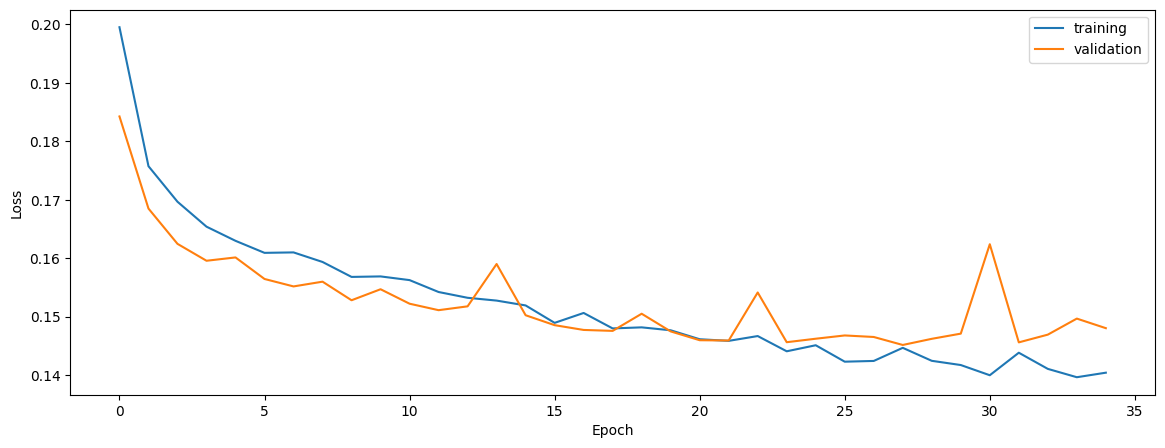

In [12]:
history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [13]:
props2 = props
model2 = model

In [14]:
import numpy as np

def getTrue(threshold):
    props=props1.copy()
    props['threshold'] = threshold
    props['radiomics'] = []
    props['radiomics_vox'] = [{'im':'t1','fe':['k5_b25']}]
    props['balance_data'] = False
    props['include_warp'] = True
    gen = DataGenerator(**props)
    return gen

def getPred(threshold, cla, reg):
    reg = reg[:,0]
    pred = cla.copy()
    pred[:,-1] = np.where(reg < threshold, 1, 0)
    for i in range(cla.shape[-1]-1):
        pred[:,i] = np.where(reg < threshold, 0, pred[:,i])
    return pred

In [15]:
from util import getAccuarcy, predictInBatches

props1['balance_data'] = False
props2['balance_data'] = False
gen1 = DataGenerator(**props1)
gen2 = DataGenerator(**props2)
train1, val1, test1 = gen1.getData()
train2, val2, test2 = gen2.getData()

train_cla = predictInBatches(model1,train1[0],architecture['batch_size'])
val_cla = predictInBatches(model1,val1[0],architecture['batch_size'])
test_cla = predictInBatches(model1,test1[0],architecture['batch_size'])
train_reg = predictInBatches(model2,train2[0],architecture['batch_size'])
val_reg = predictInBatches(model2,val2[0],architecture['batch_size'])
test_reg = predictInBatches(model2,test2[0],architecture['batch_size'])

threshold = props['threshold']

gen = getTrue(threshold)
train_true, val_true, test_true = gen.getData()
train_pred = getPred(threshold, train_cla, train_reg)
val_pred = getPred(threshold, val_cla, val_reg)
test_pred = getPred(threshold, test_cla, test_reg)

print('native')
print(getAccuarcy(train_true[1],train_pred))
print(getAccuarcy(val_true[1],val_pred))
print(getAccuarcy(test_true[1],test_pred))

native
0.6561654878698
0.6506830895008606
0.6175232319706819


In [16]:
print('normalized')
print(getAccuarcy(train_true[1][train_true[2]],train_pred[train_true[2]]))
print(getAccuarcy(val_true[1][val_true[2]],val_pred[val_true[2]]))
print(getAccuarcy(test_true[1][test_true[2]],test_pred[test_true[2]]))

normalized
0.6530580605152322
0.6420948399163824
0.6210915292779988


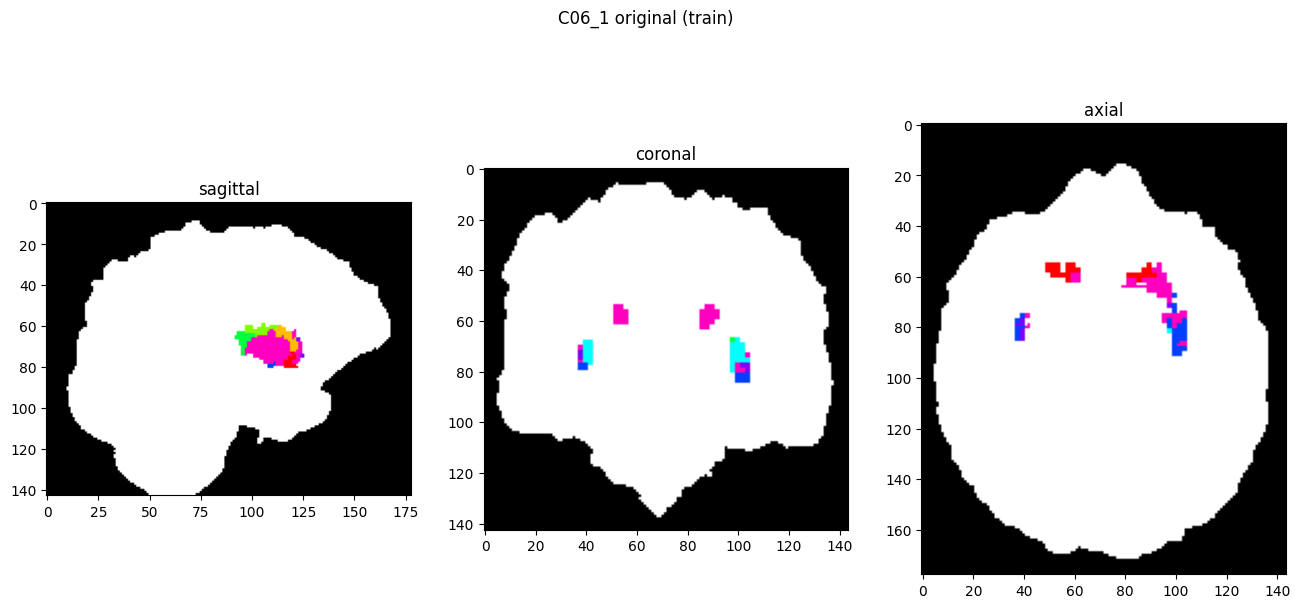

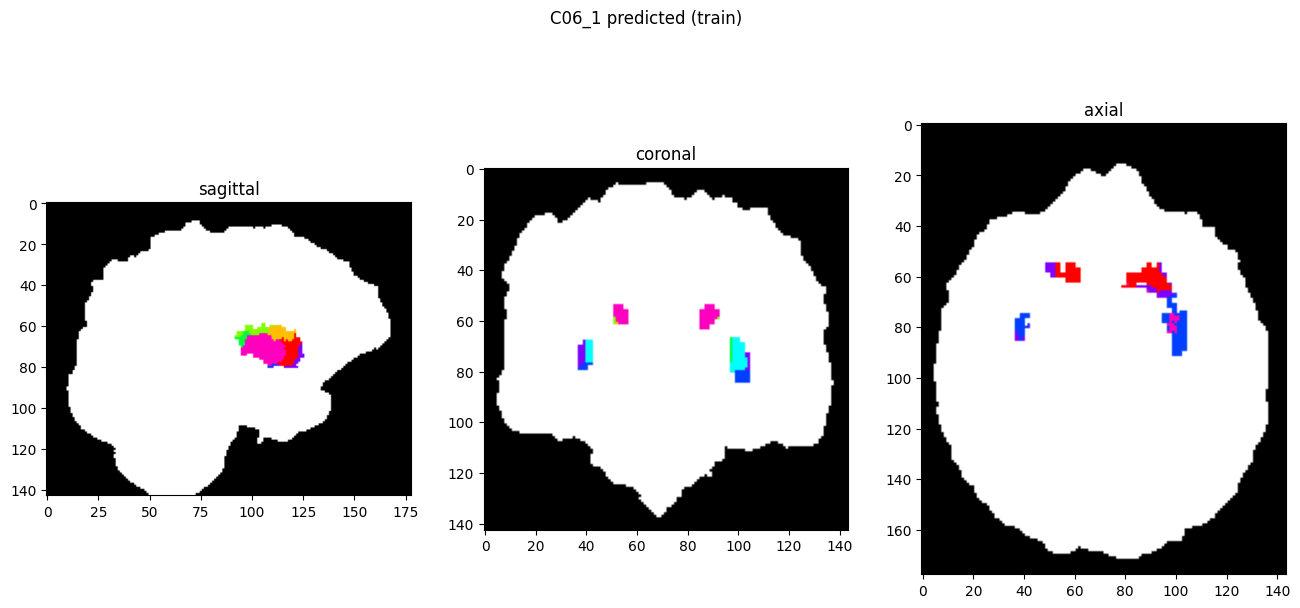

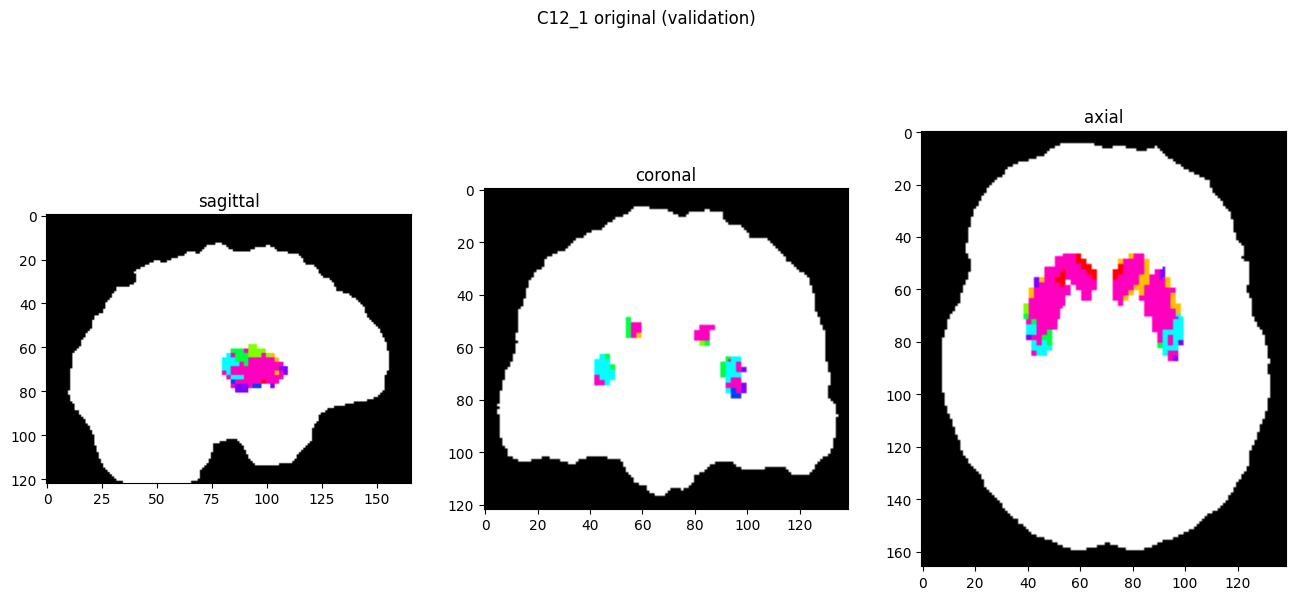

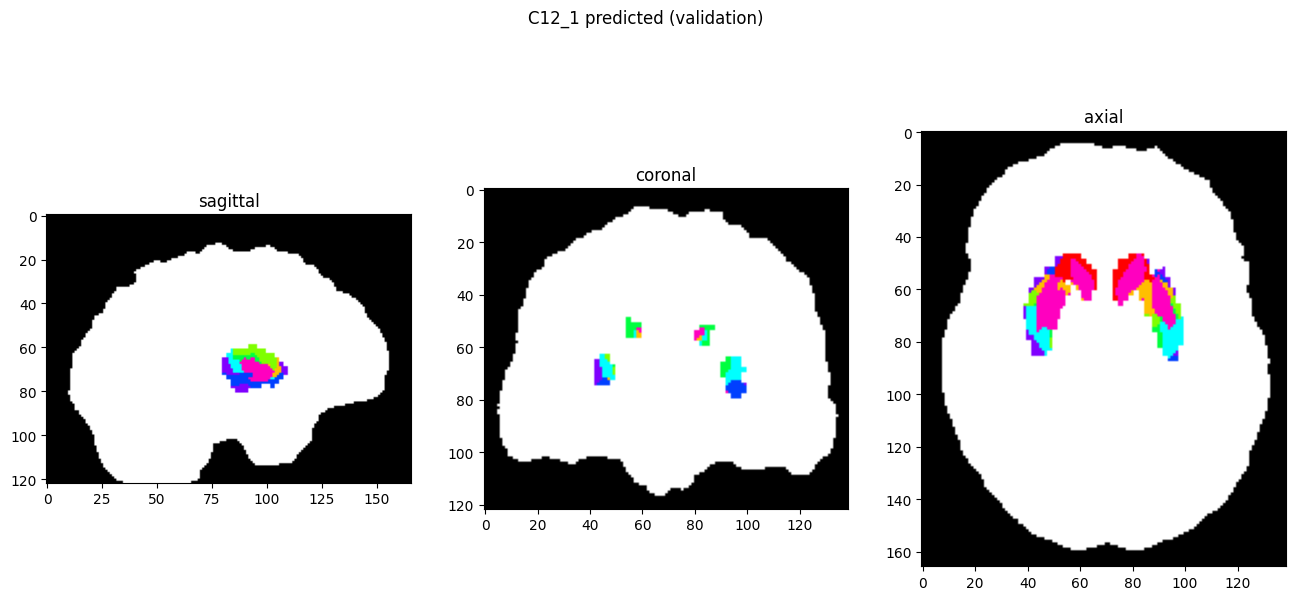

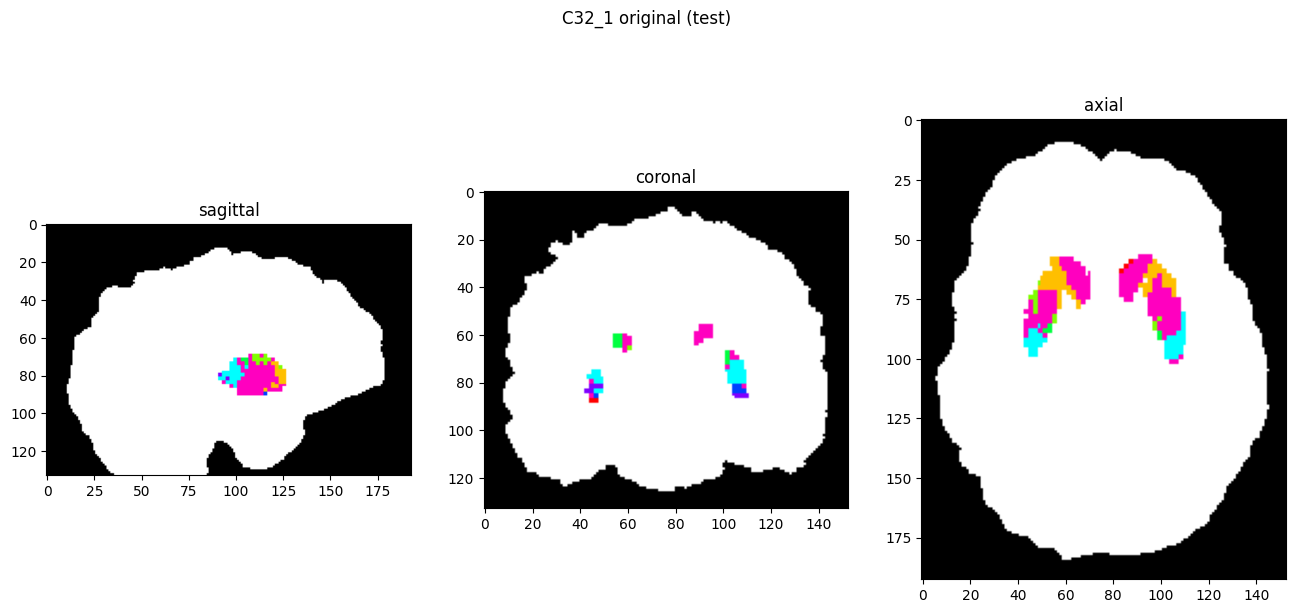

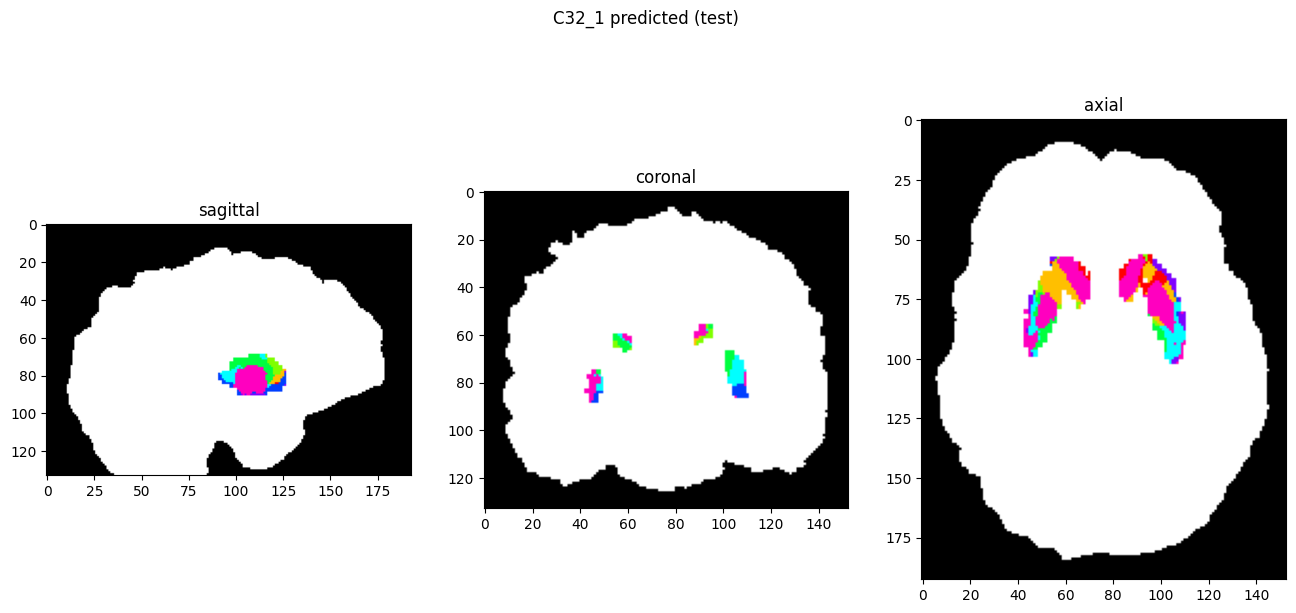

In [17]:
def customPredict(mode):
    idx = {'train':0,'validation':1,'test':2}[mode]
    dat_cla = gen1.getReconstructor(gen1.names[idx][0])
    dat_reg = gen2.getReconstructor(gen2.names[idx][0])
    pred_cla = predictInBatches(model1,dat_cla[0],architecture['batch_size'])
    pred_reg = predictInBatches(model2,dat_reg[0],architecture['batch_size'])
    return getPred(threshold, pred_cla, pred_reg)

showResults(model, gen, threshold=0, predict=customPredict)